# Notebook Configuration

### Declare libraries that i am going to use

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
pd.set_option("display.max_columns", 30)
import numpy as np
# librerías para análisis estadístico
import scipy as sp
# librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import os
import time
from datetime import datetime

### set the working directory of my local 

In [2]:
# you need to change it if you are going to run it on your local machine, writing the folder where the raw data of the challenge is
os.chdir('/Users/iairlinker/Documents/repos/cornershop_test/data')

### declare functions made by me that i am going to use

In [3]:
# función creada por mi para traer los NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

## función creada por mi para extraer las medidas de tendencia central en valores agrupados
def get_measure_central_tendency(df,constant_variable,explanatory_variable, metric):
    avg = df.groupby([explanatory_variable])[metric].mean().reset_index()
    avg.rename(columns=({metric:'mean'}), inplace=True)
    std = df.groupby([explanatory_variable])[metric].std().reset_index()
    std.rename(columns=({metric:'std'}), inplace=True)
    median = df.groupby([explanatory_variable])[metric].median().reset_index()
    median.rename(columns=({metric:'median'}), inplace=True)
    # con esto obtengo la cantidad de órdenes por comuna
    quantity = df.groupby(explanatory_variable)[constant_variable].nunique().reset_index()
    quantity.rename(columns=({constant_variable:'quantity'}), inplace=True)
    aux = pd.merge(avg, std, how='left', on=explanatory_variable)
    aux = pd.merge(aux, median, how='left', on=explanatory_variable)
    aux = pd.merge(aux, quantity, how='left', on=explanatory_variable).sort_values(by='quantity', ascending=True).reset_index(drop=True)
    aux['coef_var_pearson'] = aux['std'] / aux['mean']
    del avg, std, median
    aux['cumsum_quantity'] = aux.quantity.cumsum()
    aux['cumsum_quantity_pp'] = aux['cumsum_quantity']/ df[constant_variable].shape[0]
    return aux

## función creada por mi para extraer las medidas de tendencia central en valores agrupados cuando quiero agrupar por 2 variables
def get_get_measure_central_tendency_2(df,constant_variable,explanatory_variable1,explanatory_variable2, metric):
    # acá obtengo la cantidad promedio y mediana que solicitan de cada producto
# También agrego las desviaciones estándar de los promedios para validar si el promedio es representativo
    avg = order_products.groupby([explanatory_variable1,explanatory_variable2])[metric].mean().reset_index()
    avg.rename(columns=({metric:'mean'}), inplace=True)
    std = order_products.groupby([explanatory_variable1,explanatory_variable2])[metric].std().reset_index()
    std.rename(columns=({metric:'std'}), inplace=True)
    median = order_products.groupby([explanatory_variable1,explanatory_variable2])[metric].median().reset_index()
    median.rename(columns=({metric:'median'}), inplace=True)
    # con esto obtengo la cantidad de veces que cada producto aparece en una orden, lo cual me permite sacar los productos más y menos frecuentes
    quantity = order_products.groupby([explanatory_variable1,explanatory_variable2])[constant_variable].nunique().reset_index()
    quantity.rename(columns=({constant_variable:metric}), inplace=True)
    aux = pd.merge(avg, std, how='left', on=[explanatory_variable1,explanatory_variable2])
    aux = pd.merge(aux, median, how='left', on=[explanatory_variable1,explanatory_variable2])
    aux = pd.merge(aux, quantity, how='left', on=[explanatory_variable1,explanatory_variable2]).sort_values(by=metric, ascending=False)
    aux['coef_var_pearson'] = aux['std'] / aux['mean']
    del avg, std, median
    return aux

### Load data that i already has proceessed and clean in get_data.ipynb

In [4]:
# Loading pre-processed dataset
order_products = pd.read_csv('interim/order_products.csv', sep=';')
stores = pd.read_csv('interim/stores.csv', sep=';')
shoppers = pd.read_csv('interim/shoppers.csv', sep=';')
orders = pd.read_csv('interim/orders.csv', sep=';')
model_data = pd.read_csv('interim/model_data.csv', sep=';')
results = pd.read_csv('interim/results.csv', sep=';')

### Transformations made to made the EDA simplier 

In [5]:
# Transformation for model_data
model_data['is_weighted'] = model_data.KG.apply(lambda x: 1 if x>0 else 0)

# EDA

### **In order to understand the sample, we ask ourselves the following questions:** 

* Which is the size of the sample?
* On what days and hours is the sample taken?
* On what days and hours do the peak applications occur?
* In what days and hours are the peak delays in completing the order?

#### evidence

count    8000.000000
mean       81.106130
std        34.720837
min        11.969489
25%        55.225480
50%        74.731672
75%       100.273498
max       304.190303
Name: total_minutes, dtype: float64


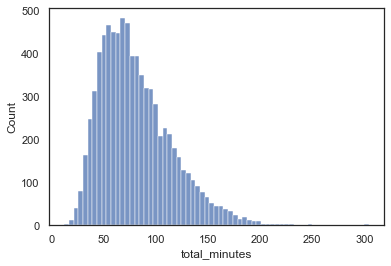

In [6]:
print(model_data['total_minutes'].describe())
sns.histplot(data=model_data,x=model_data.total_minutes);

            count       mean        std        min        25%        50%  \
on_demand                                                                  
False      4362.0  89.436066  37.077655  11.969489  61.525154  84.340943   
True       3638.0  71.118450  28.635052  18.192689  50.628070  66.605007   

                  75%         max  
on_demand                          
False      112.132380  304.190303  
True        85.877134  303.029792  


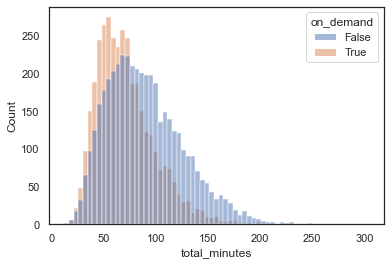

In [7]:
print(model_data.groupby('on_demand')['total_minutes'].describe())
sns.histplot(data=model_data,x="total_minutes",hue="on_demand");

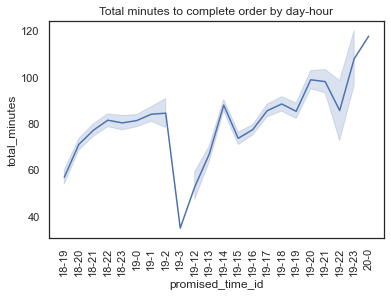

In [8]:
sns.lineplot(data=model_data.sort_values(by='promised_time'), x="promised_time_id", y="total_minutes")
plt.xticks(rotation=90)
plt.title('Total minutes to complete order by day-hour')
plt.show()

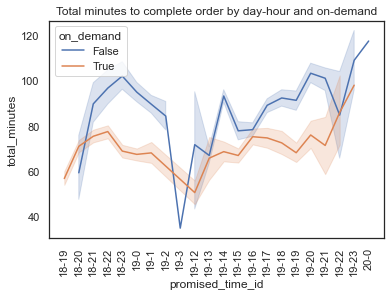

In [9]:
sns.lineplot(data=model_data.sort_values(by='promised_time'),  x="promised_time_id", y="total_minutes",hue="on_demand")
plt.xticks(rotation=90)
plt.title('Total minutes to complete order by day-hour and on-demand')
plt.show()

             mean      median    quantity
count   22.000000   22.000000   22.000000
mean    80.674296   76.471721  363.636364
std     17.900994   18.741526  260.307427
min     34.901043   34.901043    1.000000
25%     74.392111   67.917756  103.250000
50%     82.619977   75.859860  429.500000
75%     87.253601   82.775788  586.750000
max    117.480189  117.480189  772.000000


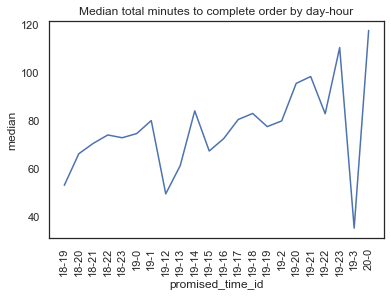

In [10]:
aux = get_measure_central_tendency(model_data,'order_id','promised_time_id', 'total_minutes').sort_values(by='promised_time_id')
print(aux[['mean','median','quantity']].describe())
sns.lineplot(data=aux, x="promised_time_id", y="median")
plt.xticks(rotation=90)
plt.title('Median total minutes to complete order by day-hour')
plt.show()

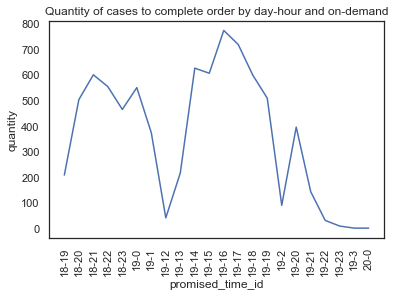

In [11]:
sns.lineplot(data=aux,  x="promised_time_id", y="quantity")
plt.xticks(rotation=90)
plt.title('Quantity of cases to complete order by day-hour and on-demand')
plt.show()

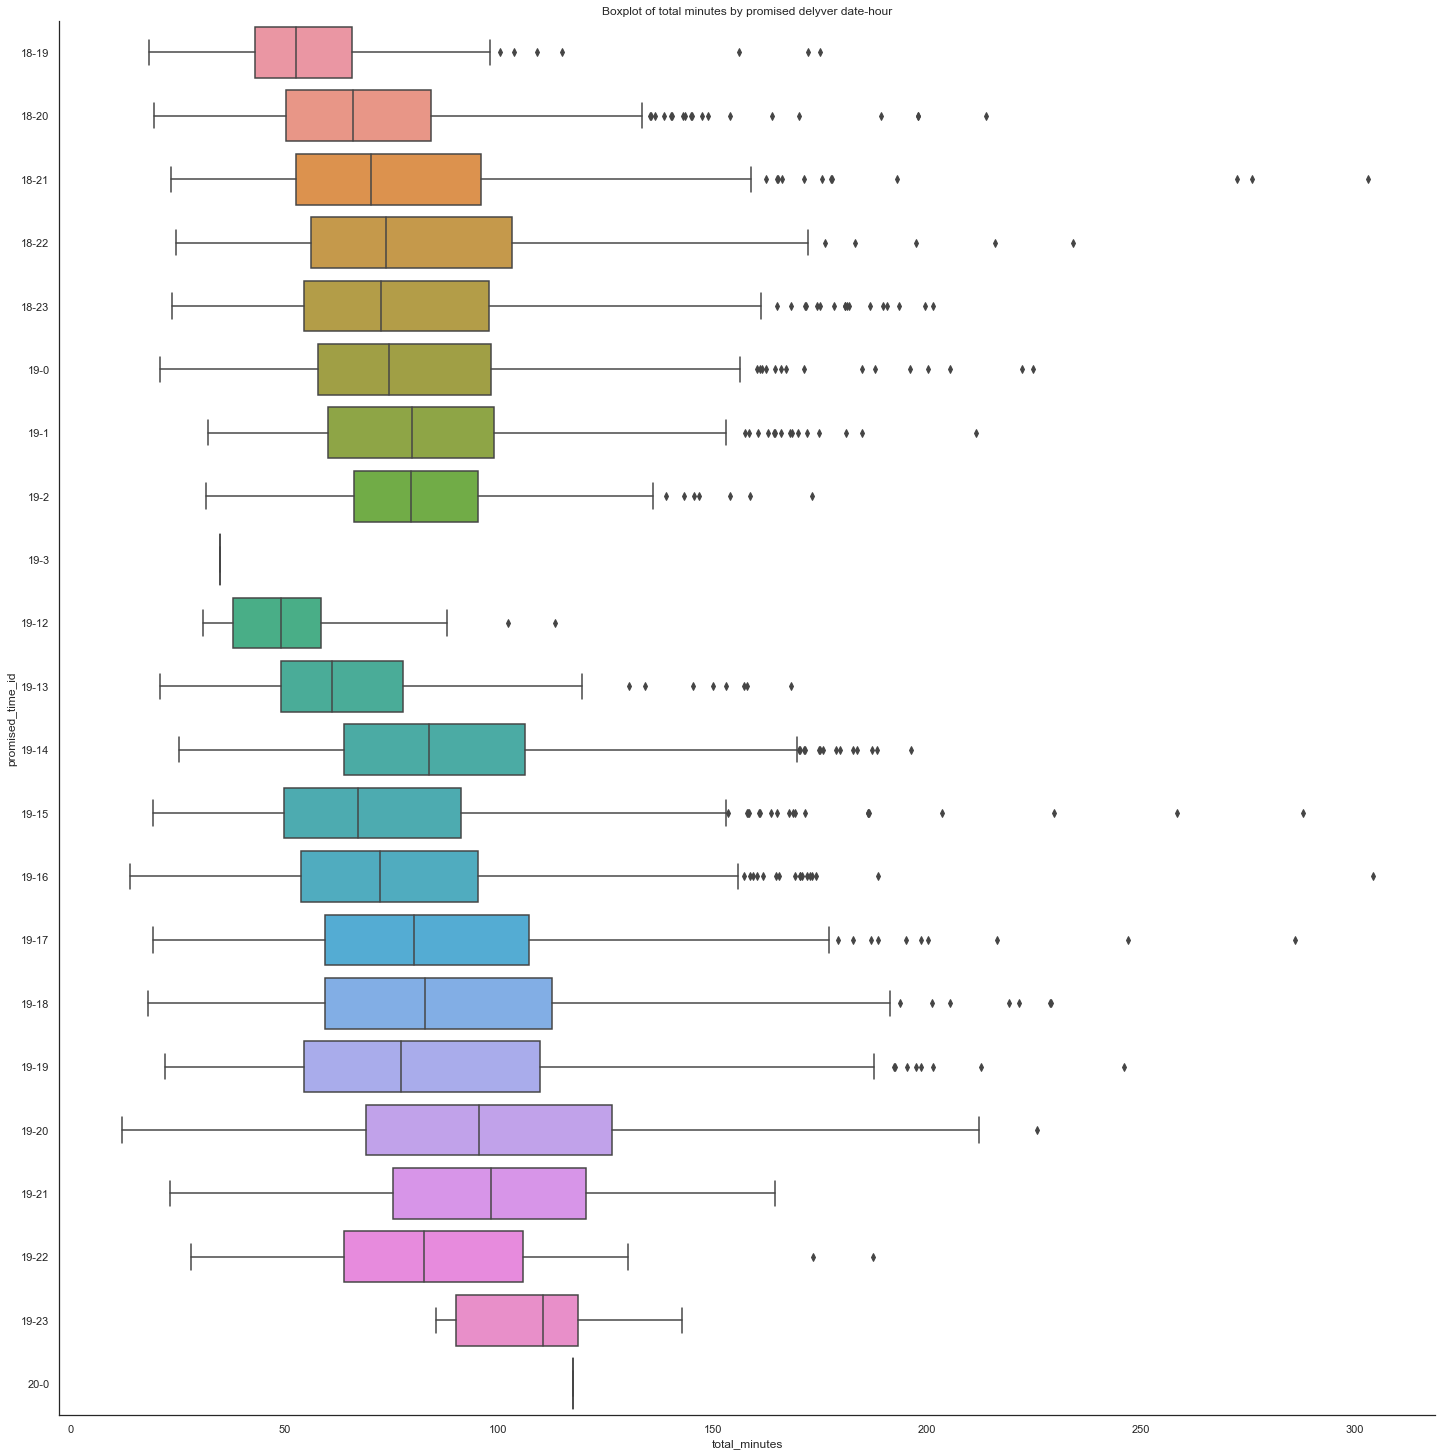

In [12]:
sns.catplot(x="total_minutes", y="promised_time_id",data=model_data,
            height=20,kind="box", order = model_data.sort_values(by='promised_time').promised_time_id.unique())
plt.title('Boxplot of total minutes by promised delyver date-hour')
plt.show();

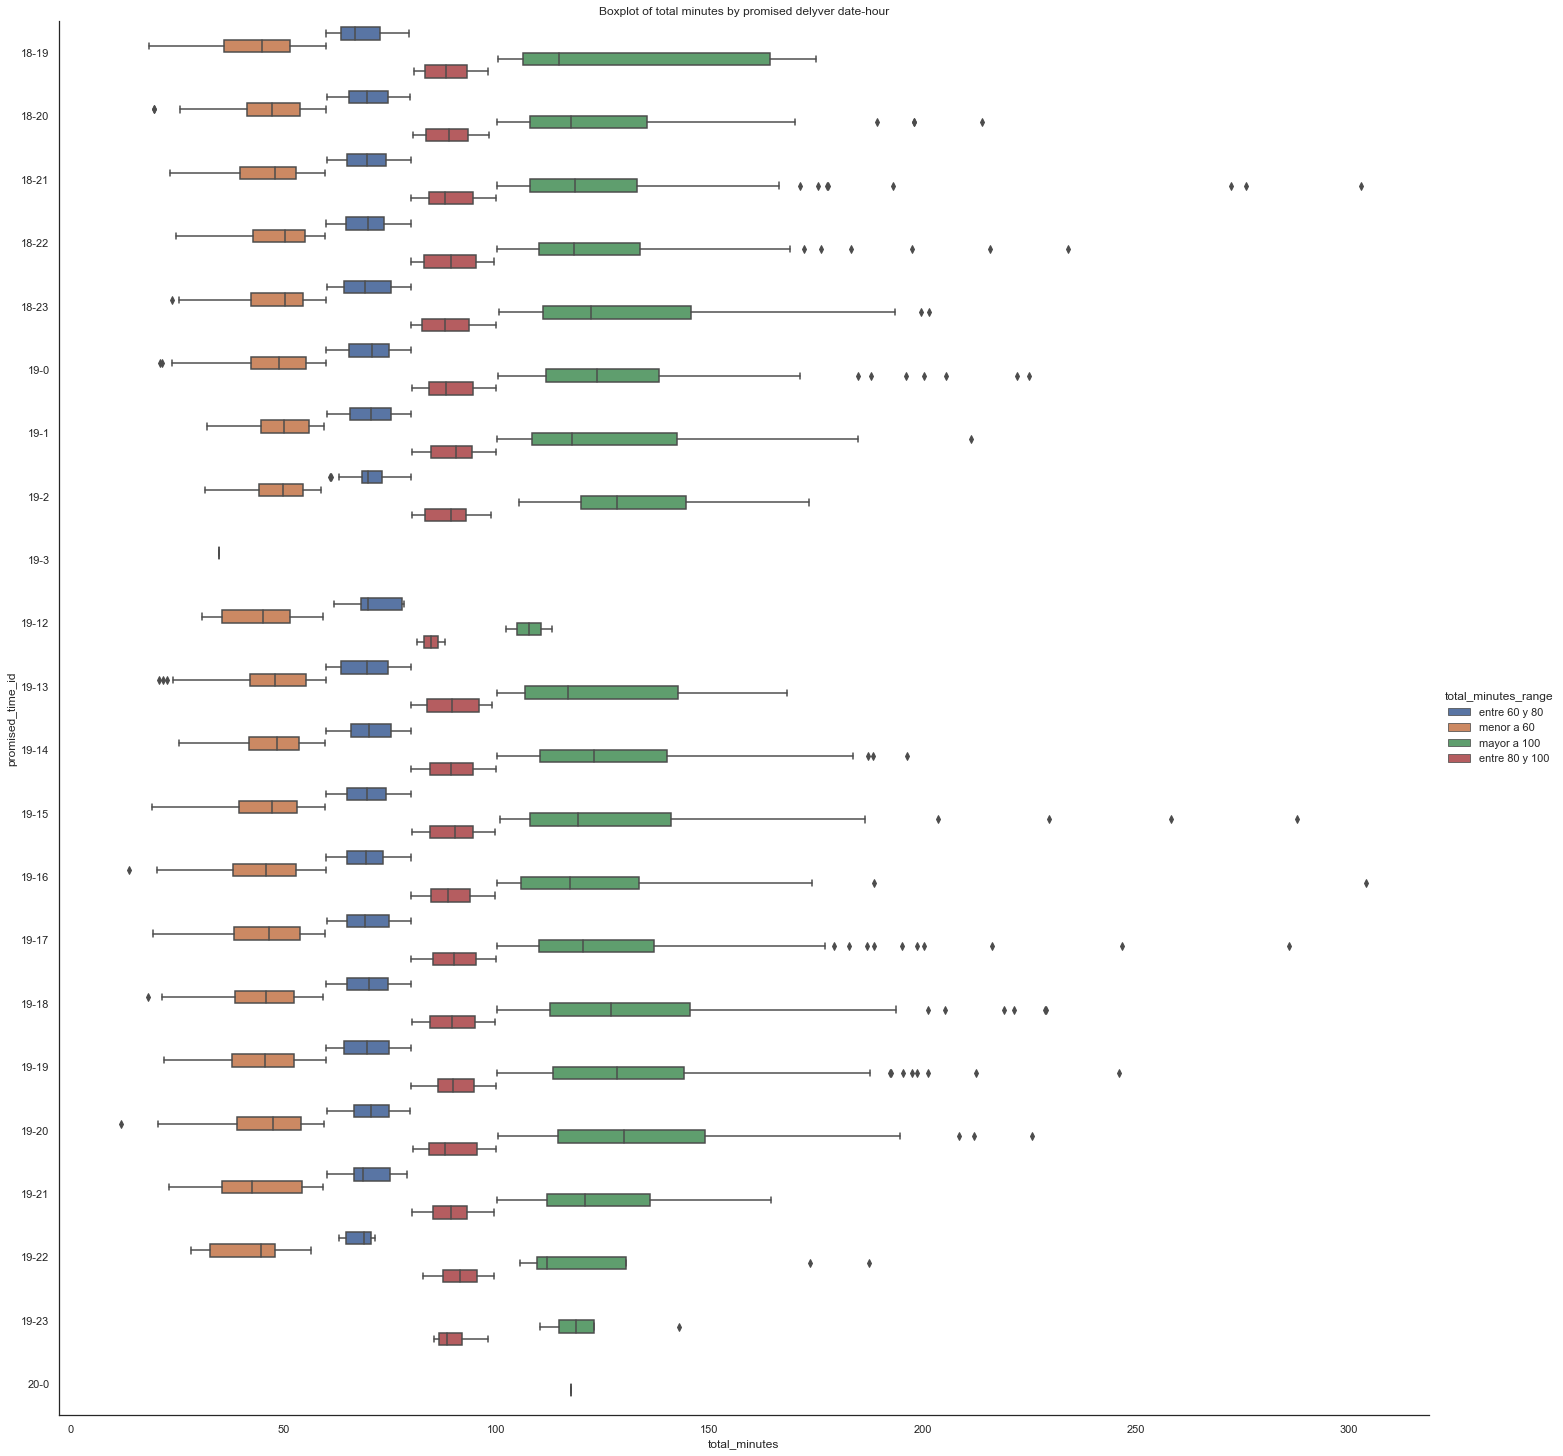

In [13]:
sns.catplot(x="total_minutes", y="promised_time_id",hue='total_minutes_range',data=model_data,
            height=20,kind="box", order = model_data.sort_values(by='promised_time').promised_time_id.unique())
plt.title('Boxplot of total minutes by promised delyver date-hour')
plt.show();

In [14]:
aux.sort_values(by='quantity', ascending=False)

promised_time_id        mean        std      median  quantity  \
21            19-16   77.269592  31.930824   72.302532       772   
20            19-17   85.425885  35.423627   80.279887       717   
19            19-14   87.836619  33.045037   83.879463       625   
18            19-15   73.531929  34.036648   67.120194       605   
17            18-21   76.972655  33.936078   70.310443       599   
16            19-18   88.307844  38.019203   82.804974       598   
15            18-22   81.336976  33.168270   73.815741       553   
14             19-0   81.169814  32.949084   74.414425       549   
13            19-19   85.165060  38.557006   77.305294       508   
12            18-20   70.896582  29.080650   65.970555       502   
11            18-23   80.183476  34.519171   72.652284       464   
10            19-20   98.718681  39.858765   95.359381       395   
9              19-1   83.902978  31.491224   79.830846       373   
8             19-13   66.724590  26.316332   61.036117       216   
7             18-19   56.794667  22.683239   52.778600       208   
6             19-21   97.948317  31.123490   98.231794       143   
5              19-2   84.366245  30.213891   79.679179        90   
4             19-12   52.651369  19.282073   49.228357        41   
3             19-22   85.504547  36.137937   82.688229        31   
2             19-23  107.745463  19.308376  110.308327         9   
1              19-3   34.901043        NaN   34.901043         1   
0              20-0  117.480189        NaN  117.480189         1   

    coef_var_pearson  cumsum_quantity  cumsum_quantity_pp  
21          0.413239             8000            1.000000  
20          0.414671             7228            0.903500  
19          0.376210             6511            0.813875  
18          0.462883             5886            0.735750  
17          0.440885             5281            0.660125  
16          0.430530             4682            0.585250  
15          0.407788             4084            0.510500  
14          0.405928             3531            0.441375  
13          0.452733             2982            0.372750  
12          0.410184             2474            0.309250  
11          0.430502             1972            0.246500  
10          0.403761             1508            0.188500  
9           0.375329             1113            0.139125  
8           0.394402              740            0.092500  
7           0.399390              524            0.065500  
6           0.317754              316            0.039500  
5           0.358128              173            0.021625  
4           0.366222               83            0.010375  
3           0.422643               42            0.005250  
2           0.179204               11            0.001375  
1                NaN                2            0.000250  
0                NaN                1            0.000125

#### **Conclusions** 

* **Which is the size of the sample?**

10,000 orders were collected that were collected by 2,864 shoppers in 476 stores in 44 communes of Chile (mostly RM). Of the 10k, only 8,000 have the total time estimated by Cornershop and the other 2,000 are orders on which we must make the prediction. That is why we will use separate the sample into 2 datasets, the 8,000 data with the name model_data and the other 2,000 with the name results.


* **On what days and hours is the sample taken?**

It is taken between 19pm on 2019-10-18 until 00:00 on 2019-10-19

* **What is the magnitude of the quantity of products to be delivered per hour?**

In the hours of low demand, the quantity of products per hour ranged between 1 and 216 orders to be delivered, while in peak demand it ranged between 464 and 772 orders to be delivered per hour. It is important to note that 50% of the orders were requested between 21pm and 22pm on 10-18-2019 or between 14pm and 18pm on 10-19-2019

* **On what days and hours do the peak applications occur?**

The peak in the number of orders to be delivered per hour on 10-18-2019 begins at 21pm and runs until 00:00 on the same day. The peak of 10-19-2019 in the number of orders to be delivered per hour runs between 2pm and 7pm on the same day

* **In what days and hours are the peak delays in completing the order?**

the peak of delay will be located mainly in the hours after the delivery peaks. The hypothesis is that this is due to an effect of accumulation of orders of the previous hours that ends negatively impact in the hours immediately after.


--------------------------------------------------------------------------------------------------------------------------------------------------------------

## Shoppers

### Question to understand the characteristics of the shopper

* Does the time it takes for an order to arrive, does it vary according to the characteristics of the shoper?

* Can we group shoppers by their characteristics?

* In the event that shopers could be grouped by their characteristics: are there significant differences in the time to complete the order between the groups?

#### **Evidence**

count    2763.000000
mean        0.861082
std         0.031038
min         0.737300
25%         0.842900
50%         0.863900
75%         0.881950
max         0.971000
Name: found_rate, dtype: float64


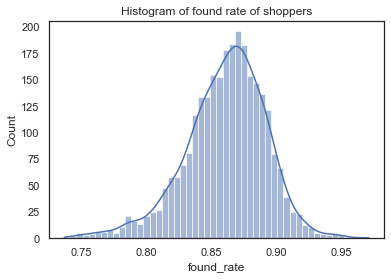

In [15]:
print(shoppers.found_rate.describe())
sns.histplot(data=shoppers, x="found_rate", kde=True, bins=50)
plt.title('Histogram of found rate of shoppers')
plt.show();

                      count      mean       std     min      25%     50%  \
total_minutes_range                                                        
entre 60 y 80        1951.0  0.864230  0.030278  0.7429  0.84735  0.8679   
entre 80 y 100       1483.0  0.863407  0.028960  0.7373  0.84735  0.8662   
mayor a 100          1973.0  0.858812  0.029856  0.7500  0.84090  0.8608   
menor a 60           2424.0  0.866352  0.029770  0.7429  0.84960  0.8696   

                         75%     max  
total_minutes_range                   
entre 60 y 80        0.88485  0.9647  
entre 80 y 100       0.88305  0.9453  
mayor a 100          0.87860  0.9710  
menor a 60           0.88620  0.9647  


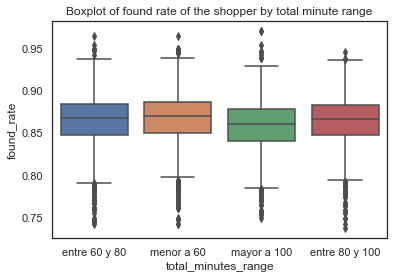

In [16]:
print(model_data.groupby('total_minutes_range')['found_rate'].describe())
sns.boxplot(x="total_minutes_range", y="found_rate",data=model_data)
plt.title('Boxplot of found rate of the shopper by total minute range');

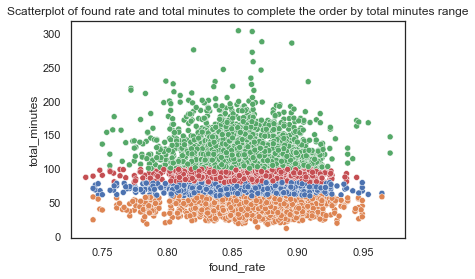

In [17]:
sns.scatterplot(data=model_data, y="total_minutes", x="found_rate", hue='total_minutes_range' , legend=False)
plt.title('Scatterplot of found rate and total minutes to complete the order by total minutes range')
plt.show();

count    8000.000000
mean        1.690111
std         0.630485
min         0.650000
25%         1.260000
50%         1.520000
75%         2.000000
max         7.040000
Name: picking_speed, dtype: float64


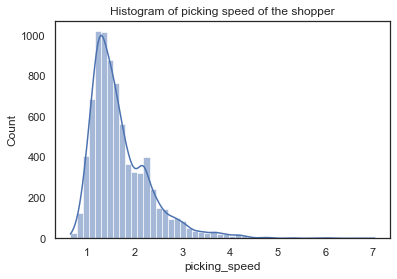

In [18]:
print(model_data.picking_speed.describe())
sns.histplot(data=model_data, x="picking_speed", kde=True, bins=50)
plt.title('Histogram of picking speed of the shopper');

                      count      mean       std   min   25%   50%    75%   max
total_minutes_range                                                           
entre 60 y 80        1994.0  1.656023  0.620995  0.73  1.25  1.50  1.900  5.98
entre 80 y 100       1503.0  1.654997  0.606296  0.73  1.26  1.50  1.880  7.04
mayor a 100          2019.0  1.767127  0.645457  0.73  1.31  1.58  2.095  6.11
menor a 60           2484.0  1.676123  0.635135  0.65  1.23  1.50  2.050  5.98


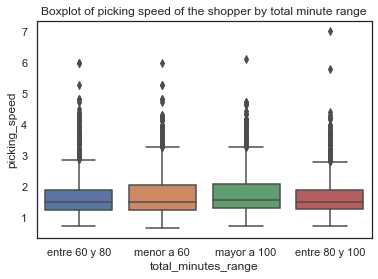

In [19]:
print(model_data.groupby('total_minutes_range')['picking_speed'].describe())
sns.boxplot(x="total_minutes_range", y="picking_speed",data=model_data)
plt.title('Boxplot of picking speed of the shopper by total minute range');

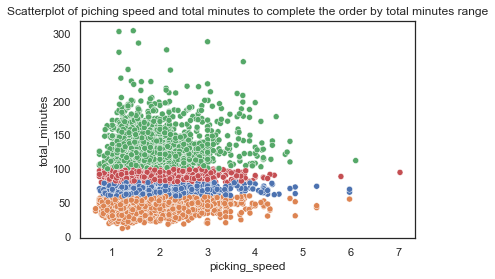

In [20]:
sns.scatterplot(data=model_data, y="total_minutes", x="picking_speed", hue='total_minutes_range',legend=False)
plt.title('Scatterplot of piching speed and total minutes to complete the order by total minutes range')
plt.show();

count    2780.000000
mean        4.848428
std         0.133011
min         3.880000
25%         4.800000
50%         4.880000
75%         4.960000
max         5.000000
Name: rating, dtype: float64


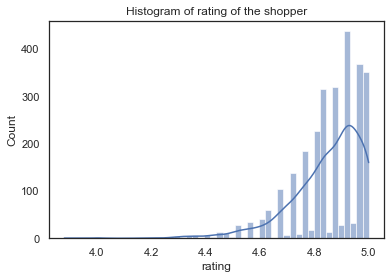

In [21]:
print(shoppers.rating.describe())
sns.histplot(data=shoppers, x=shoppers.rating, kde=True, bins=50)
plt.title('Histogram of rating of the shopper');

                      count      mean       std   min   25%   50%   75%  max
total_minutes_range                                                         
entre 60 y 80        1961.0  4.852902  0.126724  3.88  4.80  4.88  4.96  5.0
entre 80 y 100       1482.0  4.848509  0.131998  4.00  4.80  4.88  4.96  5.0
mayor a 100          1980.0  4.850197  0.129326  4.00  4.76  4.88  4.96  5.0
menor a 60           2439.0  4.850795  0.123781  3.88  4.80  4.88  4.94  5.0


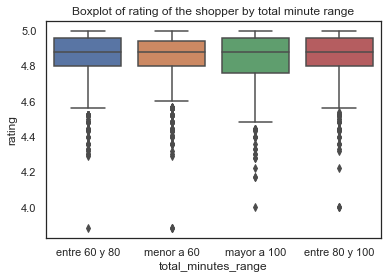

In [22]:
print(model_data.groupby('total_minutes_range')['rating'].describe())
sns.boxplot(x="total_minutes_range", y="rating",data=model_data)
plt.title('Boxplot of rating of the shopper by total minute range');

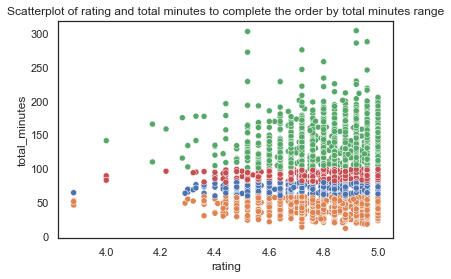

In [23]:
sns.scatterplot(data=model_data, y="total_minutes", x="rating", hue='total_minutes_range',legend=False)
plt.title('Scatterplot of rating and total minutes to complete the order by total minutes range')
plt.show();

count    2837.000000
mean        0.908276
std         0.107911
min         0.240000
25%         0.880000
50%         0.944444
75%         1.000000
max         1.000000
Name: accepted_rate, dtype: float64


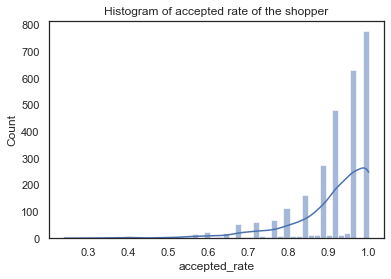

In [24]:
print(shoppers.accepted_rate.describe())
sns.histplot(data=shoppers, x="accepted_rate", kde=True, bins=50)
plt.title('Histogram of accepted rate of the shopper');

                      count      mean       std       min   25%       50%  \
total_minutes_range                                                         
entre 60 y 80        1984.0  0.918178  0.095789  0.320000  0.88  0.960000   
entre 80 y 100       1497.0  0.922206  0.090652  0.280000  0.88  0.960000   
mayor a 100          2004.0  0.911947  0.102453  0.240000  0.88  0.941176   
menor a 60           2474.0  0.915563  0.099243  0.285714  0.88  0.960000   

                     75%  max  
total_minutes_range            
entre 60 y 80        1.0  1.0  
entre 80 y 100       1.0  1.0  
mayor a 100          1.0  1.0  
menor a 60           1.0  1.0  


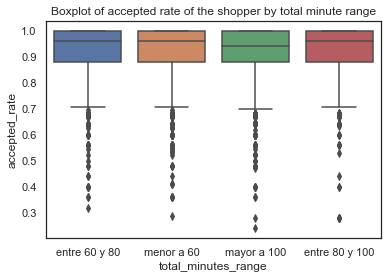

In [25]:
print(model_data.groupby('total_minutes_range')['accepted_rate'].describe())
sns.boxplot(x="total_minutes_range", y="accepted_rate",data=model_data)
plt.title('Boxplot of accepted rate of the shopper by total minute range');

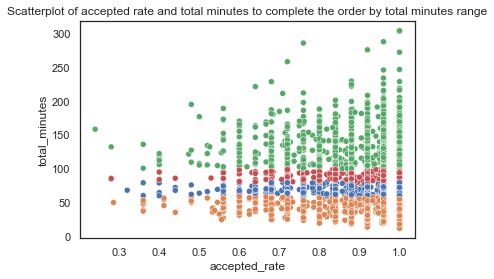

In [26]:
sns.scatterplot(data=model_data, y="total_minutes", x="accepted_rate", hue='total_minutes_range',legend=False)
plt.title('Scatterplot of accepted rate and total minutes to complete the order by total minutes range')
plt.show();

               count       mean        std        min        25%        50%  \
seniority                                                                     
ADVANCED      4904.0  80.928438  33.125084  11.969489  56.262478  75.247718   
BEGINNER      1207.0  81.781189  37.221665  18.192689  52.639455  74.872787   
INTERMEDIATE  1788.0  80.629333  36.740545  20.331018  53.469808  72.586850   
REVIEW         101.0  90.107319  41.328242  19.582987  58.809189  79.830846   

                     75%         max  
seniority                             
ADVANCED       99.480622  304.190303  
BEGINNER      104.100100  287.907109  
INTERMEDIATE  100.232315  285.964774  
REVIEW        117.737959  212.658895  


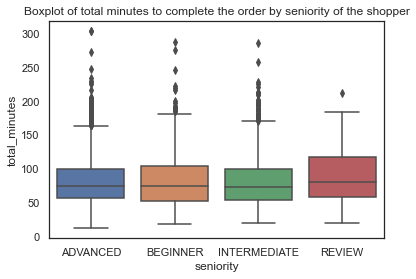

In [27]:
print(model_data.groupby('seniority')['total_minutes'].describe())
sns.boxplot(x='seniority', y="total_minutes",data=model_data)
plt.title('Boxplot of total minutes to complete the order by seniority of the shopper');

               total_minutes
found_rate         -0.109714
picking_speed       0.074073
accepted_rate      -0.011970
rating             -0.000127


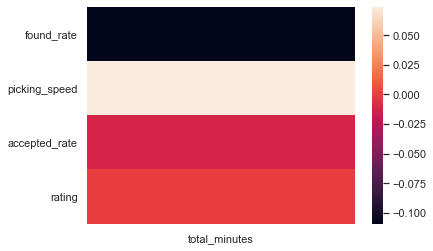

In [28]:
linear_corr = model_data.corr('spearman')[['total_minutes']].loc[['found_rate','picking_speed','accepted_rate','rating']]
print(linear_corr)
sns.heatmap(linear_corr);

               count      mean       std   min   25%   50%   75%  max
seniority                                                            
ADVANCED      4902.0  4.847821  0.125155  3.88  4.80  4.88  4.92  5.0
BEGINNER      1206.0  4.868964  0.121600  4.22  4.80  4.88  4.96  5.0
INTERMEDIATE  1736.0  4.845974  0.136309  4.00  4.76  4.88  4.96  5.0
REVIEW          18.0  4.883889  0.158416  4.60  4.71  5.00  5.00  5.0


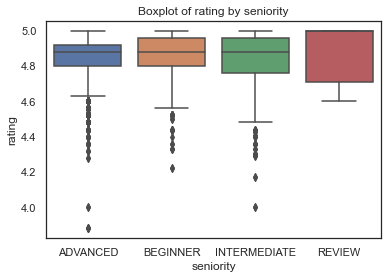

In [29]:
print(model_data.groupby('seniority')['rating'].describe())
sns.boxplot(x='seniority', y="rating",data=model_data)
plt.title('Boxplot of rating by seniority');

               count      mean       std   min       25%   50%   75%  max
seniority                                                                
ADVANCED      4904.0  0.957897  0.040331  0.85  0.920000  0.96  1.00  1.0
BEGINNER      1207.0  0.938774  0.053976  0.50  0.920000  0.96  0.96  1.0
INTERMEDIATE  1781.0  0.791908  0.117955  0.24  0.720000  0.80  0.84  1.0
REVIEW          67.0  0.803529  0.182962  0.40  0.690476  0.80  1.00  1.0


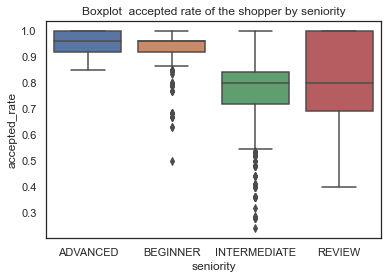

In [30]:
print(model_data.groupby('seniority')['accepted_rate'].describe())
sns.boxplot(x='seniority', y="accepted_rate",data=model_data)
plt.title('Boxplot  accepted rate of the shopper by seniority');

               count      mean       std     min       25%     50%       75%  \
seniority                                                                      
ADVANCED      4904.0  0.871665  0.023509  0.7560  0.856300  0.8726  0.887100   
BEGINNER      1189.0  0.847492  0.030141  0.7500  0.829700  0.8482  0.866700   
INTERMEDIATE  1724.0  0.850773  0.036128  0.7373  0.827325  0.8524  0.877900   
REVIEW          14.0  0.855086  0.062177  0.7558  0.804300  0.8500  0.887225   

                 max  
seniority             
ADVANCED      0.9647  
BEGINNER      0.9423  
INTERMEDIATE  0.9487  
REVIEW        0.9710  


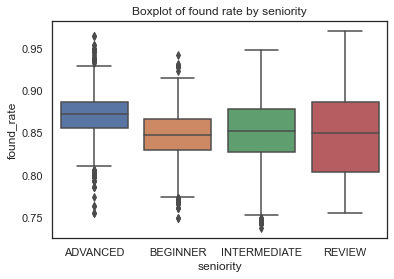

In [31]:
print(model_data.groupby('seniority')['found_rate'].describe())
sns.boxplot(x='seniority', y="found_rate",data=model_data)
plt.title('Boxplot of found rate by seniority');

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [33]:
# Renaming seniority column values 
shopper_seniority = {'ADVANCED': 3,
                     'INTERMEDIATE' : 2,
                     'BEGINNER': 1,
                      'REVIEW': 0}

model_data['seniority_encode'] = model_data['seniority'].map(shopper_seniority)
model_data.seniority_encode.unique()

array([3, 1, 2, 0])

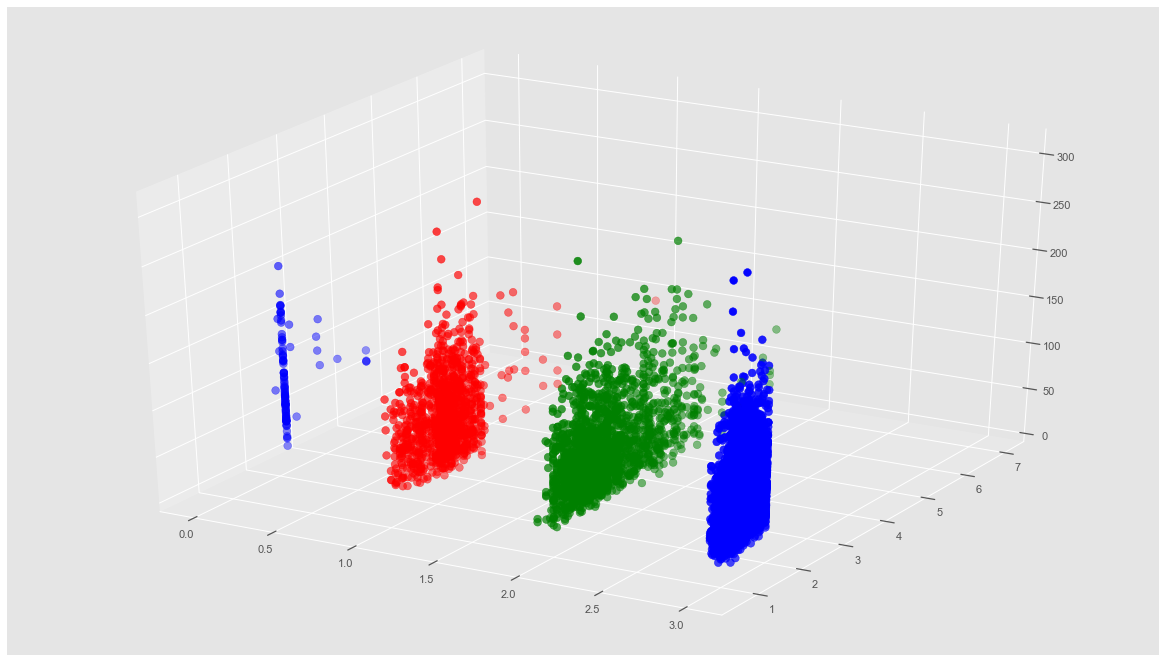

In [34]:
fig = plt.figure()
ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple']
asignar=[]
for row in np.array(model_data.seniority_encode):
    asignar.append(colores[row])
ax.scatter(model_data.seniority_encode,model_data.picking_speed,model_data.total_minutes, c=asignar,s=60);

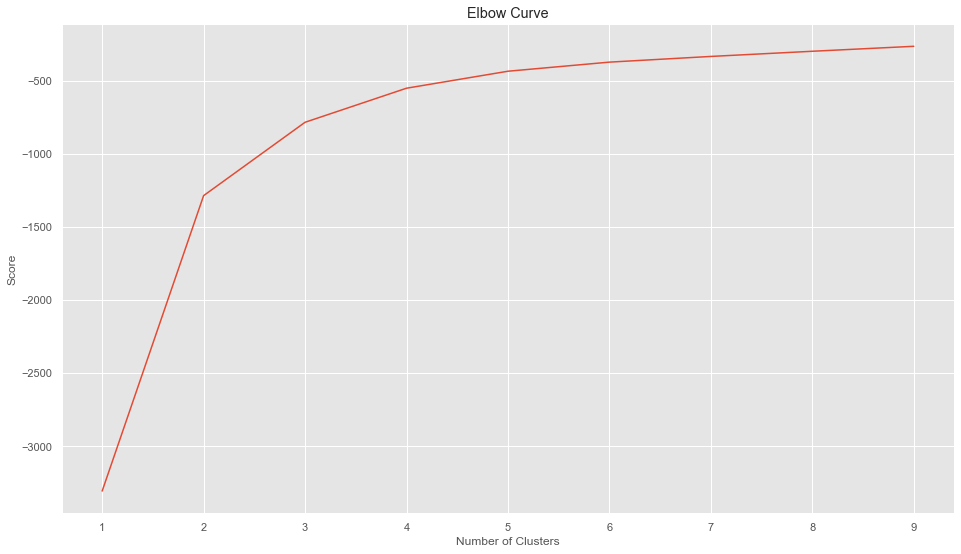

In [35]:
X = model_data[['found_rate','picking_speed','rating','accepted_rate']].dropna()
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [36]:
kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.87402662 1.21310086 4.84500972 0.94445714]
 [0.84889523 2.44869039 4.87354277 0.87991022]
 [0.83904549 3.70274306 4.81892361 0.85092222]
 [0.8589551  1.70259004 4.84983142 0.91055339]]


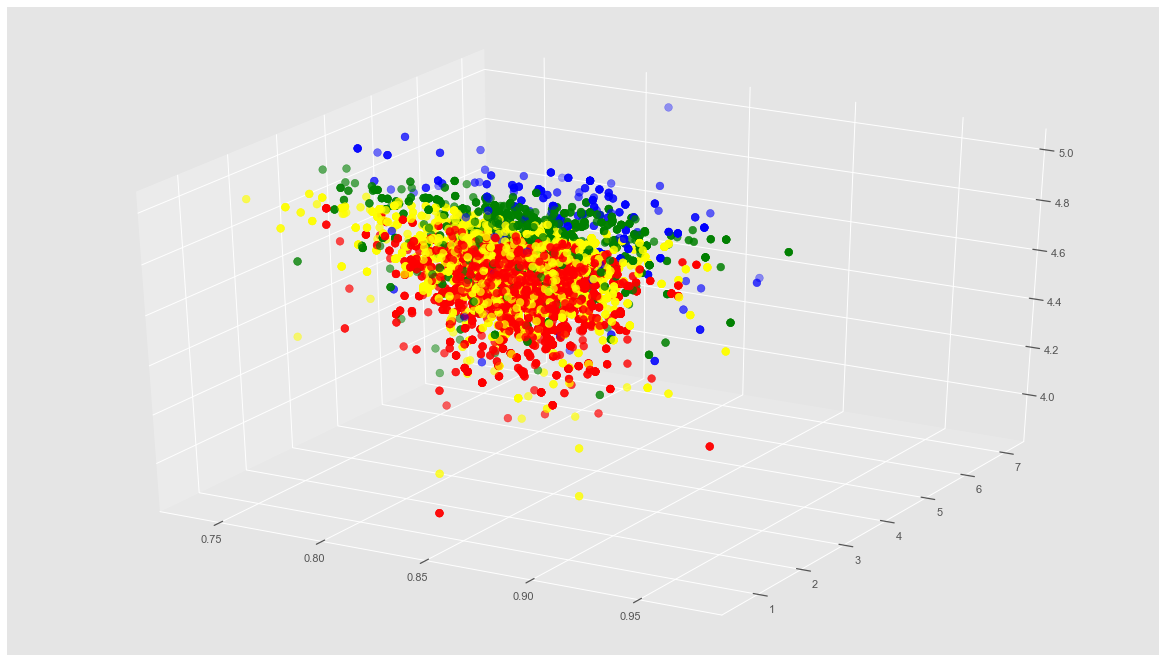

In [37]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue', 'yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2],marker='*', c=colores, s=1000);

#### **Conclusions:**

* Does the time it takes for an order to arrive, does it vary according to the characteristics of the shoper?


The only relationship that can be drawn are:

1.- Shoppers in review take, on average, longer than novices, intermediate and advanced

2.- Pickup speed is slightly higher for orders that took more than 100 minutes

There is no linear correlation between the variables that describe the shoppers and the total time to complete the order, as well as with the number of deliveries they made in the period analyzed.Nor do we see variations in the dispersion of the values of the total delivery time according to the ratio with which the product is found, acceptance ratio and shopper rating. 

* Can we group shoppers by their characteristics?

In principle, we cannot group shoppers only based on their characteristics associated with historical performance. The hypothesis is that the results were more dependent on the contextual variables of the order than on the shopper who collected them.

-------------------------------------------------------------------------

### Store

Research questions to understand the relationship of the time to complete the order with the stores:

* ¿how much store do i have in my sample?
    
* ¿where are the stores located?

* Does the quantity of orders requested vary according to the characteristics of the store?

* Does the time it takes for an order to arrive, does it vary according to the characteristics of the store?

#### evidence

In [38]:
len(model_data.store_branch_id.unique())

434

In [39]:
aux = get_measure_central_tendency(model_data,'order_id','store_district', 'total_minutes')
aux

store_district        mean        std      median  quantity  \
0             Chiguayante   75.217018        NaN   75.217018         1   
1              Talcahuano   39.979772        NaN   39.979772         1   
2     San Pedro de la Paz   75.476029        NaN   75.476029         1   
3           Independencia   66.190883        NaN   66.190883         1   
4                Pudahuel   49.569890  23.766070   49.569890         2   
5               Cerrillos   72.895219  12.700488   76.697931         3   
6                Recoleta   89.082161  44.377747   84.686553         4   
7            San Bernardo  114.083776  37.692136  105.490547         6   
8                Coquimbo   95.908001  24.442966  100.110453         7   
9                Santiago   82.874813  43.186163   78.916628         8   
10            Puente Alto   76.494924  25.535635   68.779766        24   
11  Provincia de Santiago   49.505086  20.185686   44.774431        24   
12              La Serena   85.798355  32.119049   80.576381        39   
13              Quilicura   95.821320  33.354872   87.558847        40   
14                Hualpén   89.188806  29.946836   81.145463        41   
15             Valparaíso  101.002715  27.240253   92.242467        48   
16             San Miguel  110.449276  43.327209   99.536564        64   
17                  Maipú   88.234811  30.523701   82.944047        65   
18              Peñalolén  100.228885  32.715845   95.802081        66   
19            Providencia   72.391152  34.469356   66.517316        88   
20            San Joaquín  114.710442  36.779038  109.405035        97   
21                 Concón   67.461635  26.459535   63.199456       112   
22             Concepción   83.080392  29.419061   75.629805       117   
23             Huechuraba   92.639769  35.963307   82.508365       119   
24       Estación Central  117.387279  40.531404  115.421446       122   
25             La Florida   79.198182  29.724495   74.343774       145   
26           Viña del Mar   83.815936  29.236947   79.768227       168   
27                  Macul  103.551042  40.554177   98.373778       240   
28               La Reina   85.402695  32.942247   80.062687       468   
29                  Ñuñoa  104.136645  38.627043   98.577213       526   
30                 Colina   67.413204  28.625393   60.674601       617   
31             Las Condes   74.102643  31.840524   67.276167      1070   
32           Lo Barnechea   66.864932  27.219043   61.671168      1524   
33               Vitacura   83.896372  33.380931   80.101420      2142   

    coef_var_pearson  cumsum_quantity  cumsum_quantity_pp  
0                NaN                1            0.000125  
1                NaN                2            0.000250  
2                NaN                3            0.000375  
3                NaN                4            0.000500  
4           0.479446                6            0.000750  
5           0.174229                9            0.001125  
6           0.498166               13            0.001625  
7           0.330390               19            0.002375  
8           0.254858               26            0.003250  
9           0.521101               34            0.004250  
10          0.333821               58            0.007250  
11          0.407750               82            0.010250  
12          0.374355              121            0.015125  
13          0.348094              161            0.020125  
14          0.335769              202            0.025250  
15          0.269698              250            0.031250  
16          0.392282              314            0.039250  
17          0.345937              379            0.047375  
18          0.326411              445            0.055625  
19          0.476154              533            0.066625  
20          0.320625              630            0.078750  
21          0.392216              742            0.092750  
22          0.354104              859   

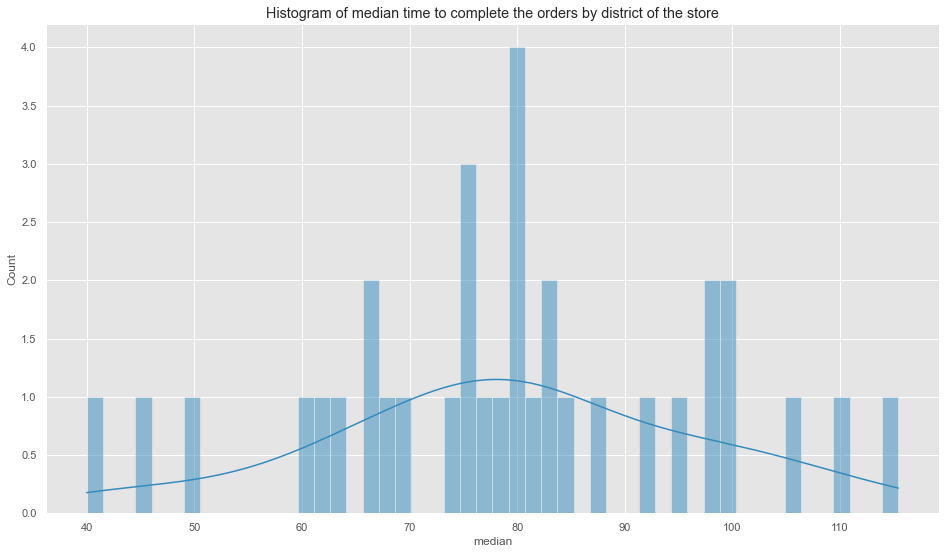

In [40]:
sns.histplot(data=aux, x="median", kde=True, bins=50)
plt.title('Histogram of median time to complete the orders by district of the store')
plt.show();

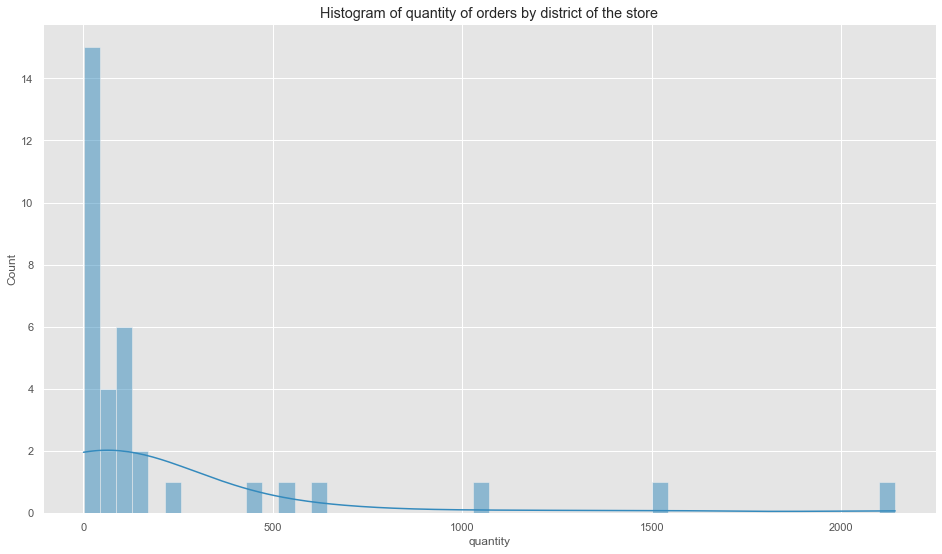

In [41]:
sns.histplot(data=aux, x="quantity", kde=True, bins=50)
plt.title('Histogram of quantity of orders by district of the store')
plt.show();

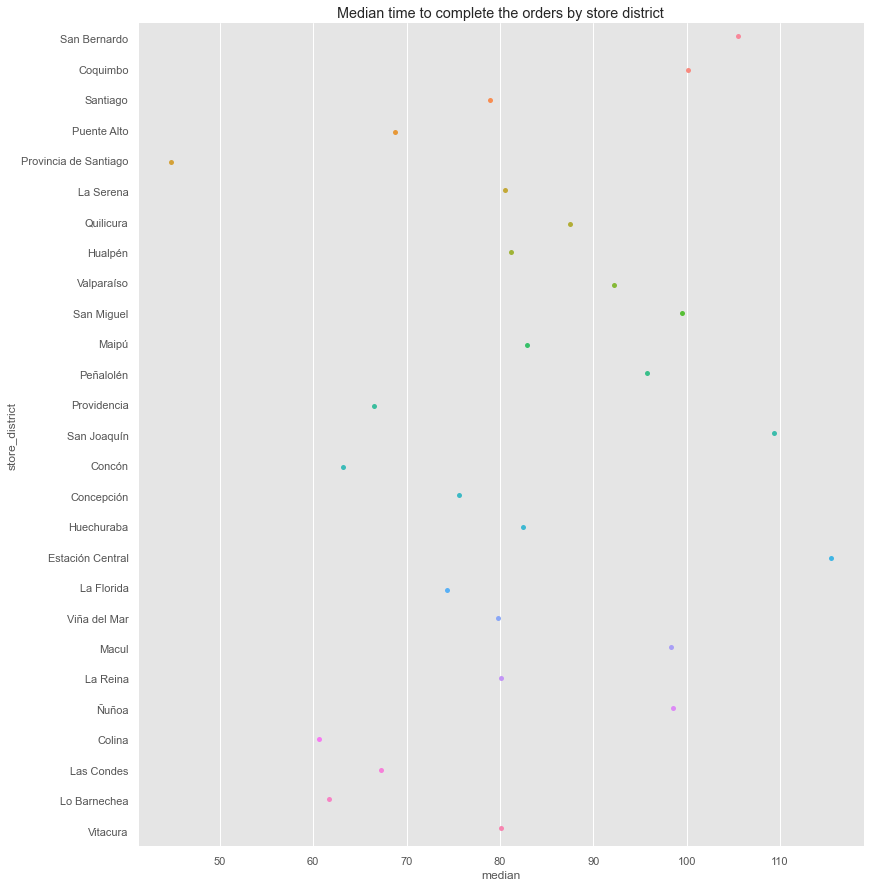

In [42]:
sns.catplot(x="median", y="store_district",orient="h", data=aux[aux.quantity>=5],aspect=1,height=12, legend=True)
plt.title('Median time to complete the orders by store district')
plt.show();

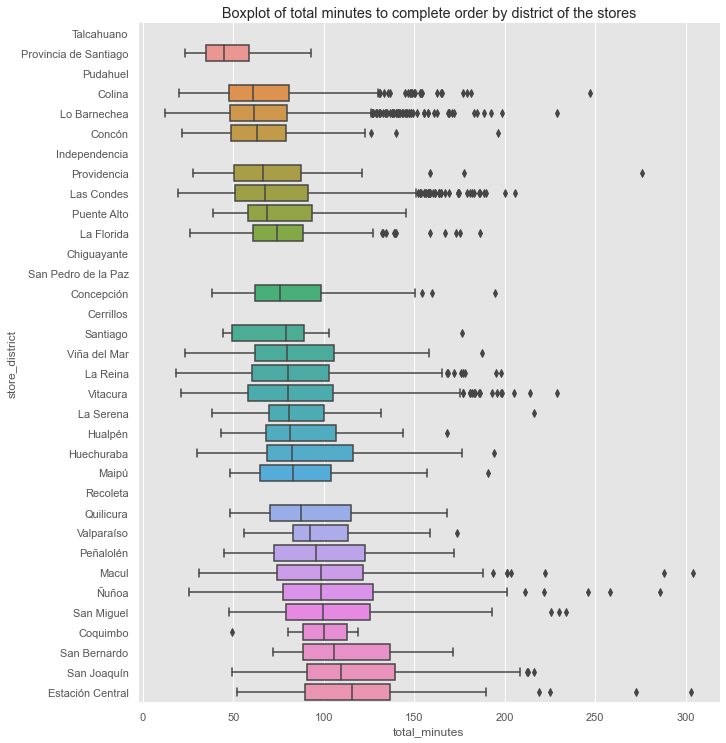

In [43]:
store_size_rep = list(aux[aux.quantity>=5].store_district)
aux2 = model_data.loc[model_data.store_district.apply(lambda x: True if x in store_size_rep else False)]
sns.catplot(x="total_minutes", y="store_district",data=aux2,
            height=10,kind="box", order= aux.sort_values(by='median').store_district.unique())
plt.title('Boxplot of total minutes to complete order by district of the stores')
plt.show();

In [44]:
len(set(results.store_branch_id).difference(set(model_data.store_branch_id)))

42

In [45]:
len(set(results.store_district).difference(set(aux.store_district)))

0

#### **Conclusions:**

* ¿how much store do i have in my sample?

434 stores
    
* ¿where are the stores located?

in 34 district in 3 regions: RM, 5th and 8th

* Are there stores that are in the test data and not in the training data?

Yes, 42. So, we cannot use the store as a variable but we can use characteristics of the stores

* Does the quantity of orders requested vary according to the characteristics of the store?

Yes, 59% of orders are processed in stores located in 3 districts: Vitacura ,Lo Barnechea and Las Condes

* Does the time it takes for an order to arrive, does it vary according to the characteristics of the store?

Yes, the range of time it takes to arrive an order and its dispersion varies a lot depending on where the store is located. However, the distance between the store location and the place where the order is to be delivered is more likely to be the cause of this effect than the location of the store only. 

--------------------------------------------------------------------------------------------------------------------------------------------------------------

### **Distance between Store and the place where to delyver the order**

* Is there a relationship between the time in minutes to complete an order and the distance between the store and the place of delivery?

* Is the effect of the location of the store on the time in minutes to complete an order conditioned by the distance between the place where the order should be left and the place of the store or are they independent?

#### evidence

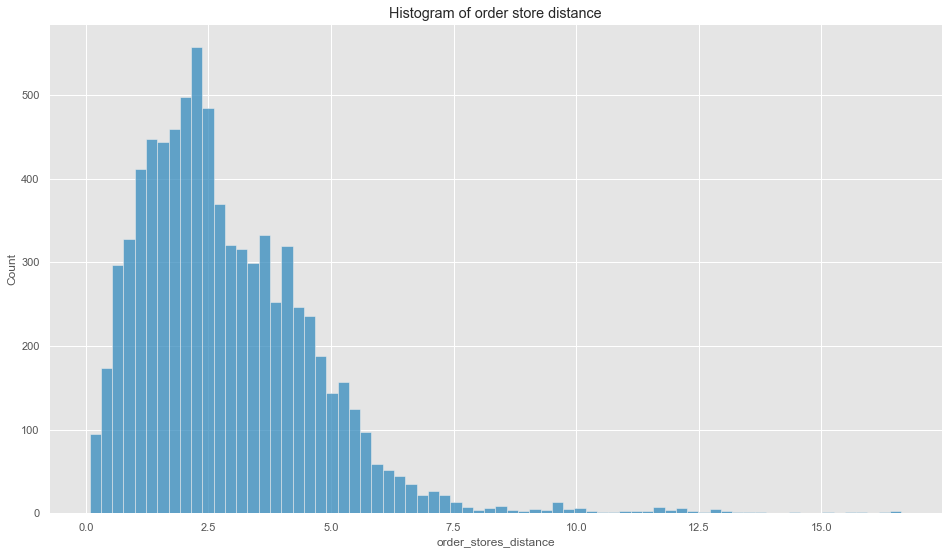

In [46]:
sns.histplot(data=model_data,x="order_stores_distance")
plt.title('Histogram of order store distance')
plt.show();

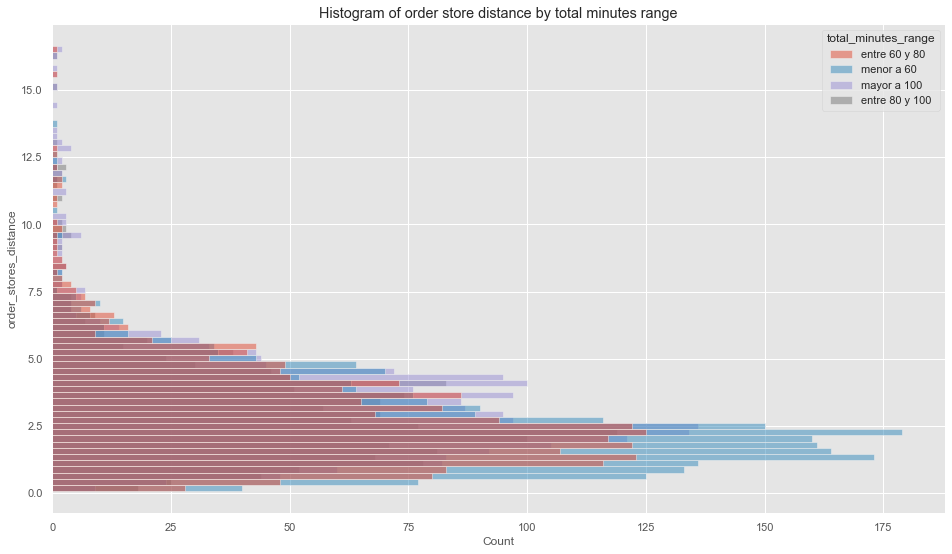

In [47]:
sns.histplot(data=model_data,y="order_stores_distance",hue="total_minutes_range")
plt.title('Histogram of order store distance by total minutes range')
plt.show();

                      count      mean       std       min       25%       50%  \
total_minutes_range                                                             
entre 60 y 80        1994.0  2.847165  1.830415  0.076566  1.499135  2.445005   
entre 80 y 100       1503.0  3.005694  1.850266  0.096322  1.722679  2.681910   
mayor a 100          2019.0  3.215323  1.979520  0.081133  1.921805  2.891738   
menor a 60           2484.0  2.574810  1.630224  0.077871  1.362334  2.244533   

                          75%        max  
total_minutes_range                       
entre 60 y 80        3.874442  16.498146  
entre 80 y 100       4.031319  16.388548  
mayor a 100          4.168596  16.631580  
menor a 60           3.501539  13.799989  


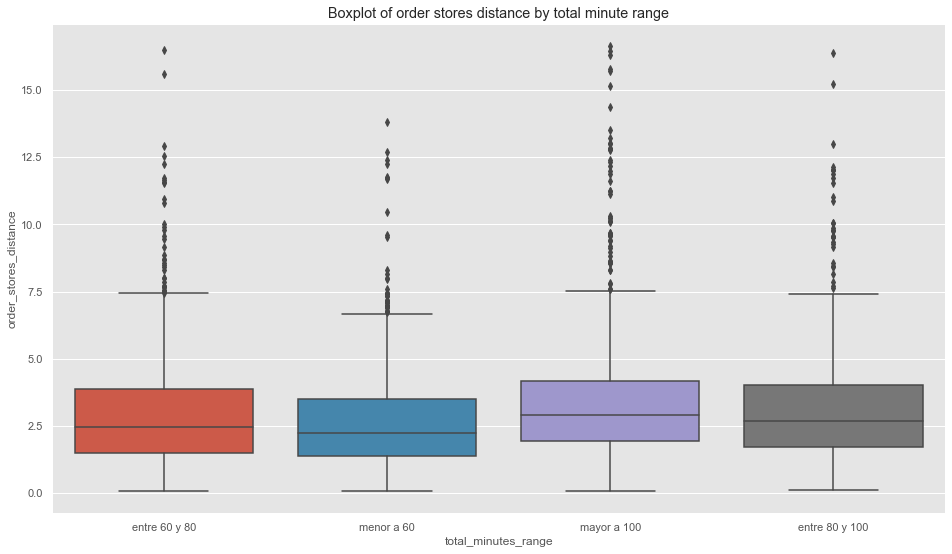

In [48]:
print(model_data.groupby('total_minutes_range')['order_stores_distance'].describe())
sns.boxplot(x="total_minutes_range", y='order_stores_distance',data=model_data)
plt.title('Boxplot of order stores distance by total minute range');

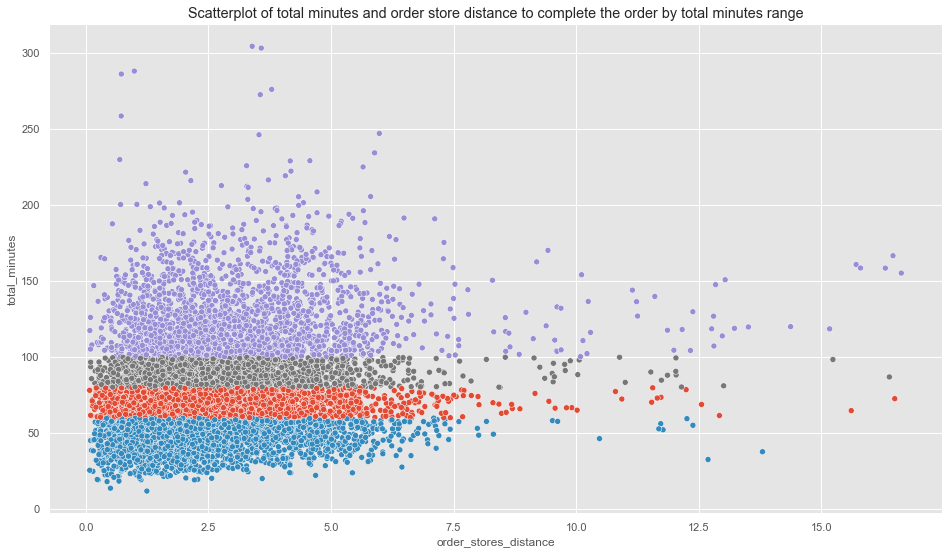

In [49]:
sns.scatterplot(data=model_data, y="total_minutes", x="order_stores_distance",hue='total_minutes_range',legend=False)
plt.title('Scatterplot of total minutes and order store distance to complete the order by total minutes range')
plt.show();

In [50]:
model_data[['total_minutes','order_stores_distance']].corr()

total_minutes  order_stores_distance
total_minutes               1.000000               0.140226
order_stores_distance       0.140226               1.000000

#### **Conclusion**

* Is there a relationship between the time in minutes to complete an order and the distance between the store and the place of delivery?

Indeed, on average and in all percentiles, the distance between the store and the place of delivery is slightly higher as the time ranges to complete the order are longer.

* Is the effect of the location of the store on the time in minutes to complete an order conditioned by the distance between the place where the order should be left and the place of the store or are they independent?

We will not answer this question now, as we will not use hypothesis tests but rather a variable selection method to choose the variables to use.


--------------------------------------------------------------------------------------------------------------------------------------------------------------

### Orders and products

* What is the magnitude of the number of products per order?


* How varied is the product mix per order? Is there X% of products that have a significantly higher requested frequency?


* Of the products that you request the most, what is the range that you request of them in quantity?

#### Evidence

In [51]:
# Loading Order Products dataset
order_products = pd.read_csv('interim/order_products.csv', sep=';')
print(order_products.shape)
get_na(order_products)

(198500, 5)


datos sin NAs en q  Na en q  Na en %
order_id                   198500        0      0.0
product_id                 198500        0      0.0
quantity                   198500        0      0.0
buy_unit                   198500        0      0.0
quantity_unit              198500        0      0.0

In [52]:
# con esto calculo la cantidad de órdenes que tengo y cuántos productos me piden por orden
aux = order_products.groupby(['order_id'])['quantity'].sum().reset_index()
print(aux.shape)
aux.head(3)

(9978, 2)


order_id  quantity
0  0004a3841c1eeb6c6e77585a941c21e0       8.0
1  0005a6ecbbde1e8d273f5577bcff2c9c       2.0
2  0007baeb6700fc203be2d1f1e11222d7      39.0

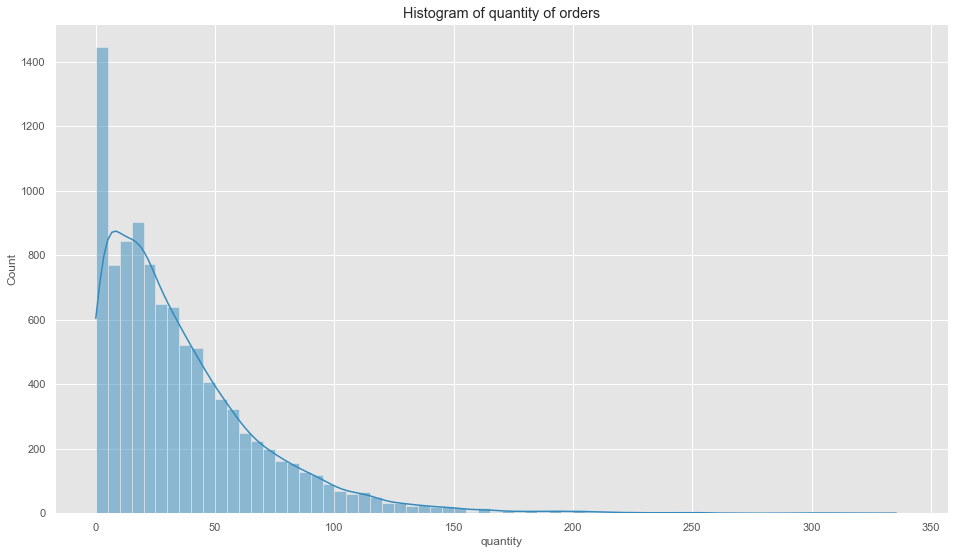

In [53]:
sns.histplot(data=aux, x="quantity", kde=True, binwidth=5)
plt.title('Histogram of quantity of orders');

count    9978.000000
mean       36.288735
std        34.250712
min         0.100000
25%        12.000000
50%        27.155500
75%        50.430000
max       335.400000
Name: quantity, dtype: float64


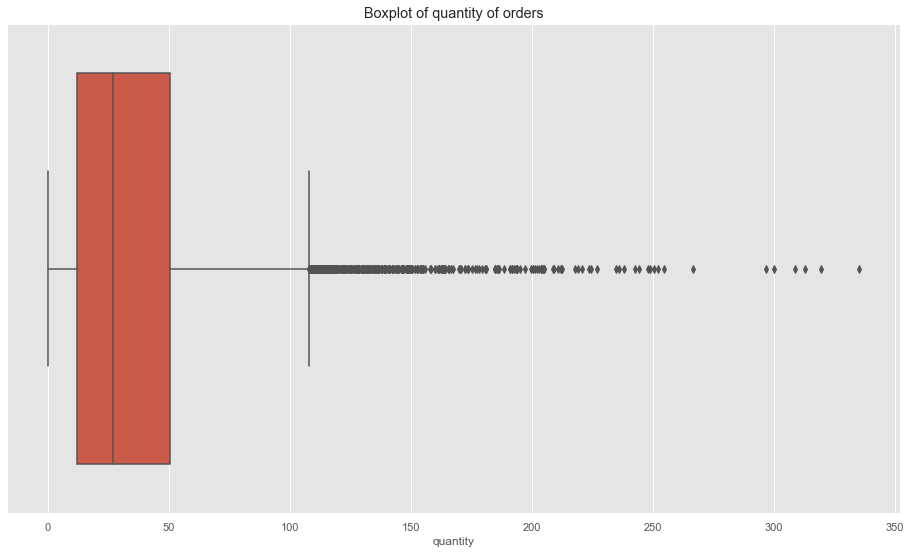

In [54]:
print(aux.quantity.describe())
ax = sns.boxplot(x = aux["quantity"])
plt.title('Boxplot of quantity of orders');

In [55]:
# calculo el percentil de las órdenes que superan los 100 productos
print(np.percentile(aux.quantity, 90))

80.46180000000005


We can see that of the 9978 orders we have:

1.- 25% have less than 12 products

2.- 50% of the orders have between 12 and 50 products, only 25% exceed that amount.

3.- 10% of orders with more products have 80 products or more

This information is relevant when making decisions, especially if we find a relationship between the number of products and the time to complete the order, which is something we hope will happen.

In [56]:
aux = get_measure_central_tendency(order_products,"order_id","product_id",'quantity')
print(aux.shape)
aux.sort_values(by='mean').tail(3)

(15422, 8)


product_id   mean        std  median  quantity  \
3153   62735c8e567b135f6f84c42c63863ce1  25.00        NaN    25.0         1   
11592  8121b637b3f3ed302535a1dd55ad6db8  38.25  26.633759    29.5         8   
5931   fb4eee191abcd0f4719f45800d0bd8b2  60.00        NaN    60.0         1   

       coef_var_pearson  cumsum_quantity  cumsum_quantity_pp  
3153                NaN             3154            0.015889  
11592          0.696307            26480            0.133401  
5931                NaN             5932            0.029884

In [57]:
# acá vemos que en 5983 de los 15422 productos(39%) el promedio no es representativo, es por ello que usaremos la mediana como métrica
print(sum(aux.coef_var_pearson>0.3))
100 * sum(aux.coef_var_pearson>0.3) / aux.shape[0]

5983


38.79522759693944

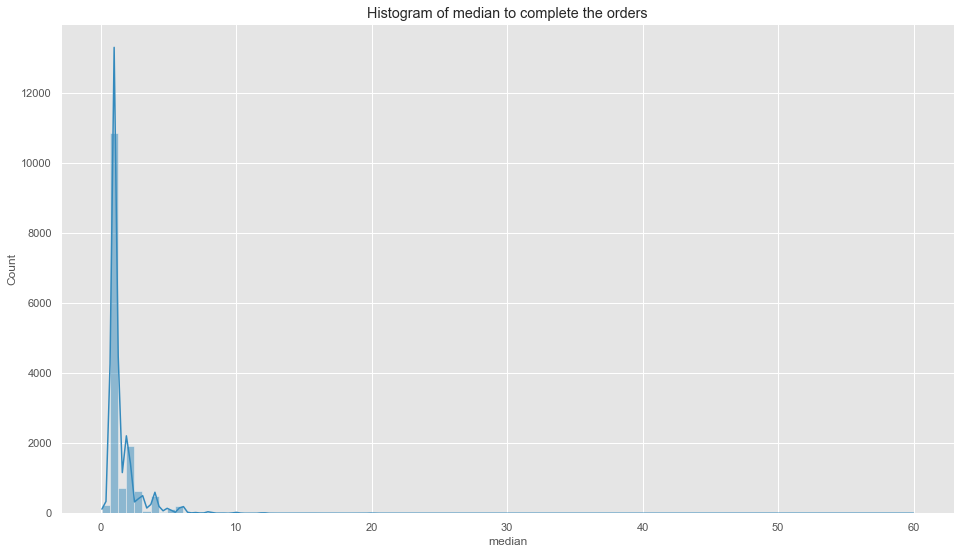

In [58]:
sns.histplot(data=aux, x="median", kde=True, bins=100);
plt.title('Histogram of median to complete the orders');

count    15422.000000
mean         1.503826
std          1.343087
min          0.100000
25%          1.000000
50%          1.000000
75%          1.500000
max         60.000000
Name: median, dtype: float64


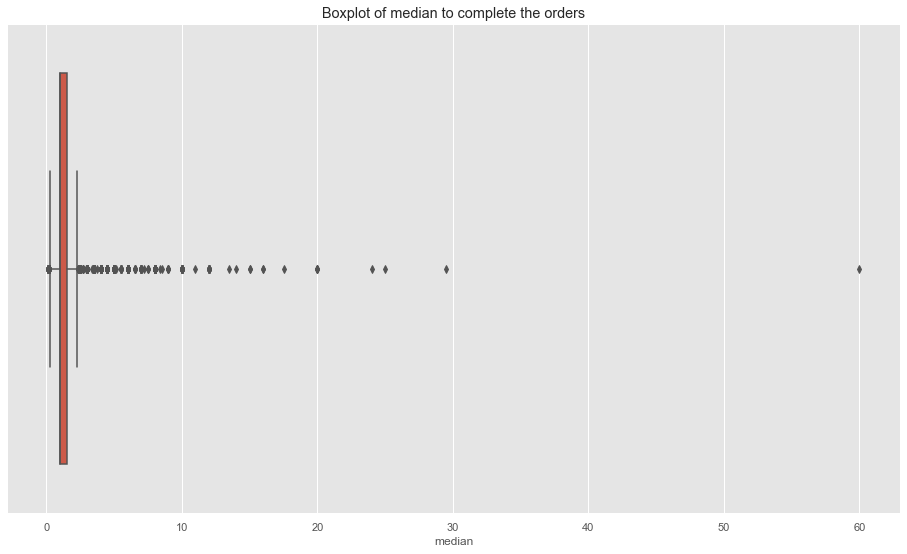

In [59]:
print(aux['median'].describe())
ax = sns.boxplot(x = aux["median"])
plt.title('Boxplot of median to complete the orders');

count    15422.000000
mean        12.871223
std         49.588740
min          1.000000
25%          1.000000
50%          2.000000
75%          8.000000
max       2073.000000
Name: quantity, dtype: float64


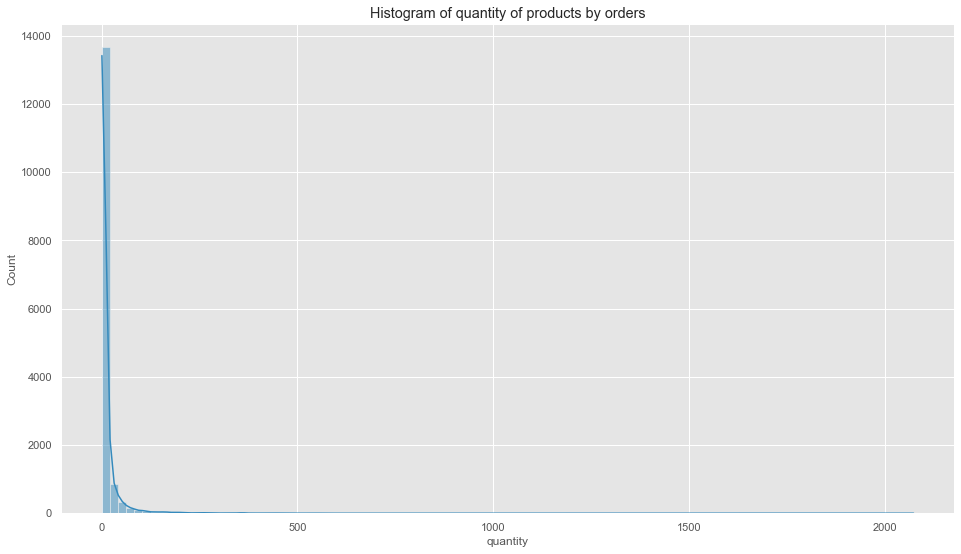

In [60]:
print(aux.quantity.describe())
sns.histplot(data=aux, x="quantity", kde=True, bins=100)
plt.title('Histogram of quantity of products by orders');

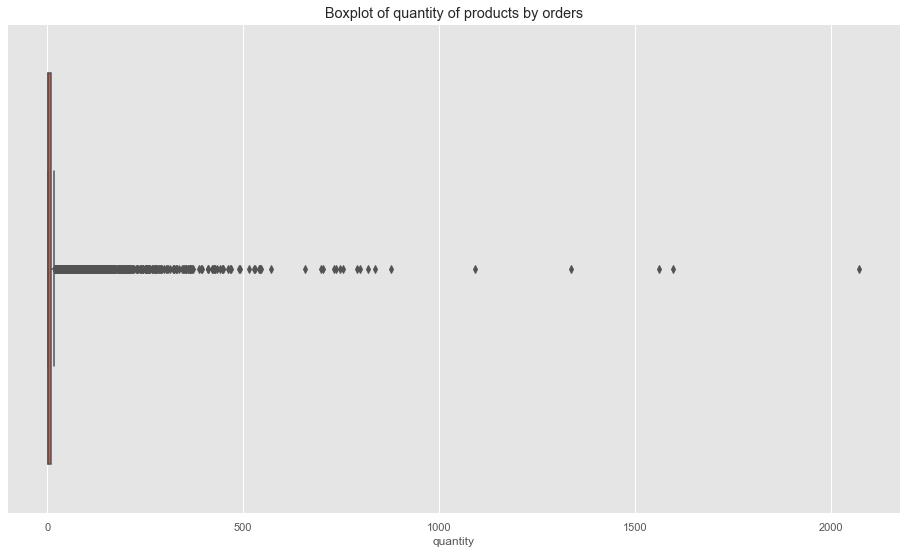

In [61]:
ax = sns.boxplot(x = aux["quantity"])
plt.title('Boxplot of quantity of products by orders');

In [62]:
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,90))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,97.8))

25.0
99.0


In the 15422 products we can see that:

1.- 52% have been requested only 2 times or less (0.02% of total orders)

2.- 90% has been requested 25 times or less (0.25% of total orders)

3.- 2.2% of the products is the one that has been requested more than 99 times (that is, more than 1% of the orders)

This poses an important complexity since the variability of the products is extremely high and it probably does not help us much to include it as a variable unless we can make groupings by categories and / or families, which cannot be done this time since we do not have the dictionary with descriptions.

Initially, we will leave this variable as a strong candidate to be eliminated as it is very likely that it introduces more noise than predictive capacity.

In [63]:
aux = get_get_measure_central_tendency_2(order_products,'order_id','product_id','buy_unit','quantity')
print(aux.shape)
aux.head(3)

(15422, 7)


product_id buy_unit      mean       std  median  \
15032  f90b55ea82b8af664f1d7eebb93f25e0       KG  1.021659  0.455174   1.002   
11354  bdcc4590896a0d0b419d0388fd16a859       KG  1.181686  0.591633   1.180   
3932   41da609c519d77b29be442f8c1105647       KG  1.026364  0.544188   1.000   

       quantity  coef_var_pearson  
15032      2073          0.445524  
11354      1598          0.500669  
3932       1562          0.530210

            count       mean         std  min  25%  50%   75%     max
buy_unit                                                             
KG          581.0  30.716007  146.859904  1.0  1.0  3.0  10.0  2073.0
UN        14841.0  12.172630   41.223953  1.0  1.0  2.0   8.0  1336.0


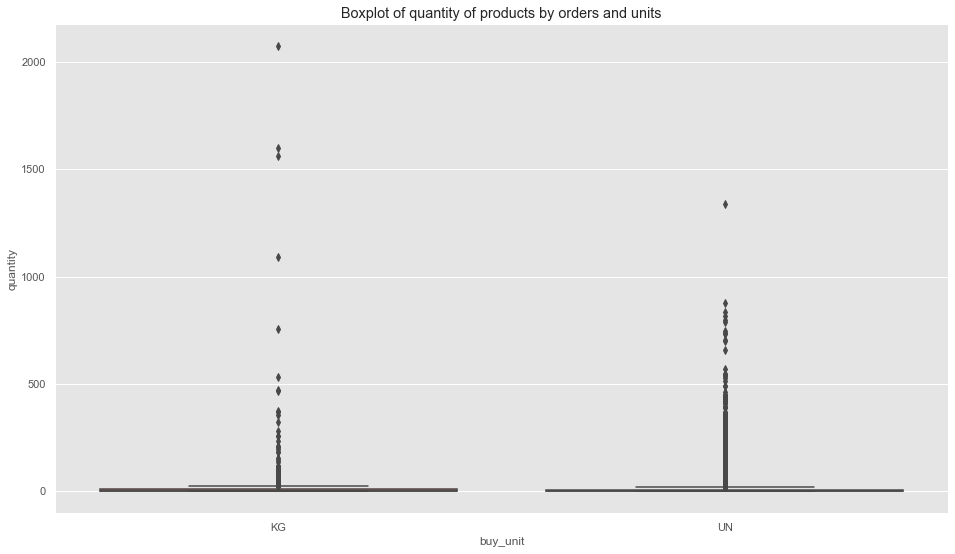

In [64]:
print(aux.groupby('buy_unit')['quantity'].describe())
sns.boxplot(x="buy_unit", y="quantity",data=aux)
plt.title('Boxplot of quantity of products by orders and units');

              count       mean        std        min        25%        50%  \
is_weighted                                                                  
0            2956.0  68.042905  31.234995  11.969489  45.630429  61.333428   
1            5044.0  88.761740  34.378016  19.582987  63.382035  82.785688   

                    75%         max  
is_weighted                          
0             82.761496  287.907109  
1            108.543026  304.190303  


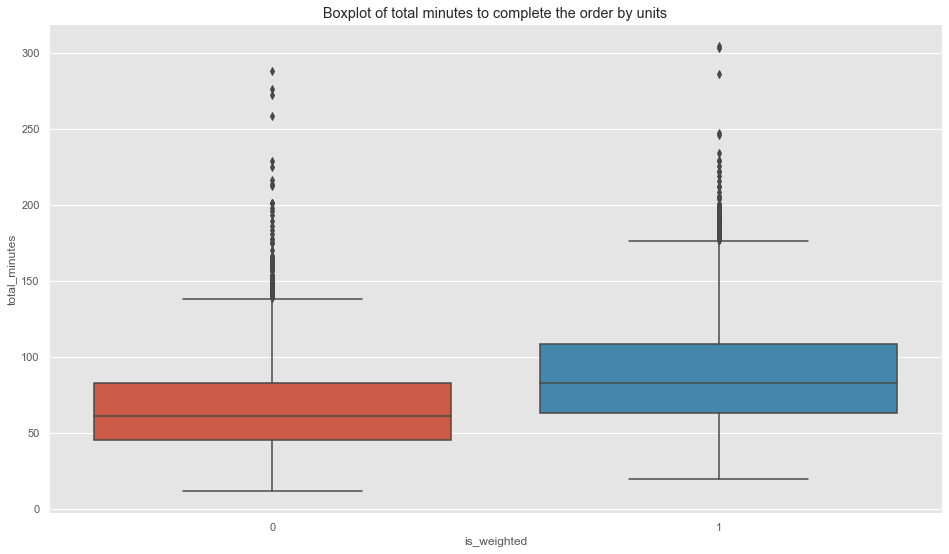

In [65]:
print(model_data.groupby('is_weighted')['total_minutes'].describe())
sns.boxplot(x="is_weighted", y="total_minutes",data=model_data)
plt.title('Boxplot of total minutes to complete the order by units');

When separating by the products that are measured in units and kgs we can conclude that:

1.- For 50% of the products ordered, the quantity requested per product ranges between 1 and 2 units or when it must be weighed between 1kg to 3kg

2.- It is important to note that the amount of products measured in kgs is only 3.7% of what is requested

3.- When the product must be weighed (in Kgs), it significantly increases the total delivery time of the order

#### Answering our initial questions

**1.- What is the magnitude of the number of products per order?**

The vast majority (75%) have less than 50 products per order and only 10% of orders have 80 or more products

**2.- How varied is the product mix per order? Is there X% of products that have a significantly higher requested frequency?**

and varied, only 2.2% of the products have been requested in more than 1% of the orders. On the other hand, only 3.7% of the products ordered are measured in kgs, while the rest in units. On average, for 75% of the products ordered, the amount ordered per product varies between 1 and 8 units or 1 a 10kg.

**3.- Of the products that you order the most, what is the range of the quantity that you request of them?**

This becomes irrelevant since there are very few products that are frequently requested and will have a very limited impact on my ability to predict.

**4.- Are there any characteristics of the products that impact in any way the delivery time of the orders?**

When the product must be weighed (in Kgs), it significantly increases the total delivery time of the order

--------------------------------------------------------------------------------------------------------------------------------------------------------------

## Orders

**Regarding the orders, the research questions are**

* Where do the orders come from?

* How long does it normally take for an order to arrive?

* How long does it normally take for an order to arrive depending on whether it was promised for term X or not? Are there variations between the two categories?

* The time it takes for an order to arrive, does it vary by commune?

* Are there communes assigned to the data to be predicted for which we do not have historical records?

* The time it takes for an order to arrive, does it vary by shoper?

* Are there shoppers assigned to the data to be predicted for which we do not have historical records of their performance?

* The time it takes for an order to arrive, does it vary by store?

* Are there stores assigned in the data to be predicted for which we do not have previous historical records?

**About the time to complete the order**

* How long does it normally take for an order to arrive?

#### Conclusions with evidence

**Since this time the reasearch questions are so much, i will present the answer to the questions first and then the evidence to sustain it**

##### Analysis of time to complete the orders and where they came from

* **Where do the orders come from?**

58% of the orders comes from 3 districts: Las Condes, Lo Barnechea y Vitacura

* **How long does it normally take for an order to arrive?**

Only 31% of orders take less than 1 hour (60 minutes), while 66% of orders take less than 90 minutes and 86% of orders take less than 120 minutes. It is important to note that there are 5% of orders that take more than 150 minutes (2.5 hours) and that they are the outiers that we see in the boxplot shown in the evidence.

In [66]:
get_measure_central_tendency(model_data,'order_id','order_district', 'total_minutes').sort_values(by='quantity', ascending=False)

order_district        mean        std      median  quantity  \
44             Las Condes   79.611136  32.592274   74.487733      2422   
43           Lo Barnechea   67.448126  27.382633   61.697857      1205   
42               Vitacura   76.589368  31.715969   71.894963      1059   
41                 Colina   69.861872  30.539093   62.932035       668   
40            Providencia   99.830387  38.074840   96.597749       543   
39                  Ñuñoa  102.445292  40.065498   95.346060       372   
38               La Reina   83.151884  34.317314   78.103742       287   
37           Viña del Mar   83.622533  29.296762   78.855557       227   
36               Santiago  122.205601  44.431494  117.129821       150   
35  Provincia de Santiago   75.631009  36.269254   65.704870       131   
34             La Florida   78.883534  28.551818   74.409263       122   
33             Huechuraba   95.499659  33.353902   90.396254        99   
32              Peñalolén   98.468713  35.981871   91.138443        83   
31             Concepción   84.211771  29.417134   77.331272        72   
30                 Concón   63.348998  24.006552   57.836751        72   
29             San Miguel  116.217258  44.032201  105.120919        55   
28    San Pedro de la Paz   82.029726  30.130456   74.323494        51   
27                  Maipú   81.818813  29.876780   75.303431        48   
26                  Macul   94.431022  36.074240   86.333807        47   
25            Puente Alto   75.803241  25.553337   69.426641        45   
24             Valparaíso  101.429921  30.126337   91.173145        29   
23            Chiguayante   89.178984  29.295465   84.050774        27   
22              La Serena   90.495547  22.633219   94.948555        24   
20       Estación Central   93.194290  26.889889   89.242240        22   
21               Coquimbo   83.890852  38.489725   77.433328        22   
19               Recoleta  121.952605  37.349438  116.416633        17   
18              Quilicura   95.434730  32.922227   83.026454        13   
17               Pudahuel  104.020024  35.470288  109.105013        12   
16            La Cisterna   92.485233  16.432839   92.087769        12   
15               Conchalí   79.647394  33.568815   76.359676        11   
13             Talcahuano   84.785147  30.228752   81.145463         9   
14            San Joaquín   98.979999  29.890619   91.197027         9   
12          Independencia  123.078721  44.828388  102.406556         7   
11          Quinta Normal  134.105305   9.096686  133.258068         5   
10                  Renca   97.346618  16.908404   98.189716         4   
9               Cerrillos   85.553294  27.513441   79.820989         4   
8            San Bernardo  110.347498  25.670113  105.490547         4   
7               La Granja   85.161065   3.309012   85.161065         2   
6              La Pintana   76.024210   6.028761   76.024210         2   
5                 Hualpén   75.078682  44.846663   75.078682         2   
3               Lo Espejo  114.268386        NaN  114.268386         1   
2               El Bosque   83.259952        NaN   83.259952         1   
1                Lo Prado   79.468371        NaN   79.468371         1   
4             Cerro Navia  104.417708        NaN  104.417708         1   
0         Calera de Tango  171.351435        NaN  171.351435         1   

    coef_var_pearson  cumsum_quantity  cumsum_quantity_pp  
44          0.409393             8000            1.000000  
43          0.405981             5578            0.697250  
42          0.414104             4373            0.546625  
41          0.437135             3314            0.414250  
40          0.381395             2646            0.330750  
39          0.391092             2103            0.262875  
38          0.412706             1731            0.216375  
37          0.350345             1444            0.180500  
36          0.363580             1217            0.152125  
35    

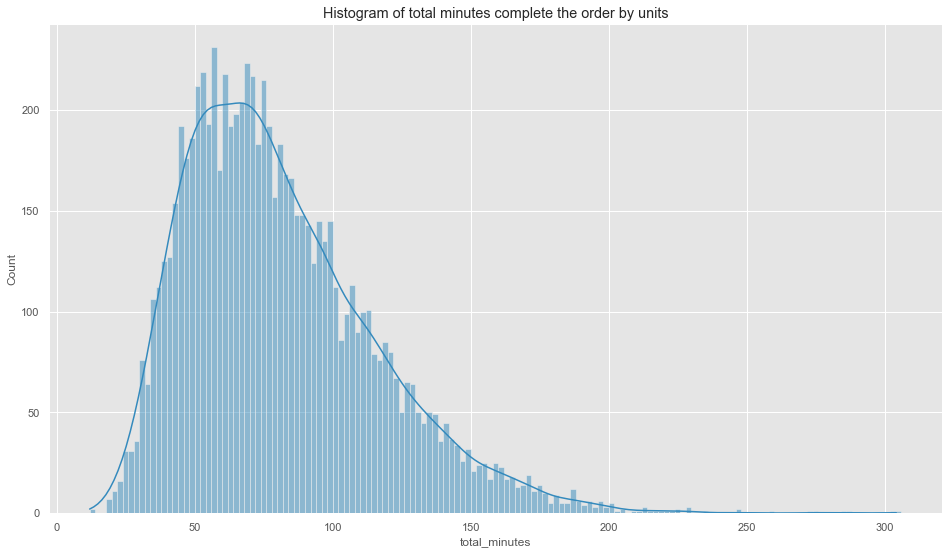

In [67]:
sns.histplot(data= model_data, x="total_minutes", kde=True, binwidth=2)
plt.title('Histogram of total minutes complete the order by units');

count    8000.000000
mean       81.106130
std        34.720837
min        11.969489
25%        55.225480
50%        74.731672
75%       100.273498
max       304.190303
Name: total_minutes, dtype: float64


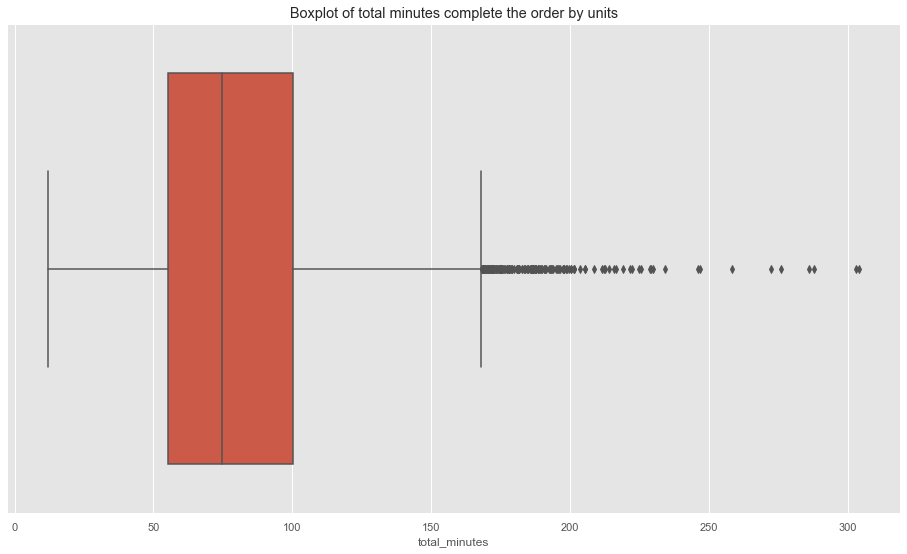

In [68]:
print(model_data.total_minutes.describe())
sns.boxplot(x = model_data["total_minutes"])
plt.title('Boxplot of total minutes complete the order by units');

In [69]:
# calculo el valor asociado al percentil que entrego
print(np.percentile(model_data.total_minutes,31))
# calculo el valor asociado al percentil que entrego
print(np.percentile(model_data.total_minutes,66))
# calculo el valor asociado al percentil que entrego
print(np.percentile(model_data.total_minutes,86.6))
# calculo el valor asociado al percentil que entrego
print(np.percentile(model_data.total_minutes,95))

59.97786293983335
89.77501030233334
120.08993437019976
146.5875067158333


##### By on demand or not

* **How long does it normally take for an order to arrive depending on whether it was on demand or not? Are there variations between the two categories?**

Yes, in average on demand delyver the order in 71 minutes and not on demand in 89 minutes. Also, in 25%, 50%, 75% percentiles on demand orders takes more less time to delyver the order than not on demand orders and the variability of the time is also smaller

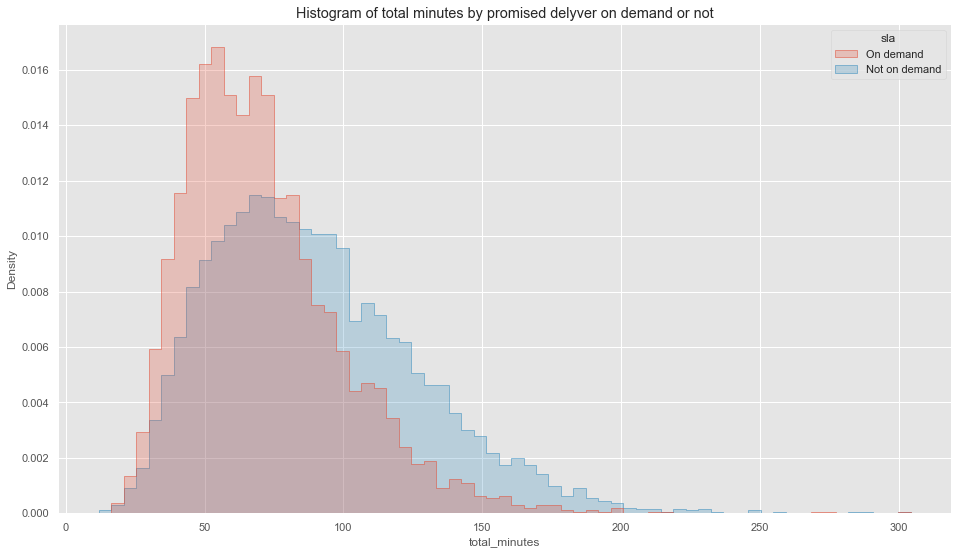

In [70]:
sns.histplot(data=model_data, x="total_minutes", hue="sla",element="step",stat="density", common_norm=False)
plt.title('Histogram of total minutes by promised delyver on demand or not')
plt.show();

In [71]:
model_data.groupby(['sla']).total_minutes.describe()

count       mean        std        min        25%        50%  \
sla                                                                            
Not on demand  4362.0  89.436066  37.077655  11.969489  61.525154  84.340943   
On demand      3638.0  71.118450  28.635052  18.192689  50.628070  66.605007   

                      75%         max  
sla                                    
Not on demand  112.132380  304.190303  
On demand       85.877134  303.029792

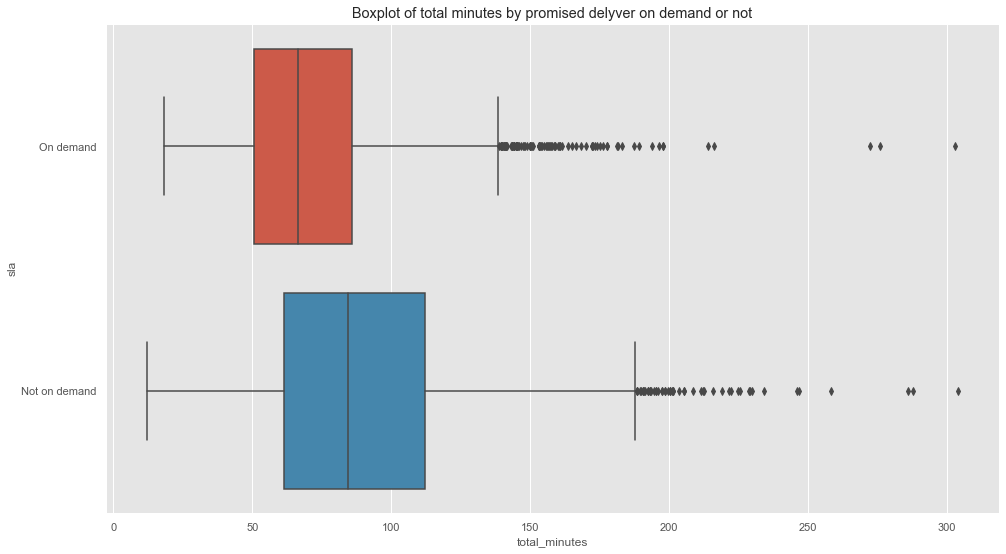

In [72]:
ax = sns.boxplot(x="total_minutes", y="sla", data=model_data)
plt.title('Boxplot of total minutes by promised delyver on demand or not')
plt.show();

##### **Analysis of orders by district**

* **The time it takes for an order to arrive, does it vary by district?**

There are district of which there is very little data to use their information, since they have very little history with orders (only 20 of the 44 district(45%) have more than 30 data) When filtering by these district, we can observe that there are important variations between communes and there are also some communes where the dispersion is significantly greater than the rest (Providencia, Santiago, San Miguel, etc). **It is also necessary to note that the 3 district where the times to complete the order are highest are communes that were strongly affected in traffic by the protests on the days that the sample was collected. Even so, it is not possible to ensure that this is the cause of the variations, since there are communes such as Puente Alto that are among the lowest and also had strong manifestations**

* **Are there district assigned to the data to be predicted for which we do not have historical records?**

Yes, San Ramón.

* **The time it takes for an order to arrive, does it vary by district? Is it a candidate variable to be used as an explanatory / predictive variable?**

At the beginning, we would not be considering the commune variable as an explanatory / predictive variable since we would face the problem of little representation of the history and / or that data without history can directly arrive as it happens in the data of results with San Ramón. **That is why we are going to explore the distance between where the order should arrive and the store as an explanatory variable**

In [73]:
aux = get_measure_central_tendency(model_data,'order_id','order_district','total_minutes')
aux

order_district        mean        std      median  quantity  \
0         Calera de Tango  171.351435        NaN  171.351435         1   
1                Lo Prado   79.468371        NaN   79.468371         1   
2               El Bosque   83.259952        NaN   83.259952         1   
3               Lo Espejo  114.268386        NaN  114.268386         1   
4             Cerro Navia  104.417708        NaN  104.417708         1   
5                 Hualpén   75.078682  44.846663   75.078682         2   
6              La Pintana   76.024210   6.028761   76.024210         2   
7               La Granja   85.161065   3.309012   85.161065         2   
8            San Bernardo  110.347498  25.670113  105.490547         4   
9               Cerrillos   85.553294  27.513441   79.820989         4   
10                  Renca   97.346618  16.908404   98.189716         4   
11          Quinta Normal  134.105305   9.096686  133.258068         5   
12          Independencia  123.078721  44.828388  102.406556         7   
13             Talcahuano   84.785147  30.228752   81.145463         9   
14            San Joaquín   98.979999  29.890619   91.197027         9   
15               Conchalí   79.647394  33.568815   76.359676        11   
16            La Cisterna   92.485233  16.432839   92.087769        12   
17               Pudahuel  104.020024  35.470288  109.105013        12   
18              Quilicura   95.434730  32.922227   83.026454        13   
19               Recoleta  121.952605  37.349438  116.416633        17   
20       Estación Central   93.194290  26.889889   89.242240        22   
21               Coquimbo   83.890852  38.489725   77.433328        22   
22              La Serena   90.495547  22.633219   94.948555        24   
23            Chiguayante   89.178984  29.295465   84.050774        27   
24             Valparaíso  101.429921  30.126337   91.173145        29   
25            Puente Alto   75.803241  25.553337   69.426641        45   
26                  Macul   94.431022  36.074240   86.333807        47   
27                  Maipú   81.818813  29.876780   75.303431        48   
28    San Pedro de la Paz   82.029726  30.130456   74.323494        51   
29             San Miguel  116.217258  44.032201  105.120919        55   
30                 Concón   63.348998  24.006552   57.836751        72   
31             Concepción   84.211771  29.417134   77.331272        72   
32              Peñalolén   98.468713  35.981871   91.138443        83   
33             Huechuraba   95.499659  33.353902   90.396254        99   
34             La Florida   78.883534  28.551818   74.409263       122   
35  Provincia de Santiago   75.631009  36.269254   65.704870       131   
36               Santiago  122.205601  44.431494  117.129821       150   
37           Viña del Mar   83.622533  29.296762   78.855557       227   
38               La Reina   83.151884  34.317314   78.103742       287   
39                  Ñuñoa  102.445292  40.065498   95.346060       372   
40            Providencia   99.830387  38.074840   96.597749       543   
41                 Colina   69.861872  30.539093   62.932035       668   
42               Vitacura   76.589368  31.715969   71.894963      1059   
43           Lo Barnechea   67.448126  27.382633   61.697857      1205   
44             Las Condes   79.611136  32.592274   74.487733      2422   

    coef_var_pearson  cumsum_quantity  cumsum_quantity_pp  
0                NaN                1            0.000125  
1                NaN                2            0.000250  
2                NaN                3            0.000375  
3                NaN                4            0.000500  
4                NaN                5            0.000625  
5           0.597329                7            0.000875  
6           0.079301                9            0.001125  
7           0.038856               11            0.001375  
8           0.232630               15            0.001875  
9     

In [74]:
# Here we see that in 31 of the 45 communes (69%) the average is not representative, that is why we will use the median as a metric
print(sum(aux.coef_var_pearson>0.3))
100 * sum(aux.coef_var_pearson>0.3) / aux.shape[0]

31


68.88888888888889

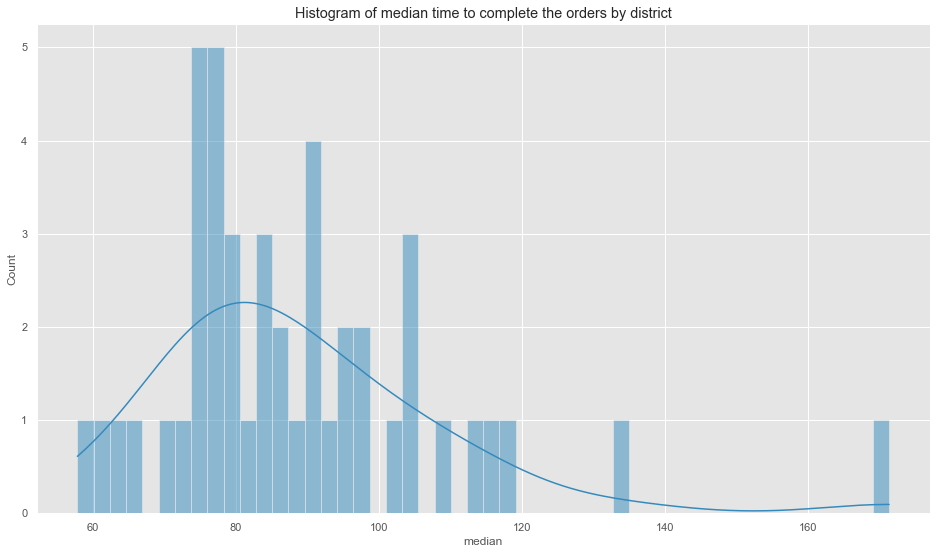

In [75]:
sns.histplot(data=aux, x="median", kde=True, bins=50)
plt.title('Histogram of median time to complete the orders by district')
plt.show();

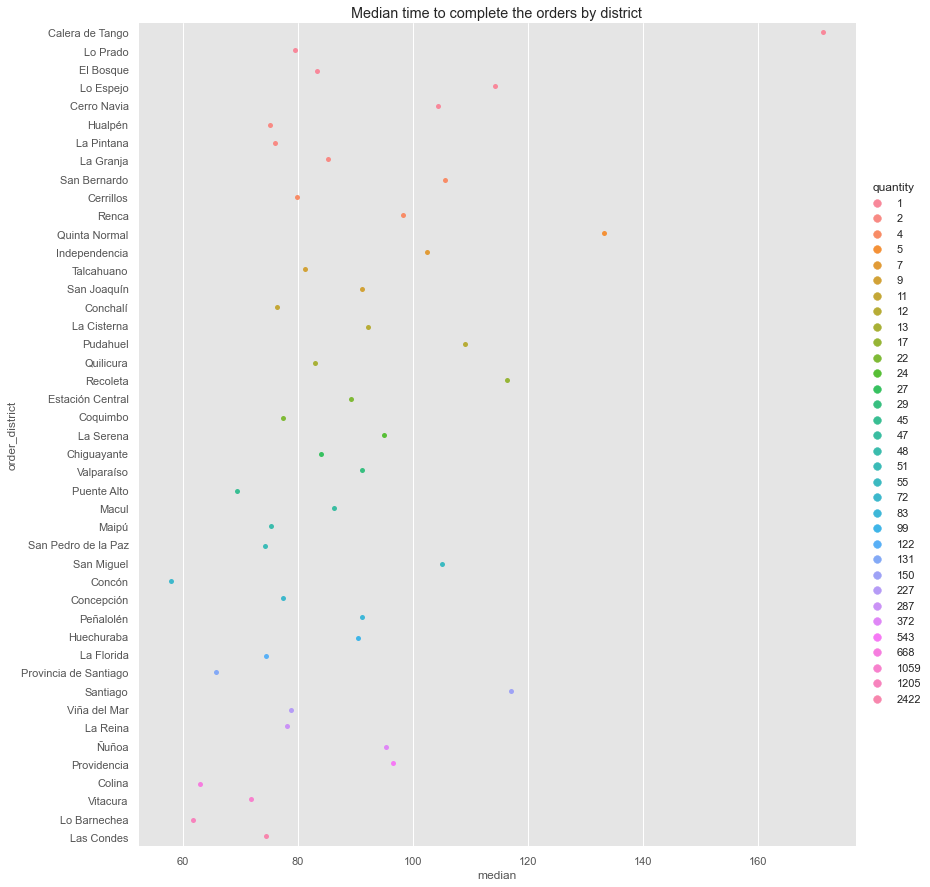

In [76]:
sns.catplot(x="median", y="order_district",orient="h", hue='quantity', data=aux,aspect=1,height=12)
plt.title('Median time to complete the orders by district')
plt.show();

count     45.000000
mean      88.861165
std       20.407412
min       57.836751
25%       76.024210
50%       84.050774
75%       96.597749
max      171.351435
Name: median, dtype: float64


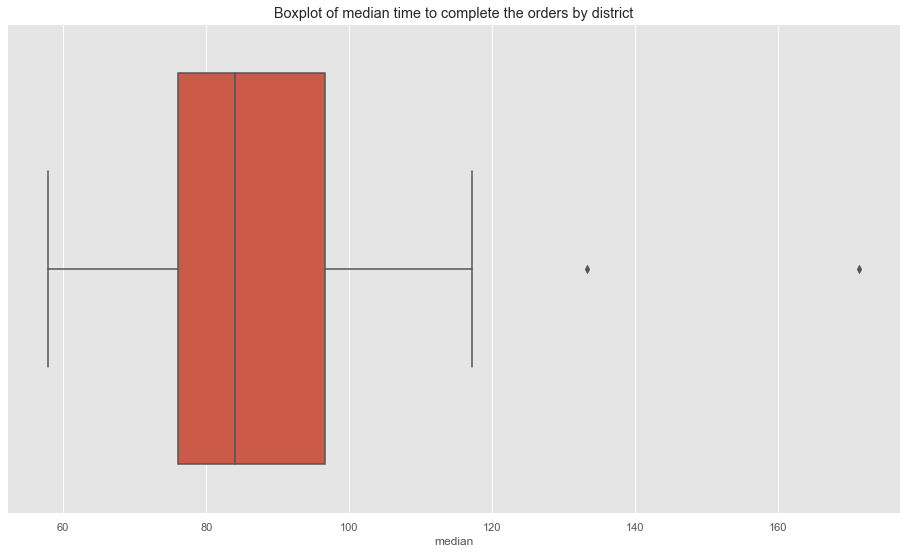

In [77]:
print(aux['median'].describe())
ax = sns.boxplot(x = aux["median"])
plt.title('Boxplot of median time to complete the orders by district')
plt.show();

count     30.000000
mean      83.940475
std       15.259716
min       57.836751
25%       74.428880
50%       80.941005
75%       91.859113
max      117.129821
Name: median, dtype: float64


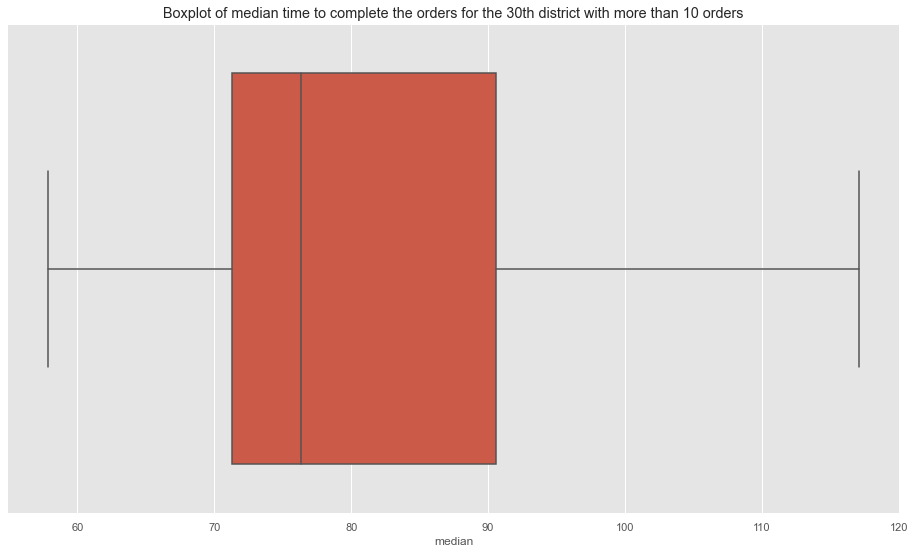

In [78]:
print(aux[aux.quantity>=10]['median'].describe())
ax = sns.boxplot(x = aux[aux.quantity>=30]["median"])
plt.title('Boxplot of median time to complete the orders for the 30th district with more than 10 orders')
plt.show();

In [79]:
set(results.order_district).difference(set(model_data.order_district))

{'San Ramón'}

In [80]:
set(model_data.order_district).difference(set(results.order_district))

{'Cerrillos',
 'Cerro Navia',
 'Hualpén',
 'La Granja',
 'La Pintana',
 'Lo Espejo',
 'Renca',
 'Talcahuano'}

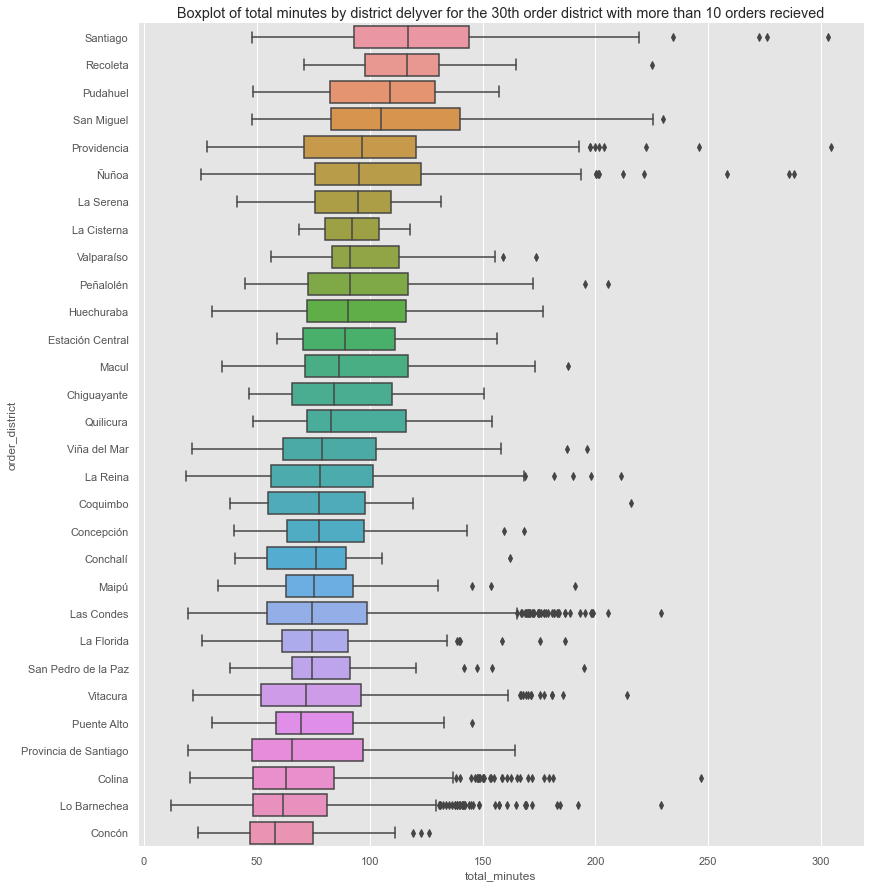

In [81]:
district_size_rep = list(aux[aux.quantity>=10].order_district)
aux2 = model_data.loc[model_data.order_district.apply(lambda x: True if x in district_size_rep else False)]
sns.catplot(x="total_minutes", y="order_district",data=aux2,
            height=12,kind="box",order=list(aux[aux.quantity>=10].sort_values(by='median', ascending=False).order_district))
plt.title('Boxplot of total minutes by district delyver for the 30th order district with more than 10 orders recieved')
plt.show();

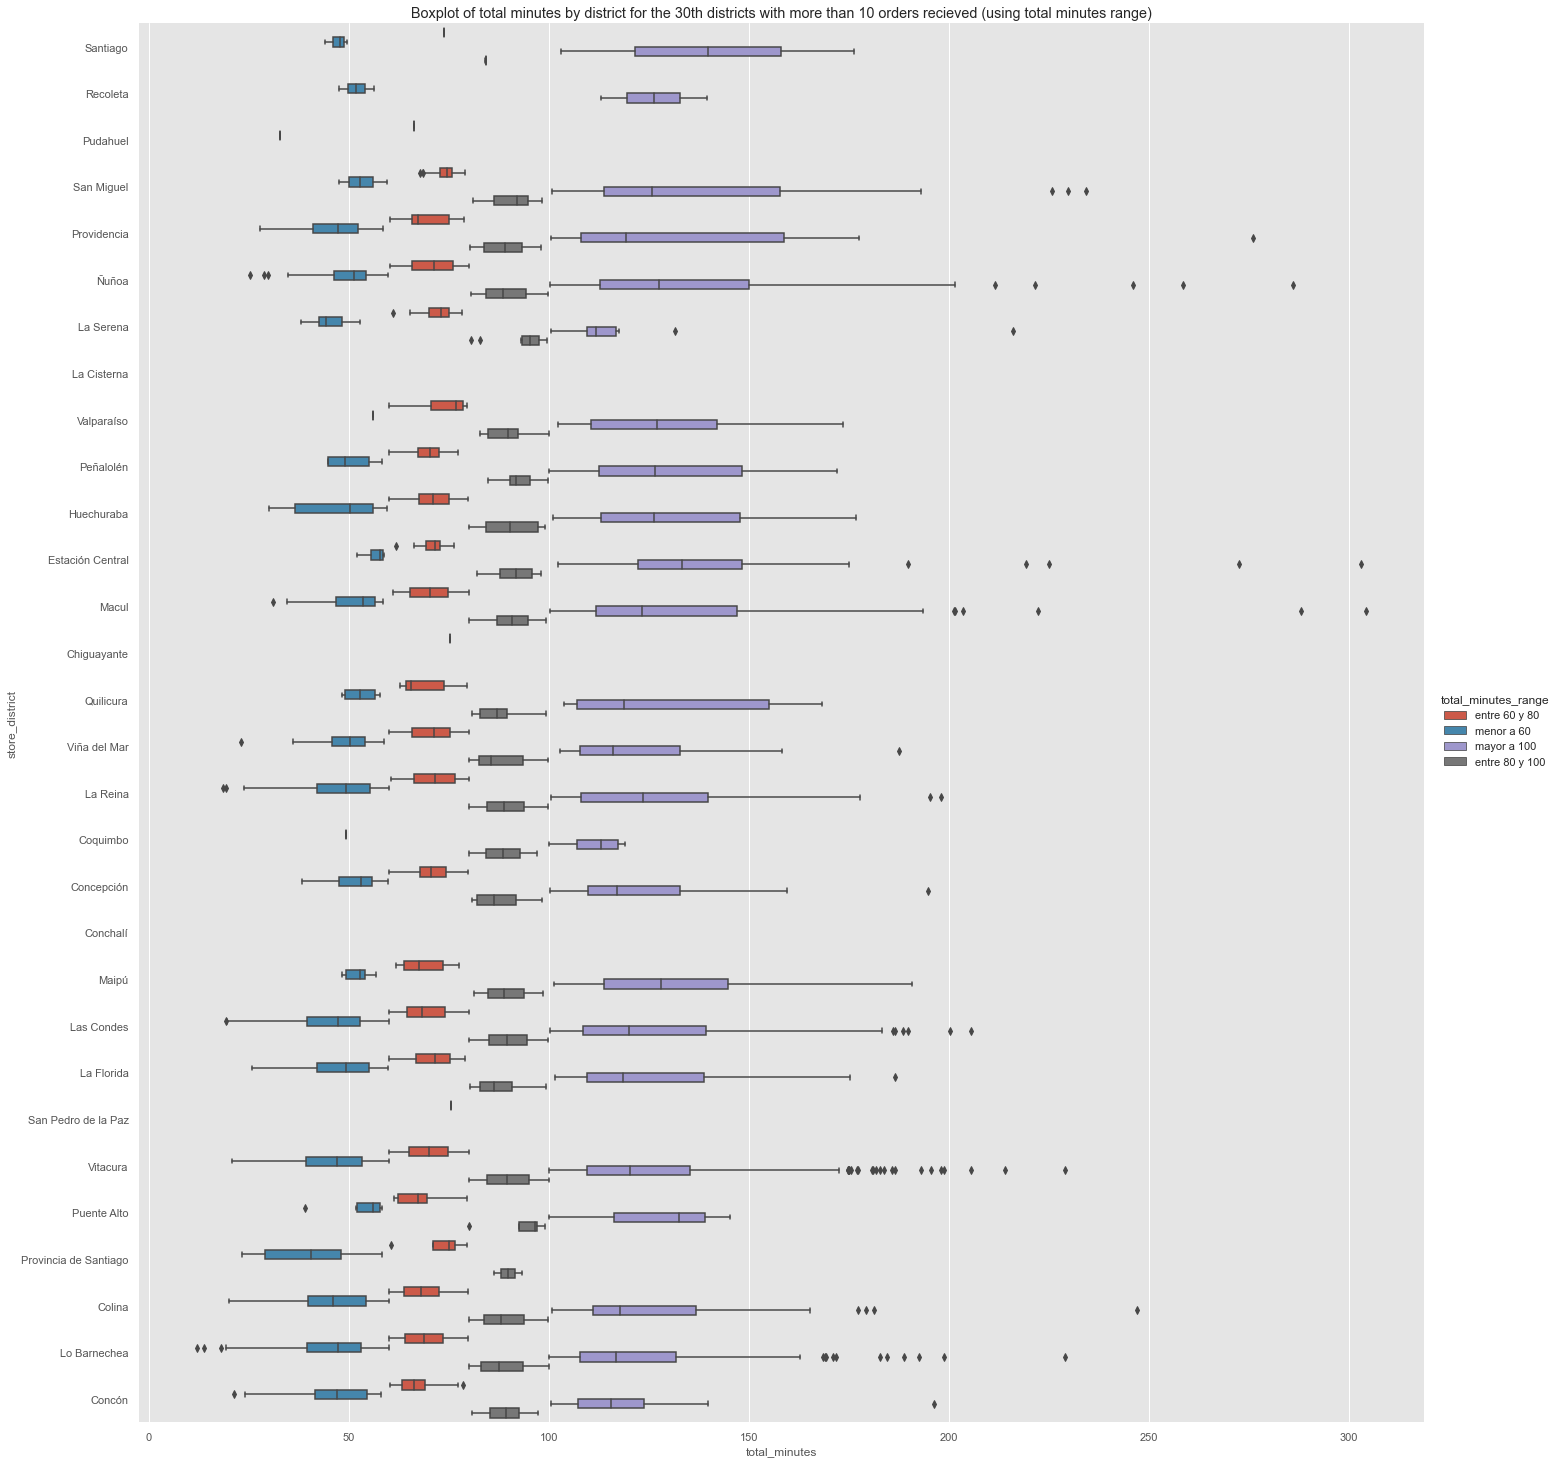

In [82]:
district_size_rep = list(aux[aux.quantity>=10].order_district)
aux2 = model_data.loc[model_data.order_district.apply(lambda x: True if x in district_size_rep else False)]
sns.catplot(x="total_minutes", y="store_district",hue='total_minutes_range',data=aux2,
            height=20,kind="box",order=list(aux[aux.quantity>=10].sort_values(by='median', ascending=False).order_district))
plt.title('Boxplot of total minutes by district for the 30th districts with more than 10 orders recieved (using total minutes range)')
plt.show();

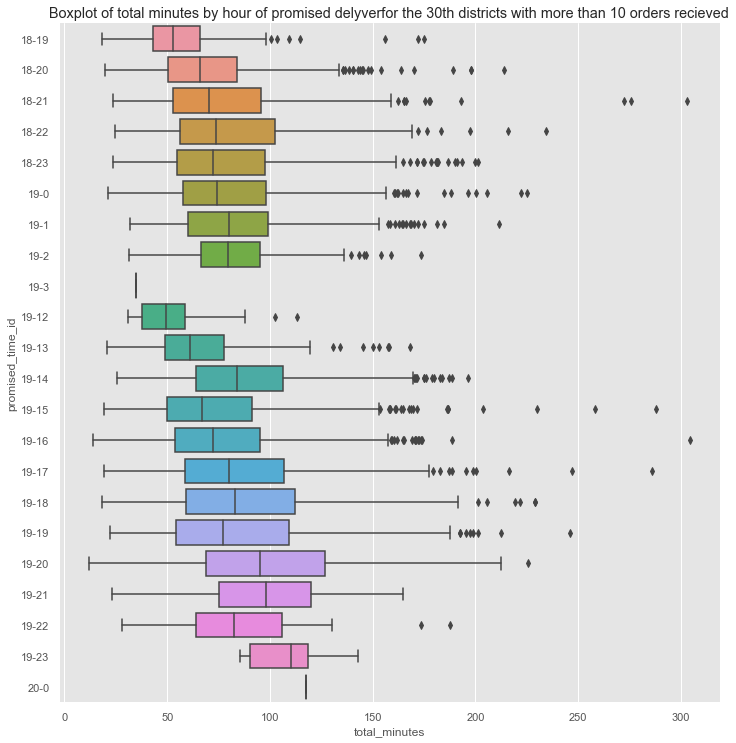

In [83]:
district_size_rep = list(aux[aux.quantity>=10].order_district)
aux2 = model_data.loc[model_data.order_district.apply(lambda x: True if x in district_size_rep else False)]
sns.catplot(x="total_minutes", y="promised_time_id",data=aux2,
            height=10,kind="box", order= aux2.sort_values(by='promised_time').promised_time_id.unique())
plt.title('Boxplot of total minutes by hour of promised delyverfor the 30th districts with more than 10 orders recieved')
plt.show();

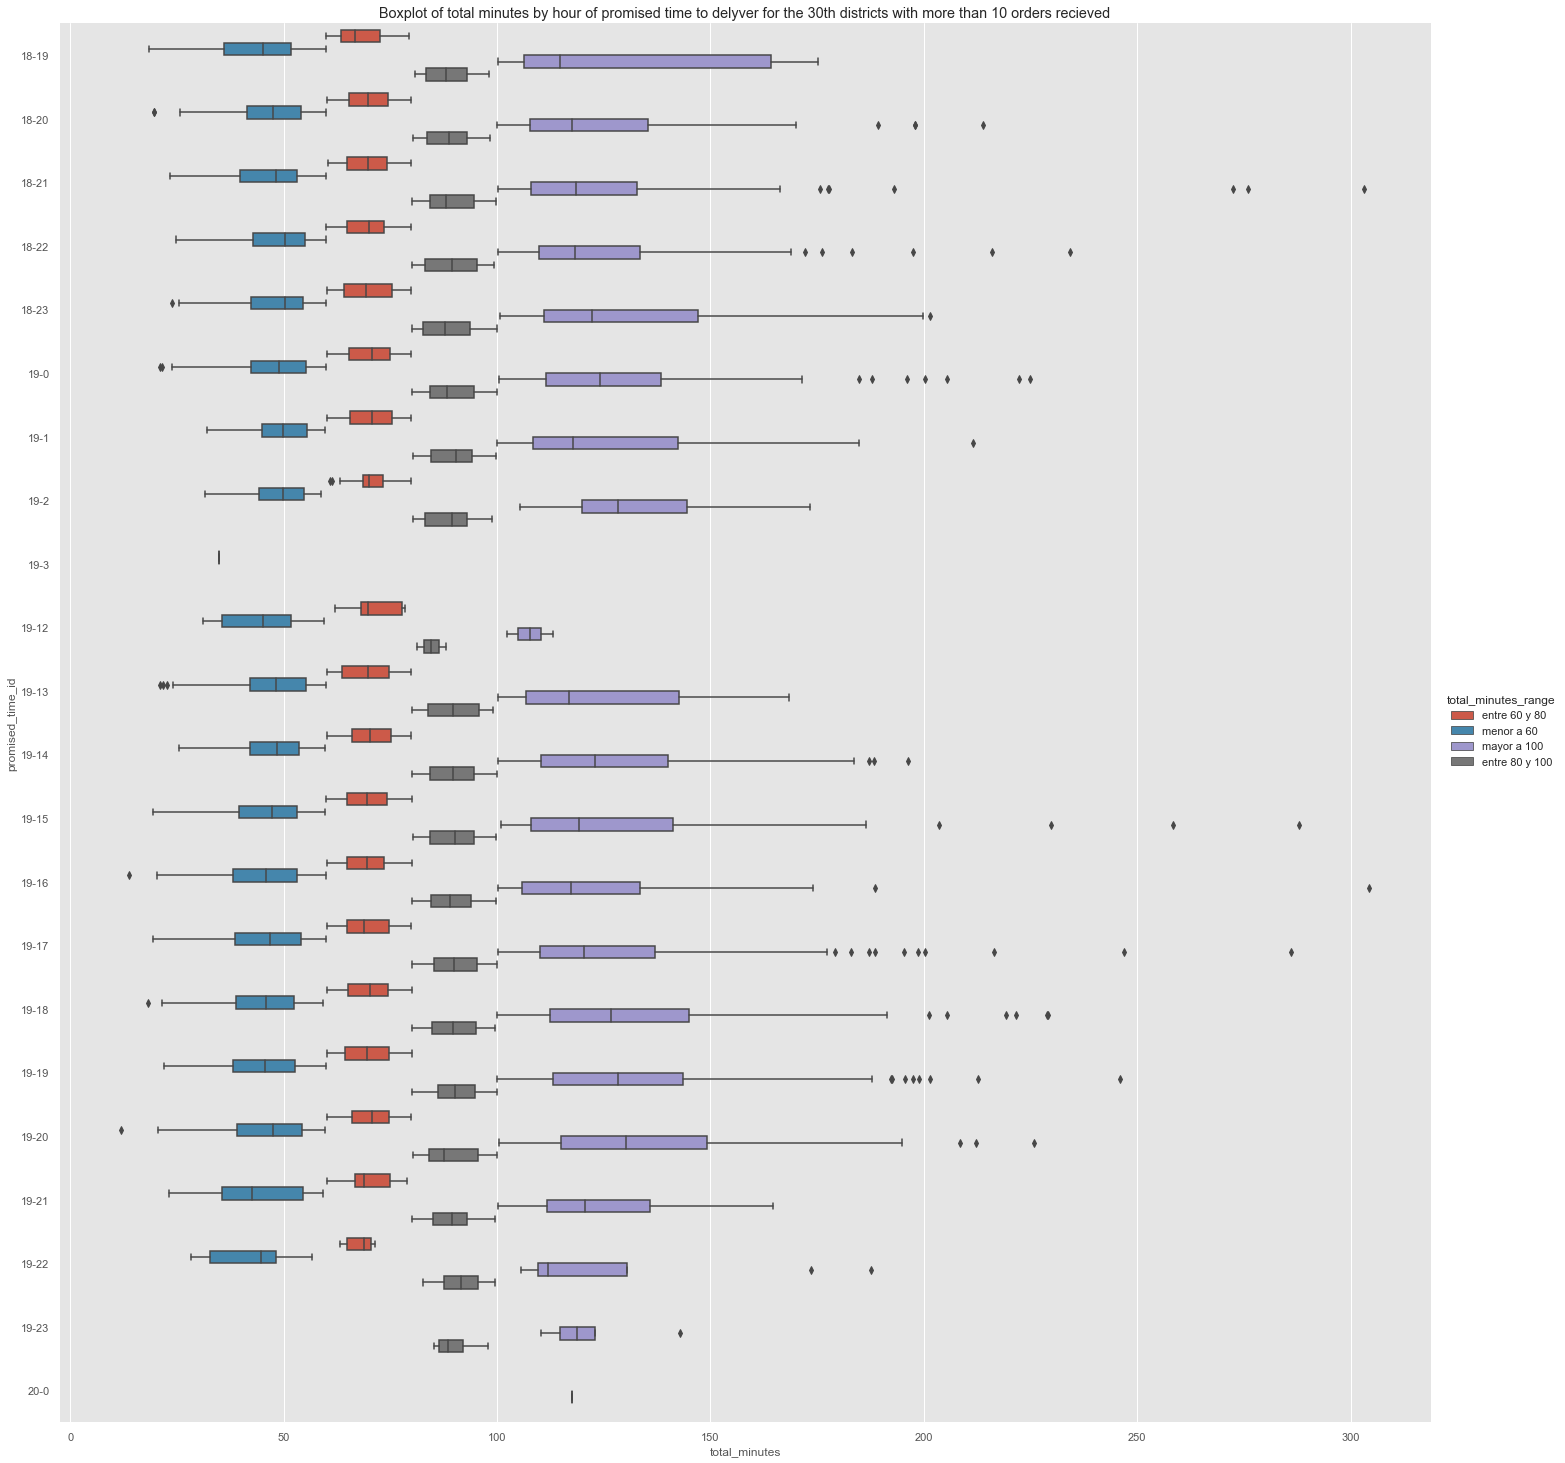

In [84]:
district_size_rep = list(aux[aux.quantity>=10].order_district)
aux2 = model_data.loc[model_data.order_district.apply(lambda x: True if x in district_size_rep else False)]
sns.catplot(x="total_minutes", y="promised_time_id",hue='total_minutes_range',data=aux2,
            height=20,kind="box", order = aux2.sort_values(by='promised_time').promised_time_id.unique())
plt.title('Boxplot of total minutes by hour of promised time to delyver for the 30th districts with more than 10 orders recieved')
plt.show();

##### Analysis of órders by shopper

* **The time it takes for an order to arrive, does it vary per shoper?**

Indeed, the average time it takes for an order to arrive varies between shoppers, as can be seen in the boxplot of shoppers with more than 3 completed orders. We can see that there are even shoppers with average times over 150 minutes to complete the order.

Then, in the boxplot with the 64 shoppers who have more than 8 completed orders, we can observe large differences in the times to complete the order and even greater differences in the dispersion of those times among the shoppers. This suggests two things:

1.- It is possible that the times of the shoppers that have high variability are caused because the orders received in this interval of time had a very different nature (composition) and context

2.- The shopper is not constant in his speed to finish the job (something that should be reflected in the attributes that characterize him)

3.- Both

* **Are there shoppers assigned to the data to be predicted for which we do not have historical records of their performance?**

Yes, there are 129 shoppers who are in the prediction data but not in the training set. Initially, we would not be considering the shopper variable as an explanatory / predictive variable for the same reasons that we will not use the district, however ** we will explore using the variables that characterize shoppers without individualizing them **

In [85]:
aux = get_measure_central_tendency(model_data,'order_id','shopper_id','total_minutes')
aux.sort_values(by='quantity')

shopper_id        mean        std      median  \
0     00056ea65bd3eae66762510a5b3baef0   69.248532        NaN   69.248532   
488   ea417fcccd600995c085d4a53d10c042  171.711356        NaN  171.711356   
489   10654a2a0926c2e6fd55baf66e55512d   98.945669        NaN   98.945669   
490   0e316363cdfe552712421a391a672eb4  131.500505        NaN  131.500505   
491   e511fe27afd89bd2ba3105c546c72280   97.437514        NaN   97.437514   
...                                ...         ...        ...         ...   
2730  a7eb5509333af0c5f2520e84c873cff0   66.689493  25.886740   64.921875   
2731  026251e438048d083f35ad11ab46e761   58.652780  19.028389   58.832204   
2733  e8d873c1a370459c3bd51579c3026863   61.309560  22.716294   64.726201   
2732  d0c2c143dce6d39eaec2c603f5242eea   53.362613  15.439614   51.401961   
2734  c875f5839fecec41976b6f9ed3c44550   60.338546  20.803860   54.308354   

      quantity  coef_var_pearson  cumsum_quantity  cumsum_quantity_pp  
0            1               NaN                1            0.000125  
488          1               NaN              489            0.061125  
489          1               NaN              490            0.061250  
490          1               NaN              491            0.061375  
491          1               NaN              492            0.061500  
...        ...               ...              ...                 ...  
2730        10          0.388168             7956            0.994500  
2731        10          0.324424             7966            0.995750  
2733        11          0.370518             7988            0.998500  
2732        11          0.289334             7977            0.997125  
2734        12          0.344786             8000            1.000000  

[2735 rows x 8 columns]

count    2735.000000
mean        2.925046
std         1.851040
min         1.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        12.000000
Name: quantity, dtype: float64


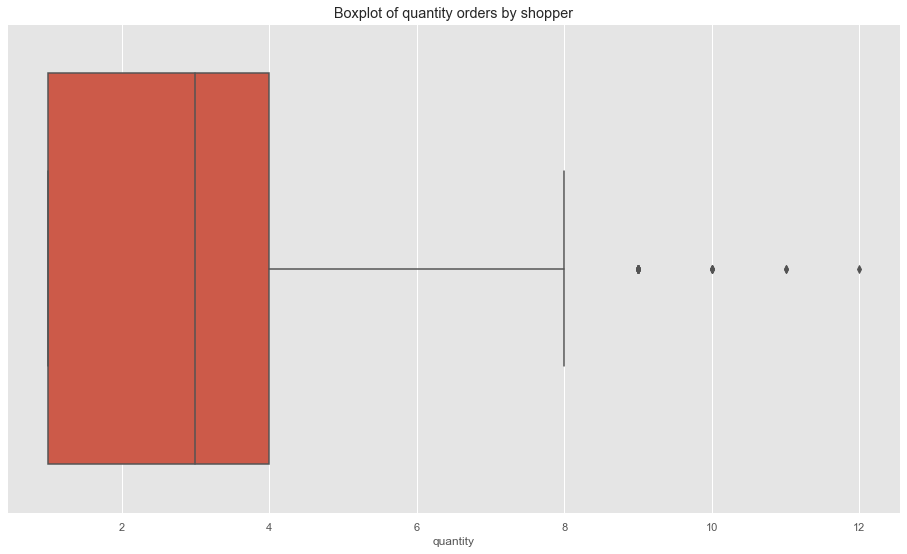

In [86]:
print(aux['quantity'].describe())
ax = sns.boxplot(x = aux["quantity"])
plt.title('Boxplot of quantity orders by shopper')
plt.show();

count    1388.000000
mean       77.261971
std        23.446071
min        29.876449
25%        60.356161
50%        73.845274
75%        90.481639
max       164.963520
Name: median, dtype: float64


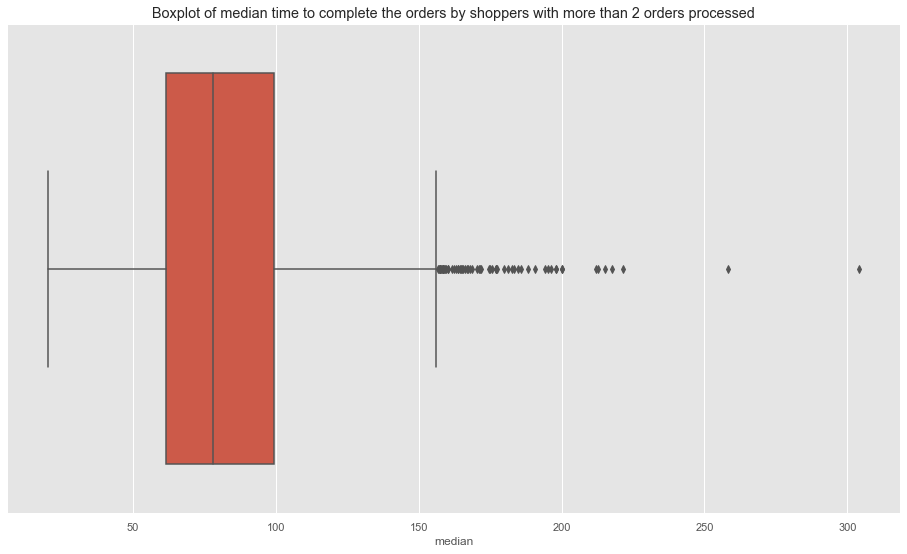

In [87]:
print(aux[aux.quantity>2]['median'].describe())
ax = sns.boxplot(x = aux["median"])
plt.title('Boxplot of median time to complete the orders by shoppers with more than 2 orders processed')
plt.show();

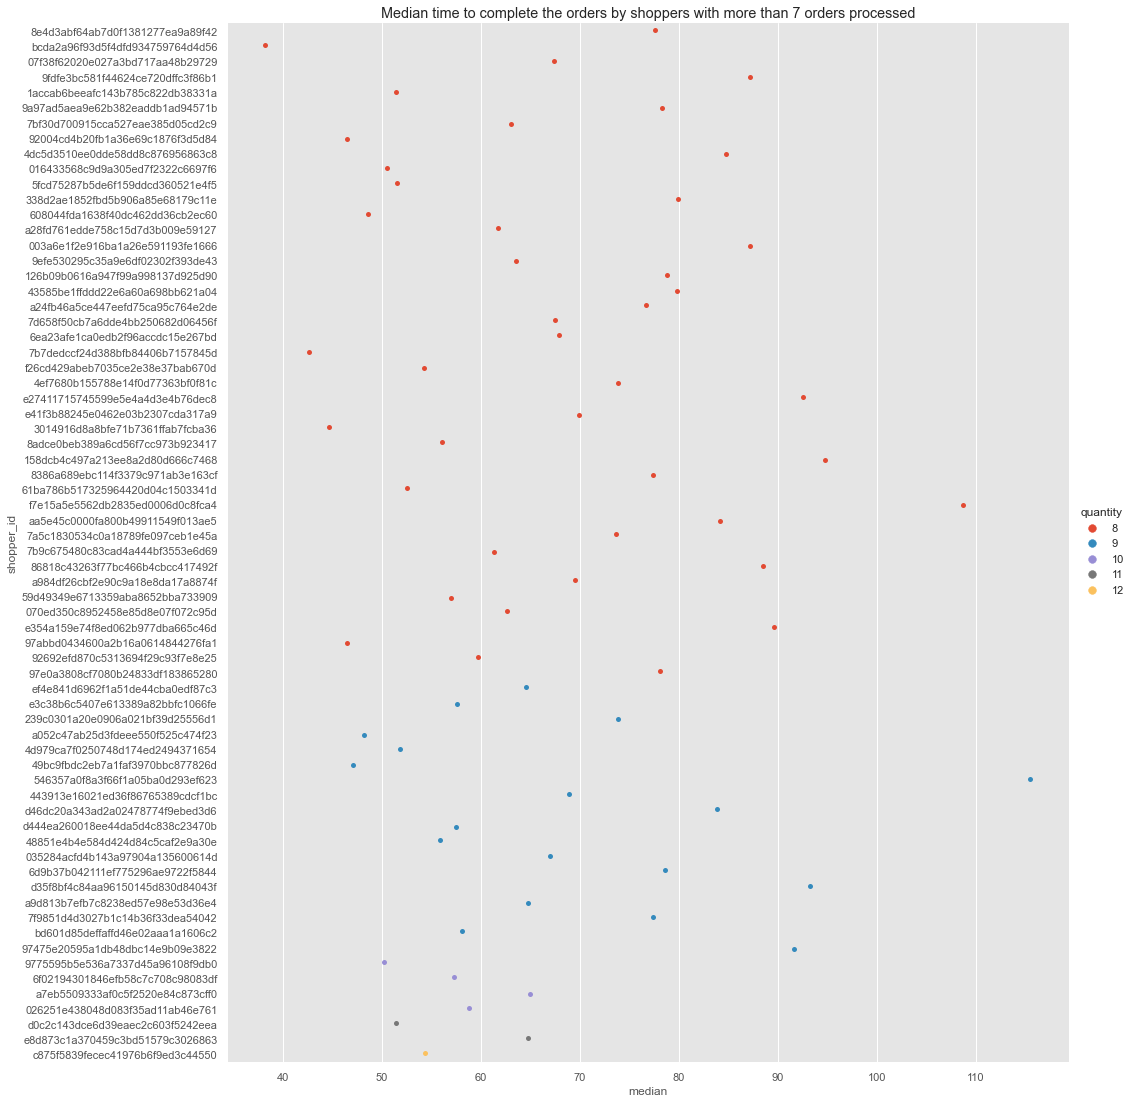

In [88]:
shopper_size_rep = list(aux[aux.quantity>7].shopper_id)
sns.catplot(x="median", y="shopper_id",orient="h", hue='quantity', 
            data=aux.loc[aux.shopper_id.apply(lambda x: True if x in shopper_size_rep else False)],aspect=1,height=15)
plt.title('Median time to complete the orders by shoppers with more than 7 orders processed')
plt.show();

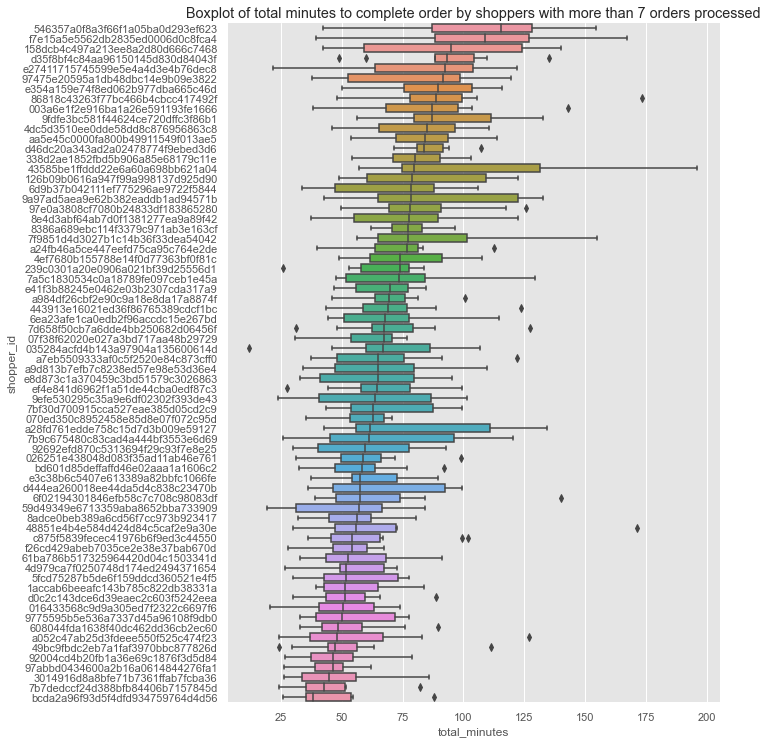

In [89]:
aux2 = model_data.loc[model_data.shopper_id.apply(lambda x: True if x in shopper_size_rep else False)]
sns.catplot(x="total_minutes", y="shopper_id",data=aux2,
            height=10,kind="box",order=list(aux[aux.quantity>7].sort_values(by='median', ascending=False).shopper_id))
plt.title('Boxplot of total minutes to complete order by shoppers with more than 7 orders processed')
plt.show();

In [90]:
len(set(results.shopper_id).difference(set(model_data.shopper_id)))

129

In [91]:
aux = get_measure_central_tendency(model_data,'order_id','shopper_id', 'total_minutes')
aux.describe()

mean          std       median     quantity  coef_var_pearson  \
count  2735.000000  1995.000000  2735.000000  2735.000000       1995.000000   
mean     84.309583    25.973282    82.957441     2.925046          0.315563   
std      28.571766    17.004510    29.640106     1.851040          0.172634   
min      20.331018     0.128420    20.331018     1.000000          0.001205   
25%      63.705962    13.685072    61.678202     1.000000          0.190848   
50%      80.424469    23.674823    78.066891     3.000000          0.306809   
75%      99.789877    34.610176    99.568941     4.000000          0.422237   
max     304.190303   164.534006   304.190303    12.000000          1.049039   

       cumsum_quantity  cumsum_quantity_pp  
count      2735.000000         2735.000000  
mean       2646.705667            0.330838  
std        2197.947493            0.274743  
min           1.000000            0.000125  
25%         684.500000            0.085563  
50%        2017.000000            0.252125  
75%        4240.000000            0.530000  
max        8000.000000            1.000000

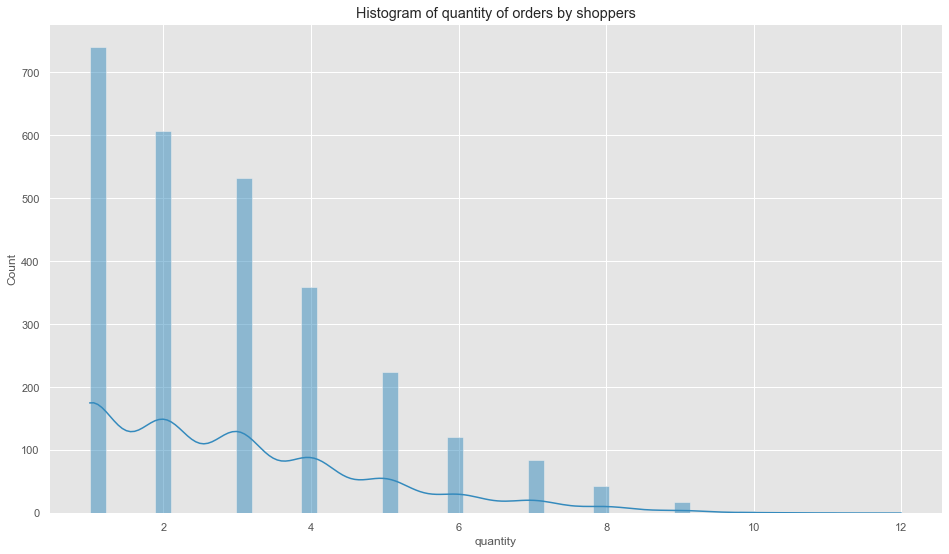

In [92]:
sns.histplot(data=aux, x="quantity", kde=True, bins=50)
plt.title('Histogram of quantity of orders by shoppers')
plt.show();

In [93]:
# Here we see that in 1035 of the 2735 shoppers (37%) the average is not representative, that is why we will use the median as a metric
print(sum(aux.coef_var_pearson>0.3))
100 * sum(aux.coef_var_pearson>0.3) / aux.shape[0]

1035


37.842778793418645

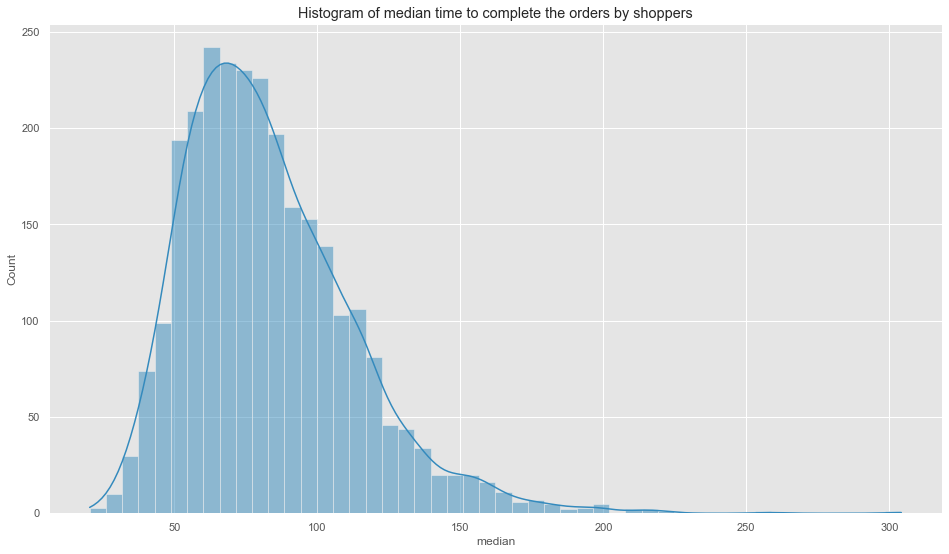

In [94]:
sns.histplot(data=aux, x="median", kde=True, bins=50)
plt.title('Histogram of median time to complete the orders by shoppers')
plt.show();

count    2735.000000
mean       82.957441
std        29.640106
min        20.331018
25%        61.678202
50%        78.066891
75%        99.568941
max       304.190303
Name: median, dtype: float64


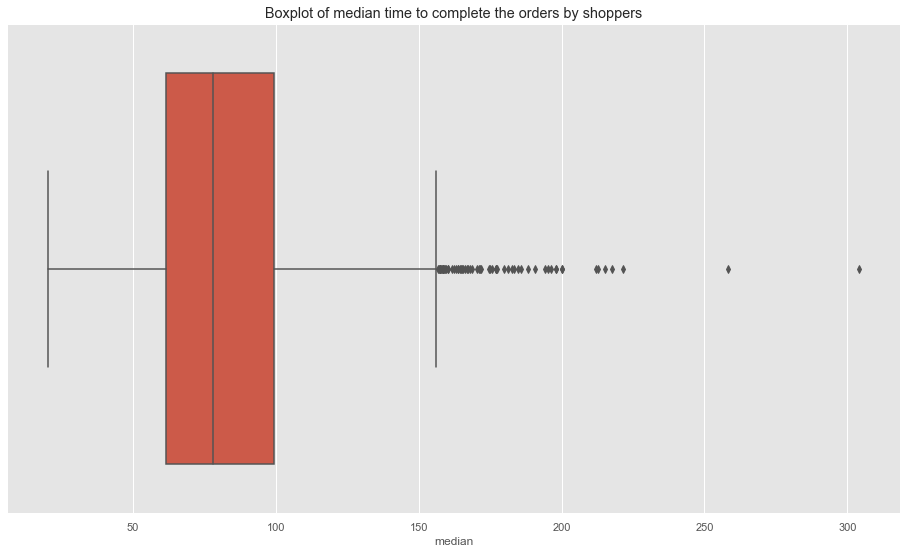

In [95]:
print(aux['median'].describe())
ax = sns.boxplot(x = aux["median"])
plt.title('Boxplot of median time to complete the orders by shoppers')
plt.show();

count    856.000000
mean      75.385171
std       20.873984
min       29.876449
25%       60.275099
50%       72.969581
75%       87.245461
max      158.732801
Name: median, dtype: float64


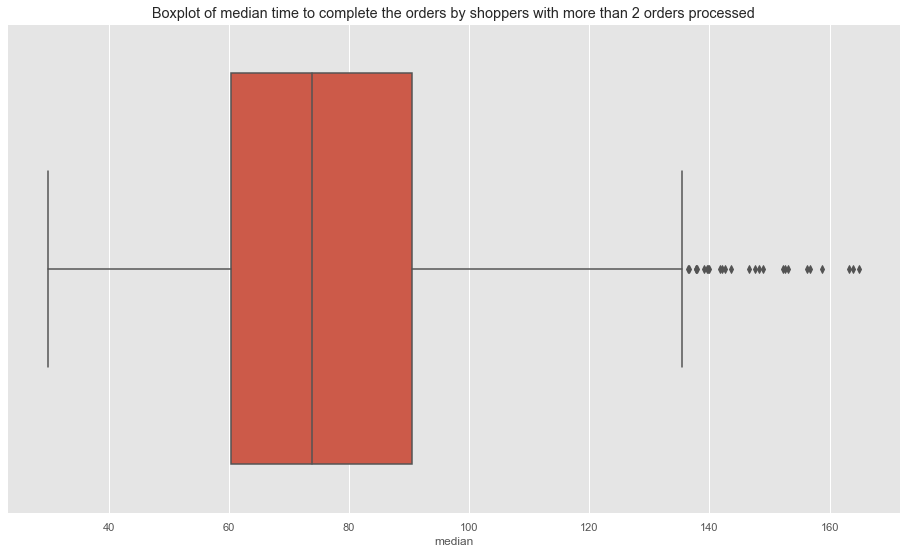

In [96]:
print(aux[aux.quantity>3]['median'].describe())
ax = sns.boxplot(x = aux[aux.quantity>2]["median"])
plt.title('Boxplot of median time to complete the orders by shoppers with more than 2 orders processed')
plt.show();

In [97]:
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,27))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,49))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,68))

1.0
2.0
3.0


In [98]:
print('la cantidad de shoppers que están en los datos a predecir y no en los de entrenamiento son:' + str(len(set(results.shopper_id).difference(set(model_data.shopper_id)))))

print('la cantidad de shoppers que están en los datos de entrenamiento y no en los datos a predecir son:' + str(len(set(model_data.shopper_id).difference(set(results.shopper_id)))))

la cantidad de shoppers que están en los datos a predecir y no en los de entrenamiento son:129
la cantidad de shoppers que están en los datos de entrenamiento y no en los datos a predecir son:1474


###### **Conclusions about the shoppers:**

* 27% of shoppers only have one order placed, 22% only 2 and 19% only 3, which means that 68% have less than 3 historical data in this sample. This is explained because the sample is concentrated in only 2 days (09-18-2019 and 09-19-2019)

* Indeed we see differences in the times in completing the order by shopper, however considering what was explained above, we cannot say with certainty that this is due to differences attributable to the particular person using the shopper_id

* Additionally there are 129 shoppers in the sample that we must predict are not in the training data

* As an alternative, and given that in the shoppers table we have data on their historical behavior, we will evaluate the possibility of using these attributes as explanatory variables to predict the time to complete the order.

##### Questions about stores

* **The time it takes for an order to arrive, does it vary by store?**

Indeed we see differences in the times to complete the order per store and in the dispersion of these times, as we can see in the boxplot where we filter only for those stores with more than 10 observations.
It is important to note that 41% of the stores only have one order placed, 57% only 2 and 67% only 3, which means that 67% have less than 3 historical data in this sample. This is explained because the sample is concentrated in only 2 days (09-18-2019 and 09-19-2019)

* **Are there stores assigned in the data to be predicted for which we do not previously have historical records?**

Additionally there are 42 stores in the sample that we must predict are not in the training data. As an alternative, and given that in the table of stores we have data of their geolocation, we focus on the distance between the store and the place where the order must be delivered as the main characteristic of the store associated with the order.

In [99]:
aux = get_measure_central_tendency(model_data,'order_id','store_branch_id', 'total_minutes')
aux.describe()

mean         std      median     quantity  coef_var_pearson  \
count  434.000000  254.000000  434.000000   434.000000        254.000000   
mean    61.975069   19.727734   60.445862    18.433180          0.305806   
std     24.697173   13.113590   24.072352   108.180336          0.152232   
min     13.856485    0.302884   13.856485     1.000000          0.008818   
25%     44.249453    9.936759   43.016035     1.000000          0.202238   
50%     57.148119   17.232736   55.334822     2.000000          0.308286   
75%     74.798830   27.664407   73.791533     5.000000          0.397812   
max    191.243153   90.466040  191.243153  1683.000000          0.822388   

       cumsum_quantity  cumsum_quantity_pp  
count       434.000000          434.000000  
mean        507.760369            0.063470  
std         798.901566            0.099863  
min           1.000000            0.000125  
25%         109.250000            0.013656  
50%         255.000000            0.031875  
75%         583.750000            0.072969  
max        8000.000000            1.000000

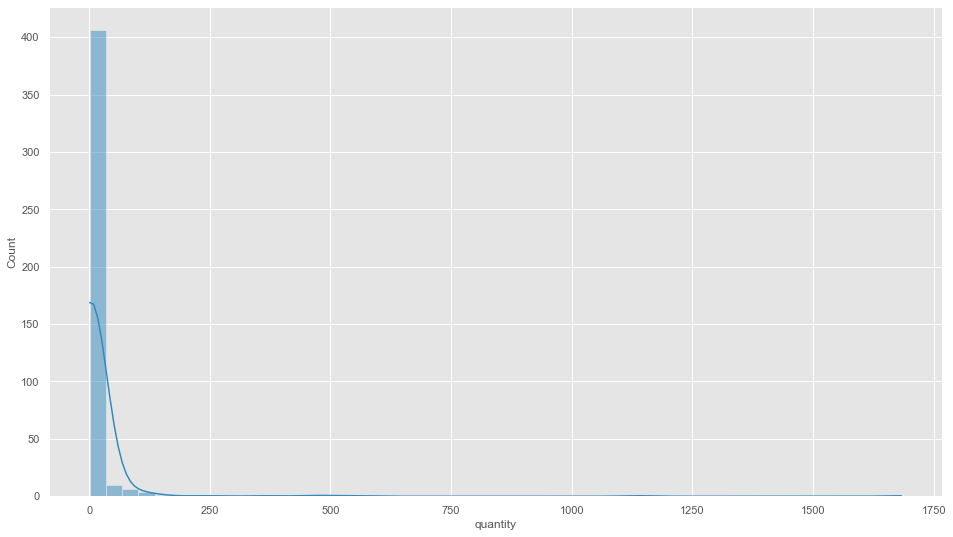

In [100]:
sns.histplot(data=aux, x="quantity", kde=True, bins=50);

In [101]:
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,41))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,57))
# calculo el valor asociado al percentil que entrego
print(np.percentile(aux.quantity,67))

1.0
2.0
3.0


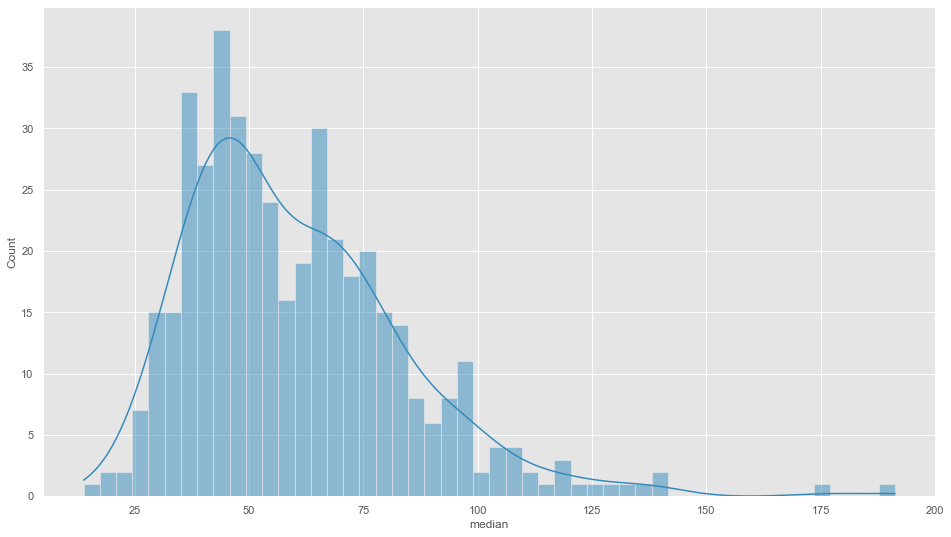

In [102]:
sns.histplot(data=aux, x="median", kde=True, bins=50);

count    434.000000
mean      60.445862
std       24.072352
min       13.856485
25%       43.016035
50%       55.334822
75%       73.791533
max      191.243153
Name: median, dtype: float64


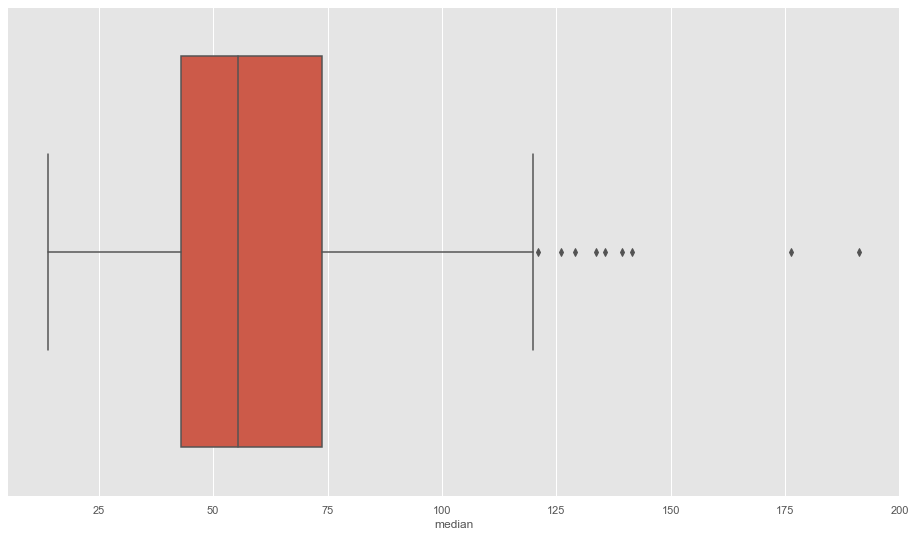

In [103]:
print(aux['median'].describe())
ax = sns.boxplot(x = aux["median"])

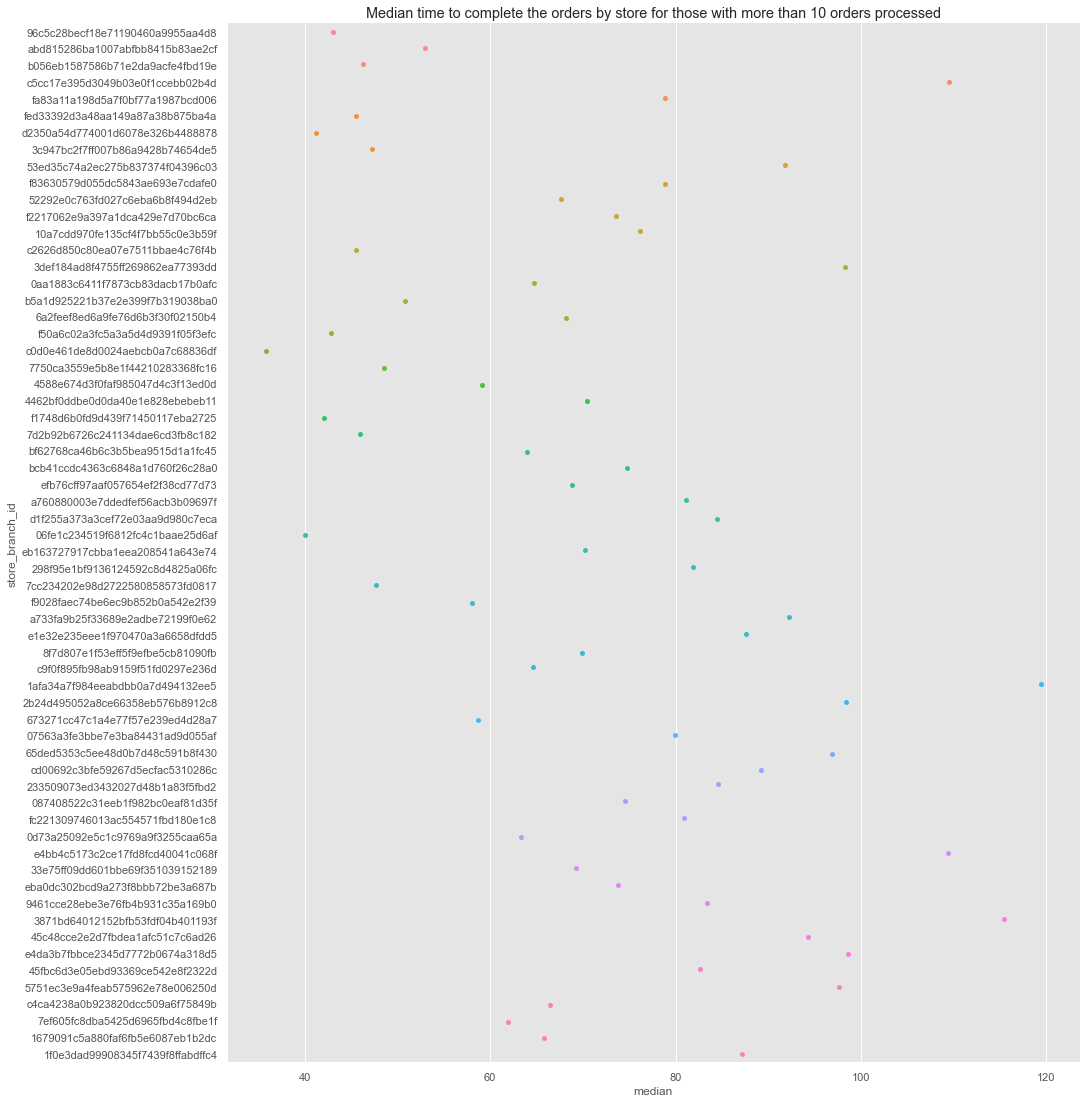

In [104]:
store_size_rep = list(aux[aux.quantity>=10].store_branch_id)
sns.catplot(x="median", y="store_branch_id",orient="h", 
            data=aux.loc[aux.store_branch_id.apply(lambda x: True if x in store_size_rep else False)],aspect=1,height=15)
plt.title('Median time to complete the orders by store for those with more than 10 orders processed')
plt.show();

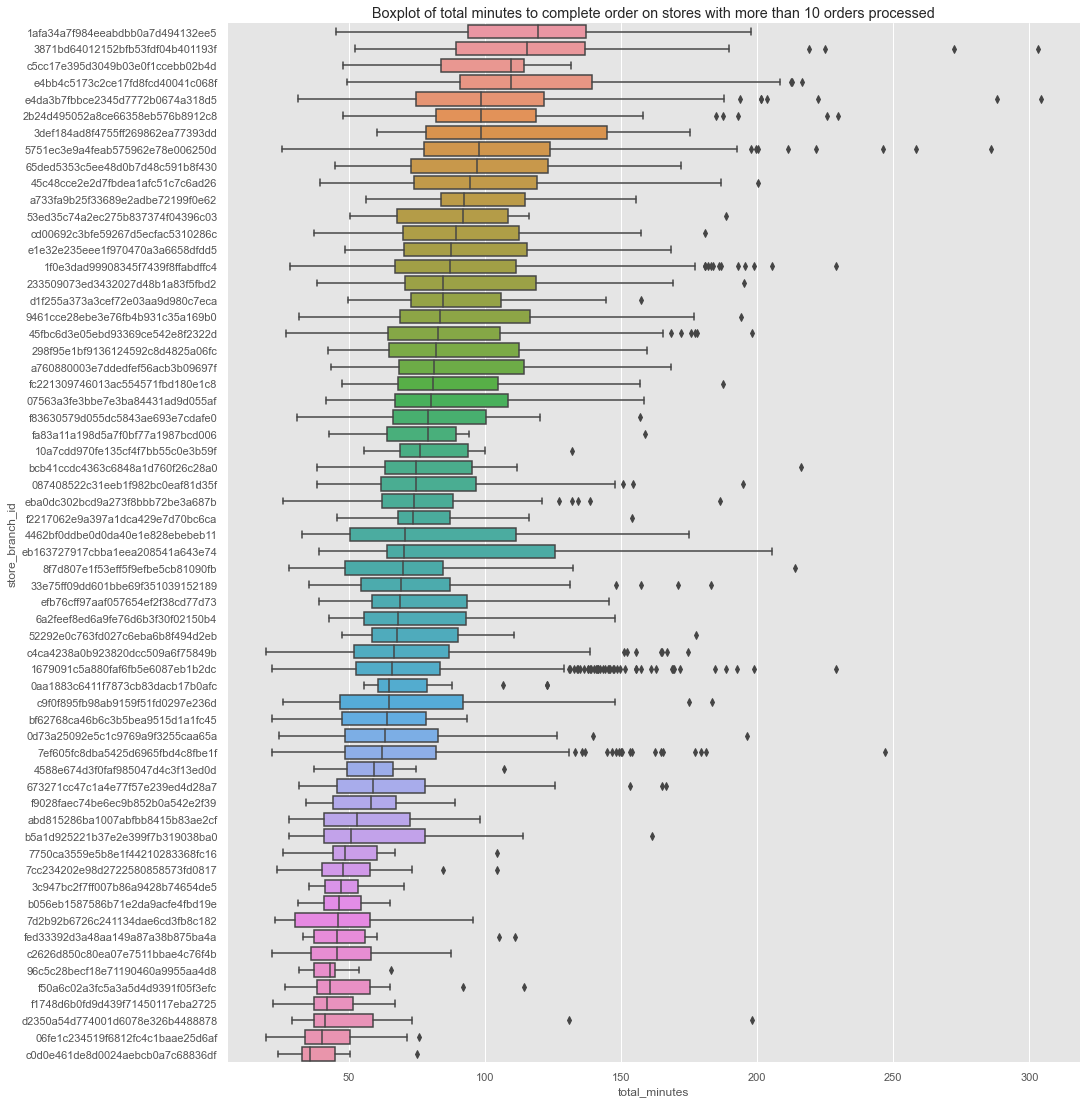

In [105]:
aux2 = model_data.loc[model_data.store_branch_id.apply(lambda x: True if x in store_size_rep else False)]
sns.catplot(x="total_minutes", y="store_branch_id",data=aux2,
            height=15,kind="box",order=list(aux[aux.quantity>=10].sort_values(by='median', ascending=False).store_branch_id))
plt.title('Boxplot of total minutes to complete order on stores with more than 10 orders processed')
plt.show();

In [106]:
print('la cantidad de tiendas que están en los datos a predecir y no en los de entrenamiento son:' + str(len(set(results.store_branch_id).difference(set(model_data.store_branch_id)))))

print('la cantidad de tiendas que están en los datos de entrenamiento y no en los datos a predecir son:' + str(len(set(model_data.store_branch_id).difference(set(results.store_branch_id)))))

la cantidad de tiendas que están en los datos a predecir y no en los de entrenamiento son:42
la cantidad de tiendas que están en los datos de entrenamiento y no en los datos a predecir son:247


## Hourly analysis of the variables that can influence the times to complete the order

**Understand the effect of the amount of:**

* Orders
* Different shoppers assigned
* Different products requested
* Different stores from where the order is made
* Different stores where they must collect the order
* Different districts from where the order is made
* Different districts from where they must pick up the order

**in the times to complete the order**

### Questions

* Do they affect the time to complete the order? how?


* Is there a correlation between these variables?

#### Evidence

In [107]:
model_data.columns

Index(['order_id', 'orders_lat', 'orders_lng', 'promised_time', 'on_demand',
       'shopper_id', 'store_branch_id', 'total_minutes', 'promised_time_hours',
       'promised_time_id', 'total_minutes_range', 'orders_location', 'sla',
       'order_district', 'KG', 'UN', 'store_id', 'stores_lat', 'stores_lng',
       'stores_location', 'store_district', 'seniority', 'found_rate',
       'picking_speed', 'accepted_rate', 'rating', 'order_stores_distance',
       'is_weighted', 'seniority_encode'],
      dtype='object')

In [108]:
aux = get_measure_central_tendency(model_data,"order_id","promised_time", 'total_minutes');
aux['quantity(%)'] = 100 * (aux.quantity/ aux.quantity.sum())
bins = [0, 60, 80, 100, np.inf]
names = ['<60','60-80', '80-100', '100+']
aux['medianRange'] = pd.cut(aux['median'], bins, labels=names)
# acá agrego la cantidad de shoppers, stores y district por hora en que se prometió la órden
aux = pd.merge(aux,pd.DataFrame(model_data.groupby(['promised_time']).nunique()[['shopper_id','store_branch_id','store_id',
                                                                                 'store_district','order_district']]).reset_index(), 
               on= 'promised_time').sort_values(by='promised_time')
aux['ratio_order_shoppers'] = 100 * (aux.quantity/ aux.shopper_id)
print(aux.shape)
aux.head(3)

(852, 16)


promised_time       mean       std     median  quantity  \
0    2019-10-18 19:01:00+00:00  26.902219       NaN  26.902219         1   
542  2019-10-18 19:02:00+00:00  43.439538  7.428104  45.661660         5   
186  2019-10-18 19:03:00+00:00  36.239618       NaN  36.239618         1   

     coef_var_pearson  cumsum_quantity  cumsum_quantity_pp  quantity(%)  \
0                 NaN                1            0.000125       0.0125   
542          0.170999             1281            0.160125       0.0625   
186               NaN              187            0.023375       0.0125   

    medianRange  shopper_id  store_branch_id  store_id  store_district  \
0           <60           1                1         1               1   
542         <60           5                5         5               3   
186         <60           1                1         1               1   

     order_district  ratio_order_shoppers  
0                 1                 100.0  
542               2                 100.0  
186               1                 100.0

In [109]:
total_minutes_range = model_data.groupby(['promised_time','total_minutes_range'])['order_id'].count().reset_index()
total_minutes_range.rename(columns=({'order_id':'n_orders'}), inplace=True)
total_minutes_range = pd.pivot_table(total_minutes_range,index=["promised_time"], columns=["total_minutes_range"])
#total_minutes_range.rename(index={0: 'menor a 60', 1: "entre 60 y 80", 2: 'entre 80 y 100', 3: 'mayor a 100'}, inplace=True)
aux = pd.merge(total_minutes_range,aux,on= 'promised_time').sort_values(by='promised_time')
aux.columns= ['promised_time','menor a 60',"entre 60 y 80",'entre 80 y 100','mayor a 100',
              'mean', 'std', 'median', 'quantity', 'coef_var_pearson',
              'cumsum_quantity', 'cumsum_quantity_pp', 'quantity(%)', 
              'medianRange','shopper_id', 'store_branch_id', 'product_id',
              'store_district','order_district', 'ratio_order_shoppers']
aux['mayor a 100 en %'] = 100*aux['mayor a 100']/aux.quantity
aux['entre 80 y 100 en %'] = 100*aux['entre 80 y 100']/aux.quantity
aux['entre 60 y 80 en %'] = 100*aux['entre 60 y 80']/aux.quantity
aux['menor a 60 en %'] = 100*aux['menor a 60']/aux.quantity
aux['mayor a 80 en %'] = aux['entre 80 y 100 en %'] + aux['mayor a 100 en %']
aux['mayor a 80'] = aux['entre 80 y 100'] + aux['mayor a 100']
aux['promised_time'] = aux.promised_time.apply(lambda x: (datetime.strptime(str(x).split('+')[0][0:-6], '%Y-%m-%d %H')))
aux['promised_time_id'] = aux.promised_time.apply(lambda x: str(x.day) + '-' + str(x.hour))
print(aux.shape)
aux.head(2)

(852, 27)


promised_time  menor a 60  entre 60 y 80  entre 80 y 100  mayor a 100  \
0 2019-10-18 19:00:00         NaN            NaN             NaN          1.0   
1 2019-10-18 19:00:00         NaN            NaN             NaN          5.0   

        mean       std     median  quantity  coef_var_pearson  \
0  26.902219       NaN  26.902219         1               NaN   
1  43.439538  7.428104  45.661660         5          0.170999   

   cumsum_quantity  cumsum_quantity_pp  quantity(%) medianRange  shopper_id  \
0                1            0.000125       0.0125         <60           1   
1             1281            0.160125       0.0625         <60           5   

   store_branch_id  product_id  store_district  order_district  \
0                1           1               1               1   
1                5           5               3               2   

   ratio_order_shoppers  mayor a 100 en %  entre 80 y 100 en %  \
0                 100.0             100.0                  NaN   
1                 100.0             100.0                  NaN   

   entre 60 y 80 en %  menor a 60 en %  mayor a 80 en %  mayor a 80  \
0                 NaN              NaN              NaN         NaN   
1                 NaN              NaN              NaN         NaN   

  promised_time_id  
0            18-19  
1            18-19

count    852.000000
mean       9.389671
std       43.151832
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max      534.000000
Name: quantity, dtype: float64


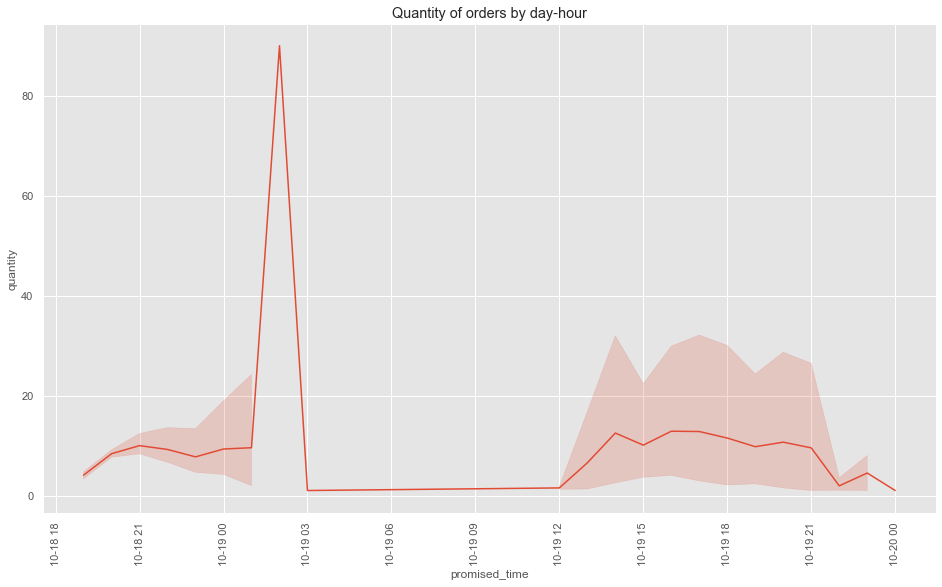

In [110]:
print(aux['quantity'].describe())
sns.lineplot(data=aux, x="promised_time", y="quantity")
plt.xticks(rotation=90)
plt.title('Quantity of orders by day-hour')
plt.show()

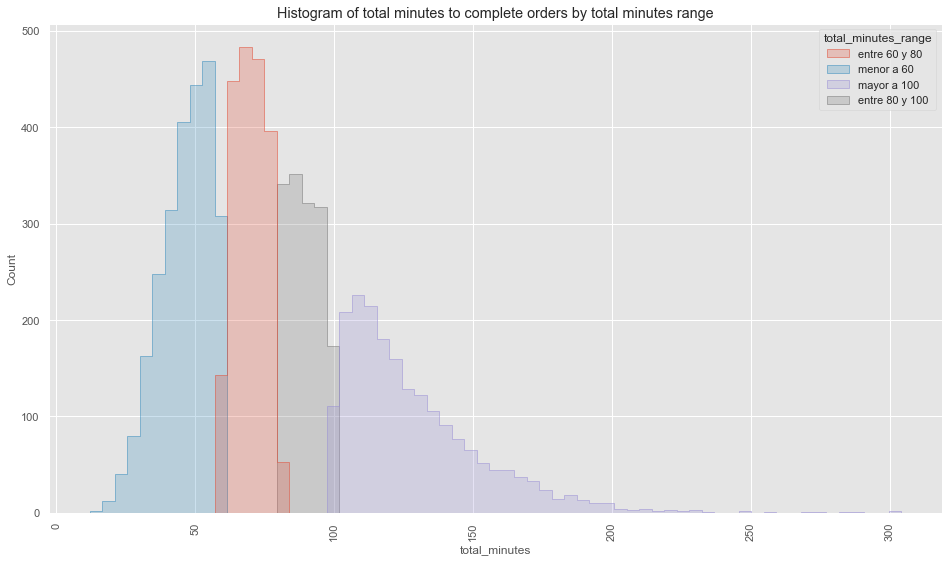

In [111]:
sns.histplot(data=model_data, x="total_minutes",hue= 'total_minutes_range', element="step")
plt.xticks(rotation=90)
plt.title('Histogram of total minutes to complete orders by total minutes range')
plt.show()

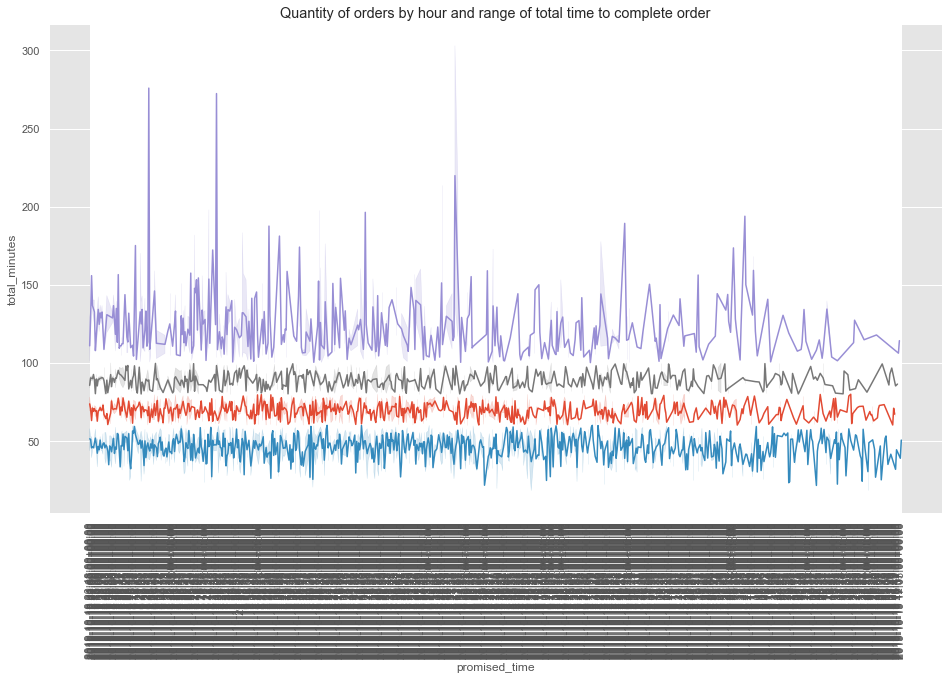

In [112]:
sns.lineplot(x="promised_time", y="total_minutes", data=model_data,hue= 'total_minutes_range', legend= False)
plt.xticks(rotation=90)
plt.title('Quantity of orders by hour and range of total time to complete order')
plt.show()

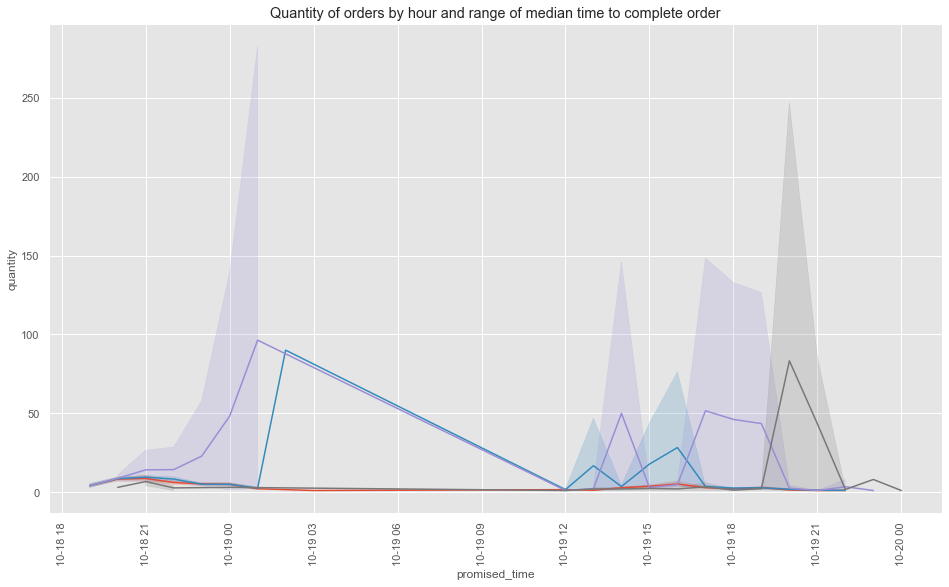

In [113]:
sns.lineplot(x="promised_time", y="quantity", data=aux,hue= 'medianRange', legend=False)
plt.xticks(rotation=90)
plt.title('Quantity of orders by hour and range of median time to complete order')
plt.show()

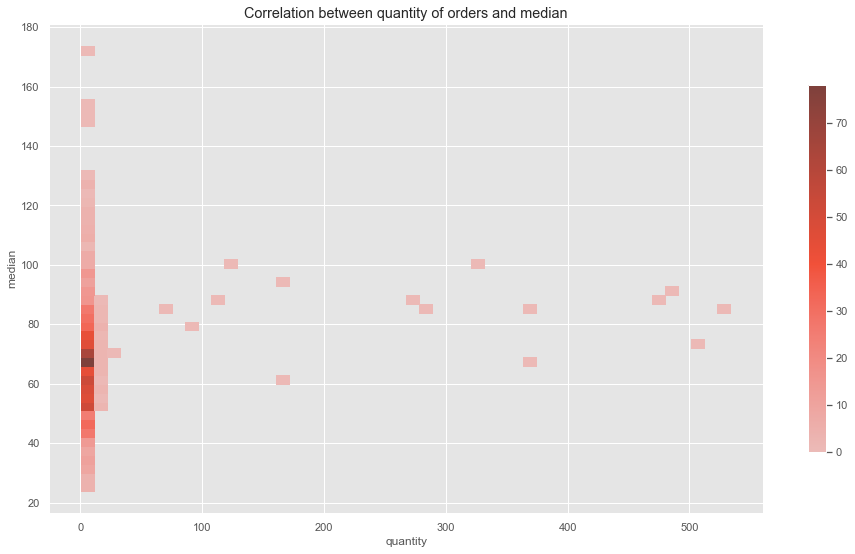

In [114]:
sns.histplot(
    aux, x="quantity", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of orders and median')
plt.show()

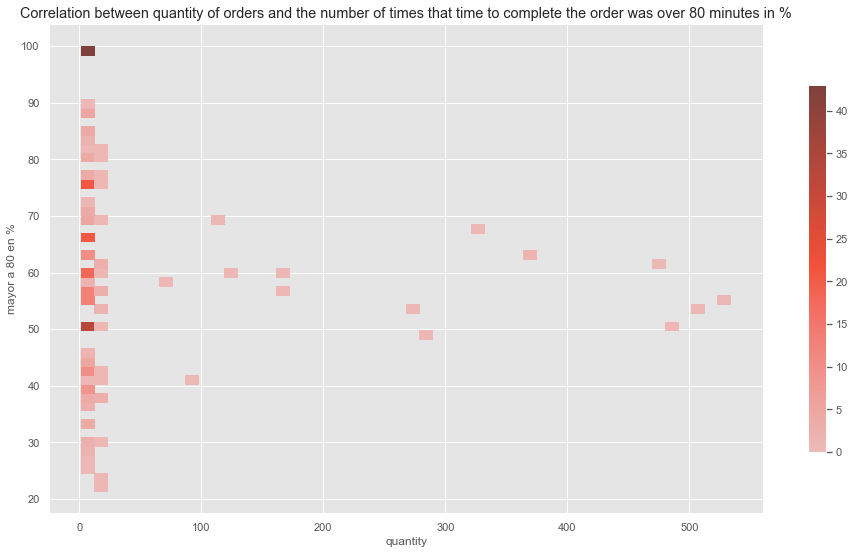

In [115]:
sns.histplot(
    aux, x="quantity", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of orders and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

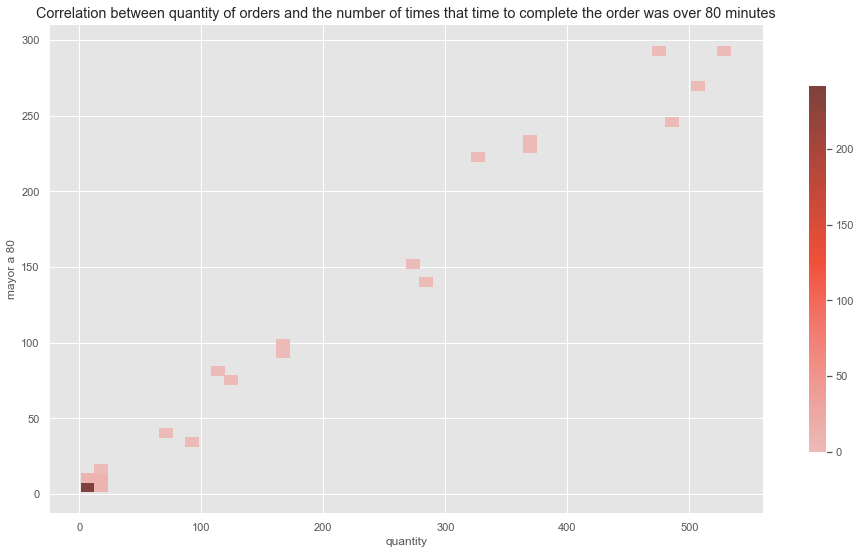

In [116]:
sns.histplot(
    aux, x="quantity", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of orders and the number of times that time to complete the order was over 80 minutes')
plt.show()

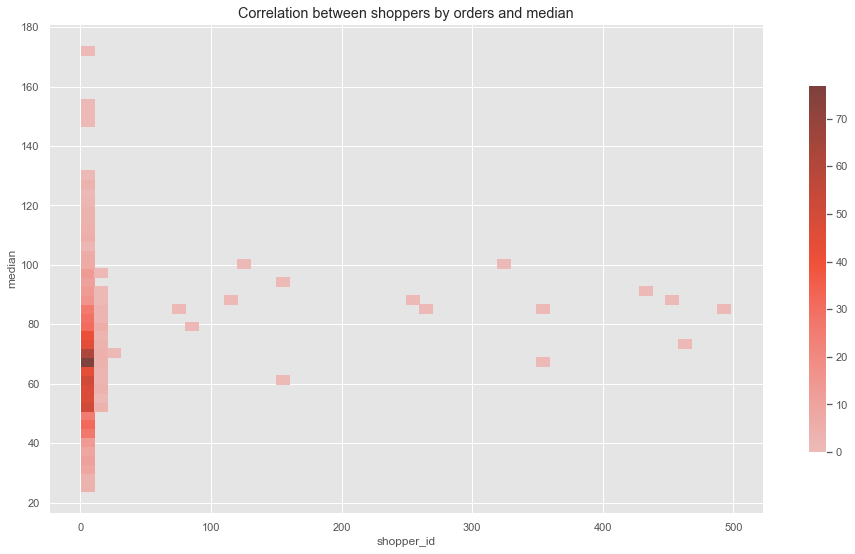

In [117]:
sns.histplot(
    aux, x="shopper_id", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
);
plt.title('Correlation between shoppers by orders and median')
plt.show()

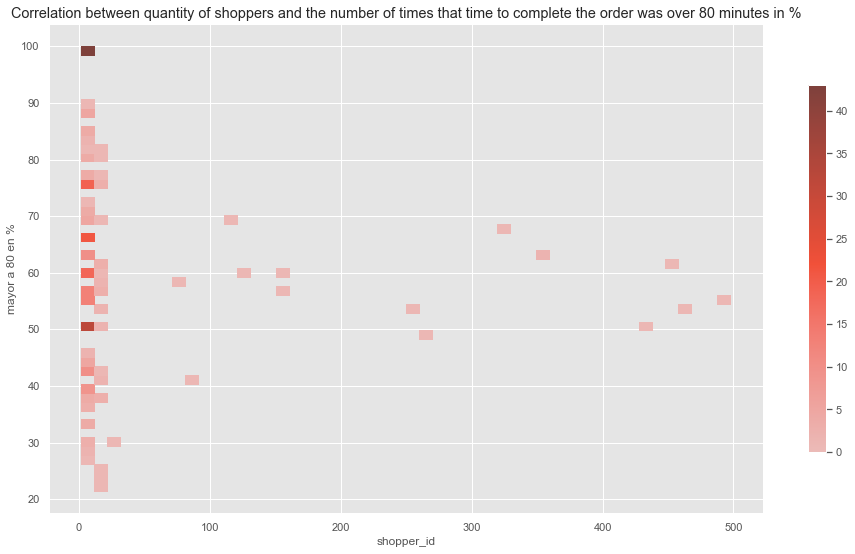

In [118]:
sns.histplot(
    aux, x="shopper_id", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of shoppers and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

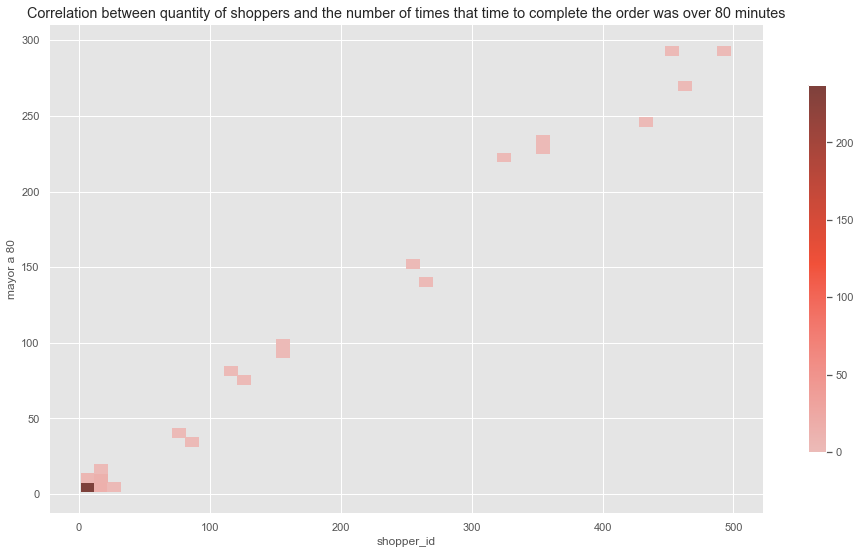

In [119]:
sns.histplot(
    aux, x="shopper_id", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of shoppers and the number of times that time to complete the order was over 80 minutes')
plt.show()

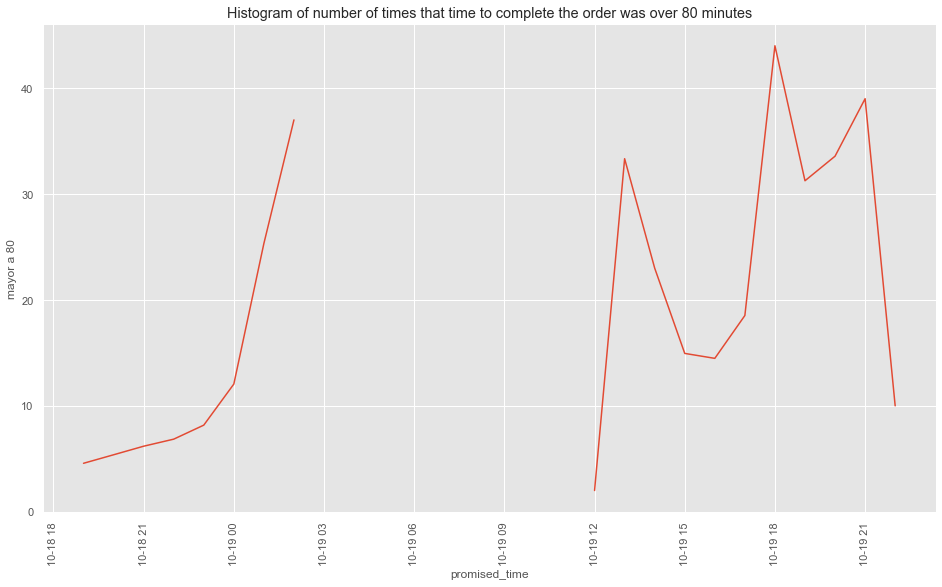

In [120]:
sns.lineplot(data=aux, x="promised_time", y="mayor a 80")
plt.xticks(rotation=90)
plt.title('Histogram of number of times that time to complete the order was over 80 minutes')
plt.show()

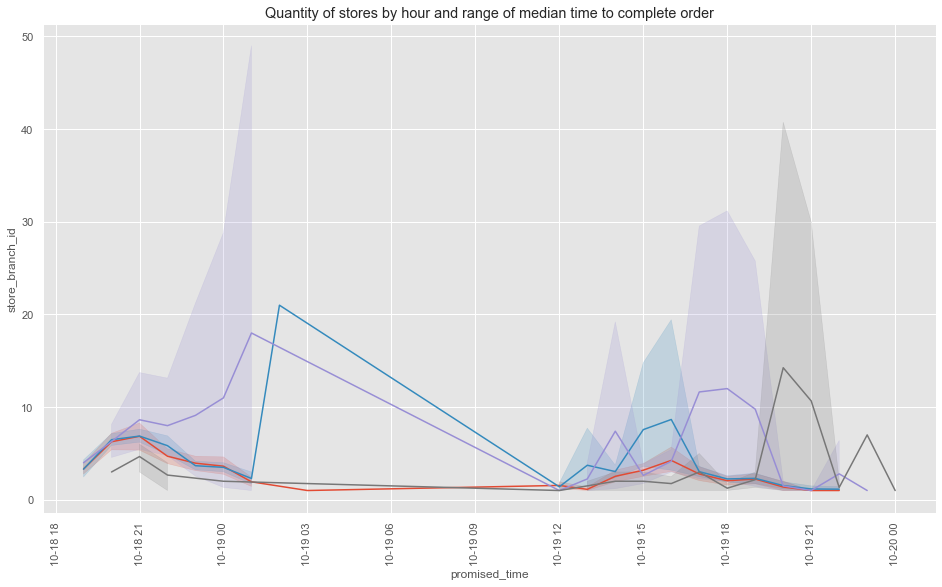

In [121]:
sns.lineplot(data=aux, x="promised_time", y="store_branch_id",hue = 'medianRange', legend=False)
plt.xticks(rotation=90)
plt.title('Quantity of stores by hour and range of median time to complete order')
plt.show()

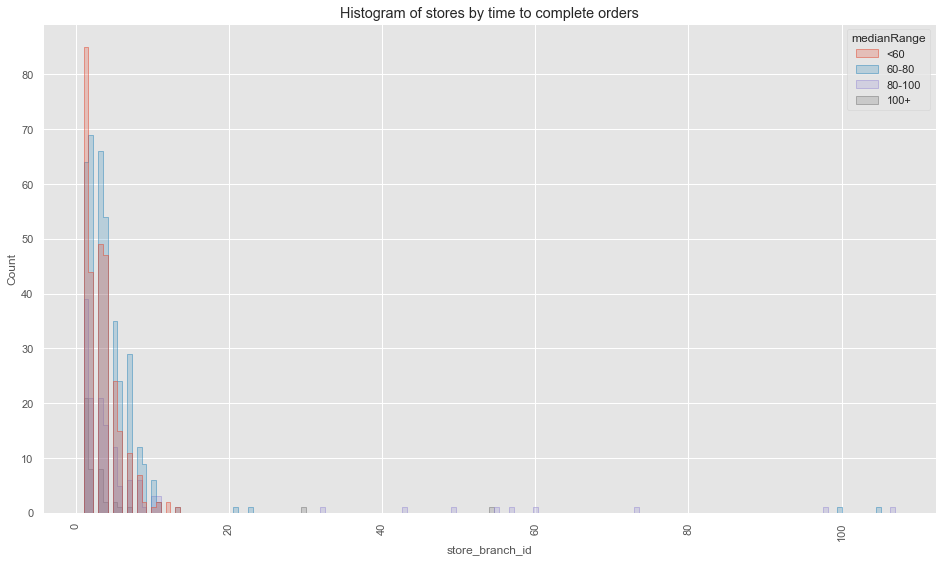

In [122]:
sns.histplot(data=aux, x="store_branch_id",hue = 'medianRange', element="step")
plt.xticks(rotation=90)
plt.title('Histogram of stores by time to complete orders')
plt.show()

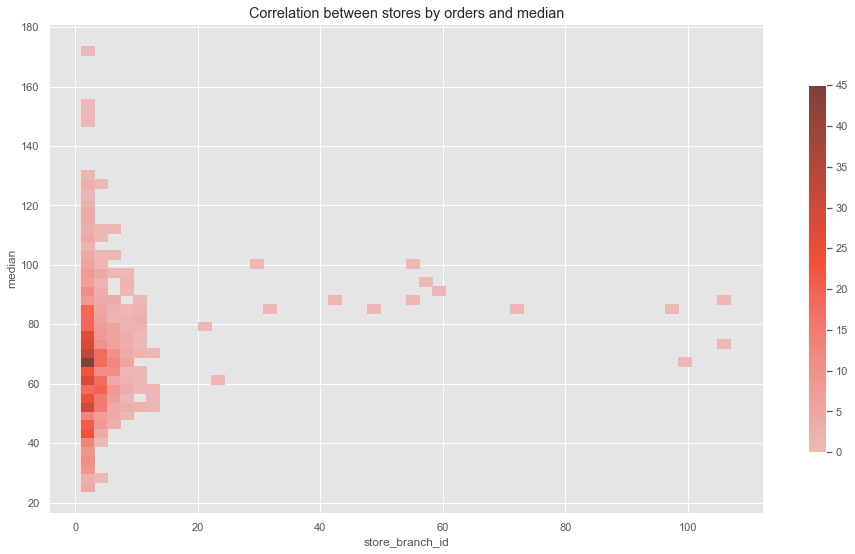

In [123]:
sns.histplot(
    aux, x="store_branch_id", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
);
plt.title('Correlation between stores by orders and median')
plt.show()

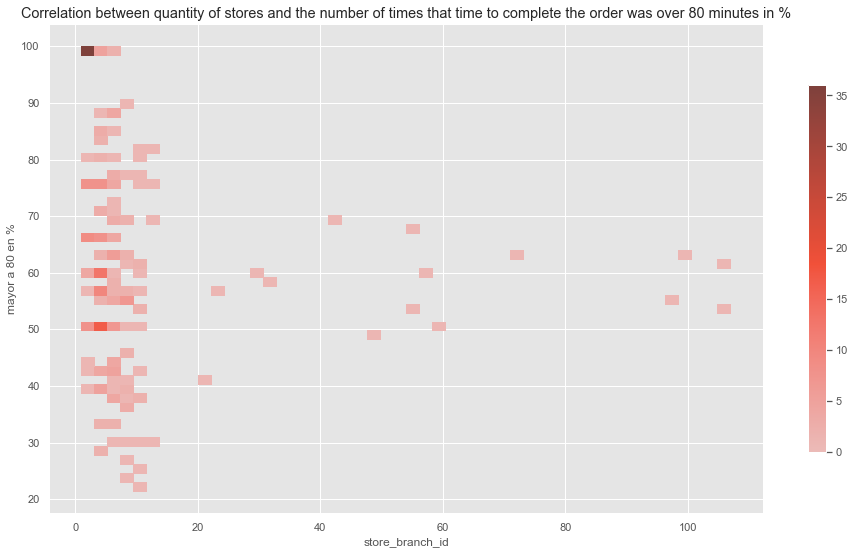

In [124]:
sns.histplot(
    aux, x="store_branch_id", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of stores and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

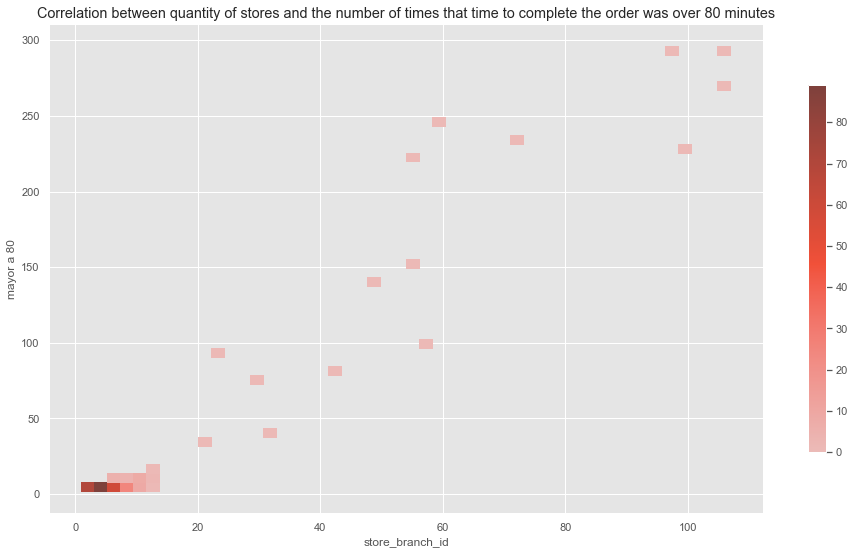

In [125]:
sns.histplot(
    aux, x="store_branch_id", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of stores and the number of times that time to complete the order was over 80 minutes')
plt.show()

count    852.000000
mean       3.301643
std        2.903759
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max       25.000000
Name: store_district, dtype: float64


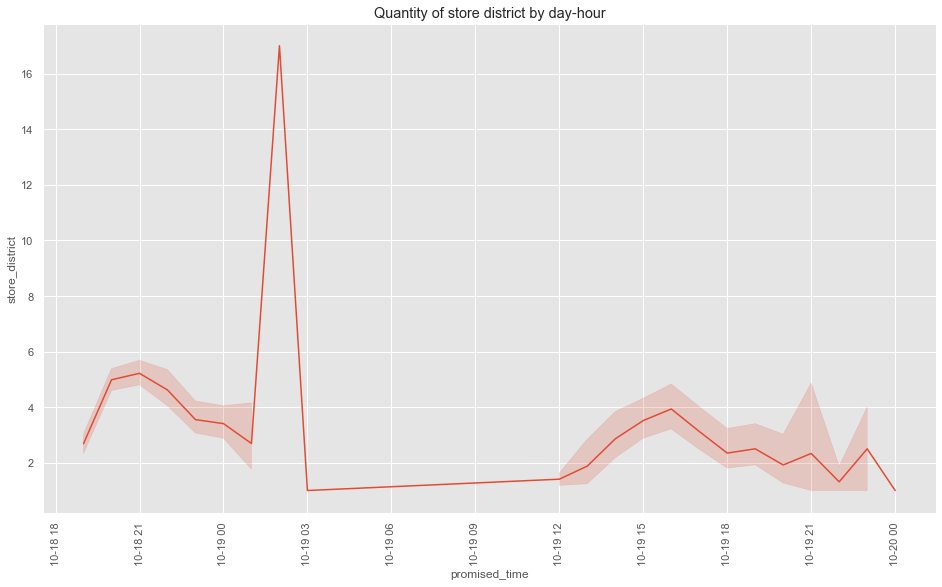

In [126]:
print(aux['store_district'].describe())
sns.lineplot(data=aux, x="promised_time", y="store_district")
plt.xticks(rotation=90)
plt.title('Quantity of store district by day-hour')
plt.show()

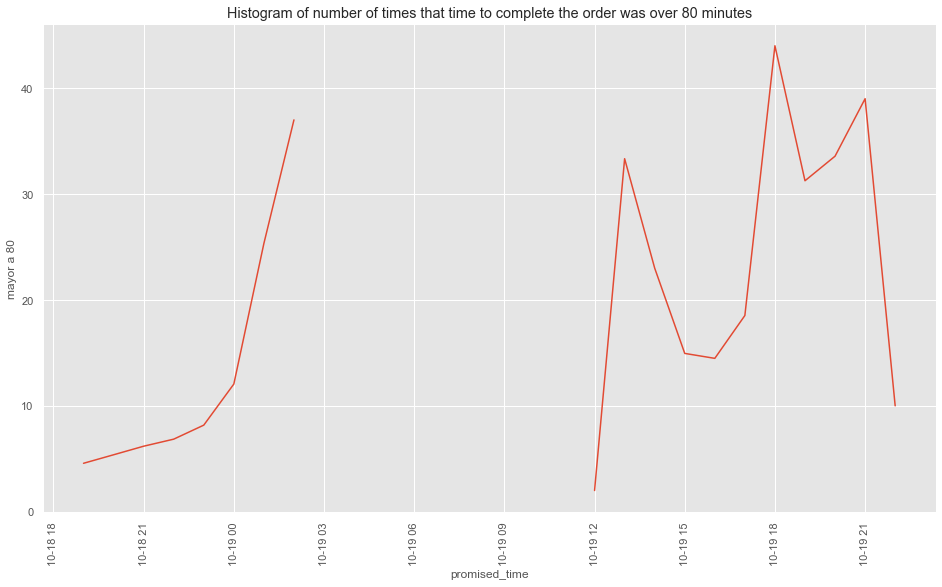

In [127]:
sns.lineplot(data=aux, x="promised_time", y="mayor a 80")
plt.xticks(rotation=90)
plt.title('Histogram of number of times that time to complete the order was over 80 minutes')
plt.show()

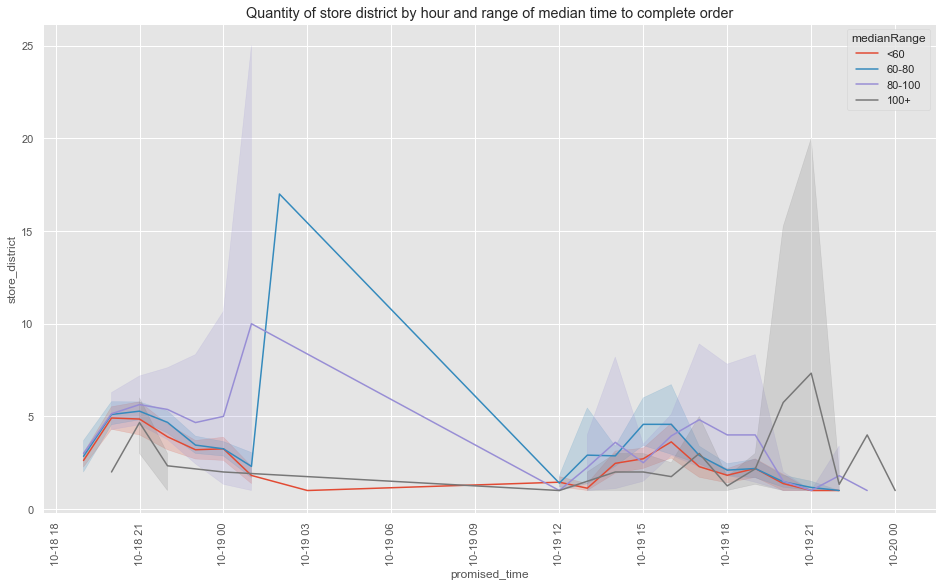

In [128]:
sns.lineplot(data=aux, x="promised_time", y="store_district",hue = 'medianRange')
plt.xticks(rotation=90)
plt.title('Quantity of store district by hour and range of median time to complete order')
plt.show()

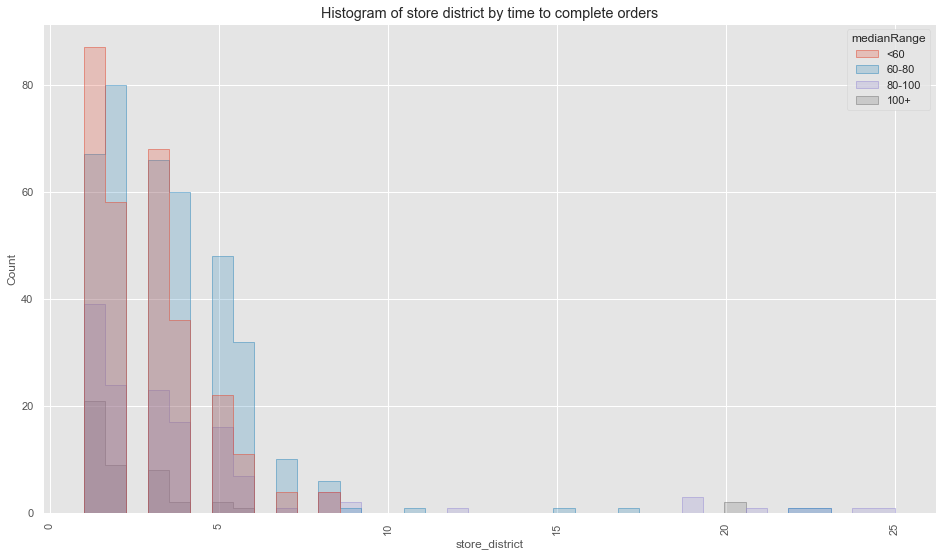

In [129]:
sns.histplot(data=aux, x="store_district",hue = 'medianRange', element="step")
plt.xticks(rotation=90)
plt.title('Histogram of store district by time to complete orders')
plt.show()

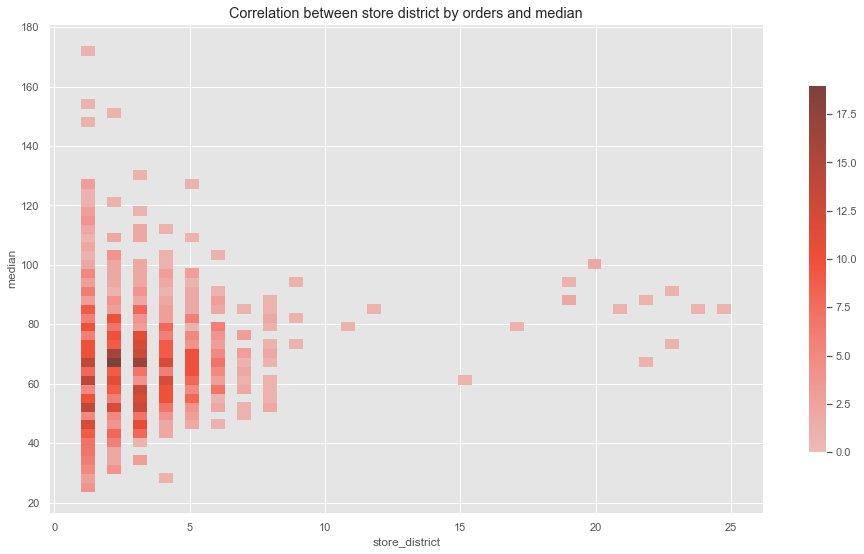

In [130]:
sns.histplot(
    aux, x="store_district", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between store district by orders and median')
plt.show()

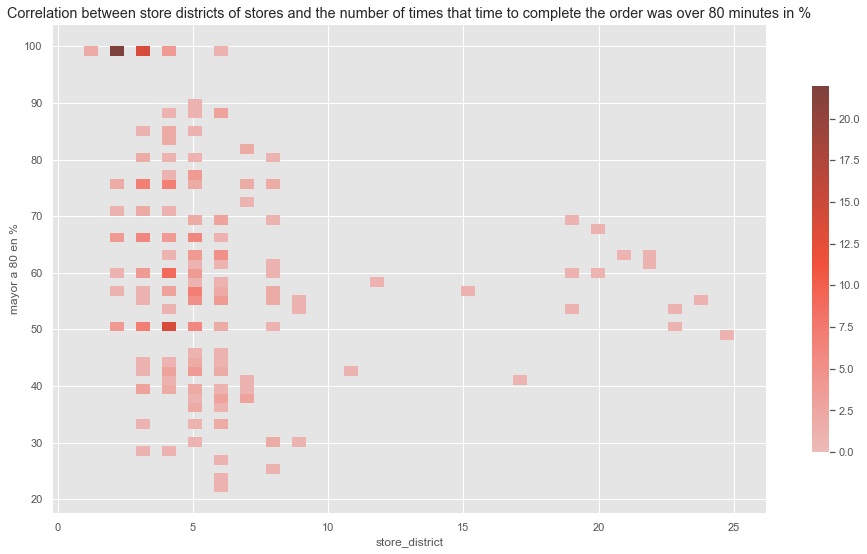

In [131]:
sns.histplot(
    aux, x="store_district", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between store districts of stores and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

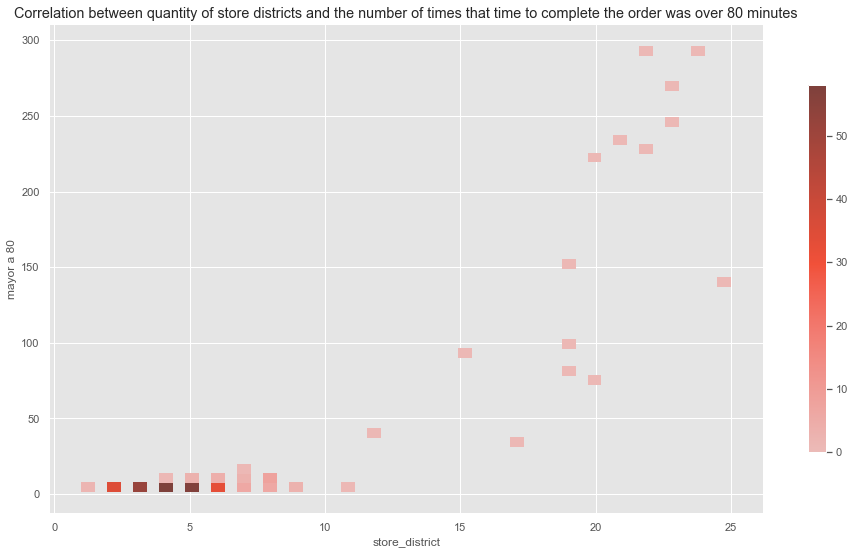

In [132]:
sns.histplot(
    aux, x="store_district", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between quantity of store districts and the number of times that time to complete the order was over 80 minutes')
plt.show()

count    852.000000
mean       3.301643
std        2.903759
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max       25.000000
Name: store_district, dtype: float64


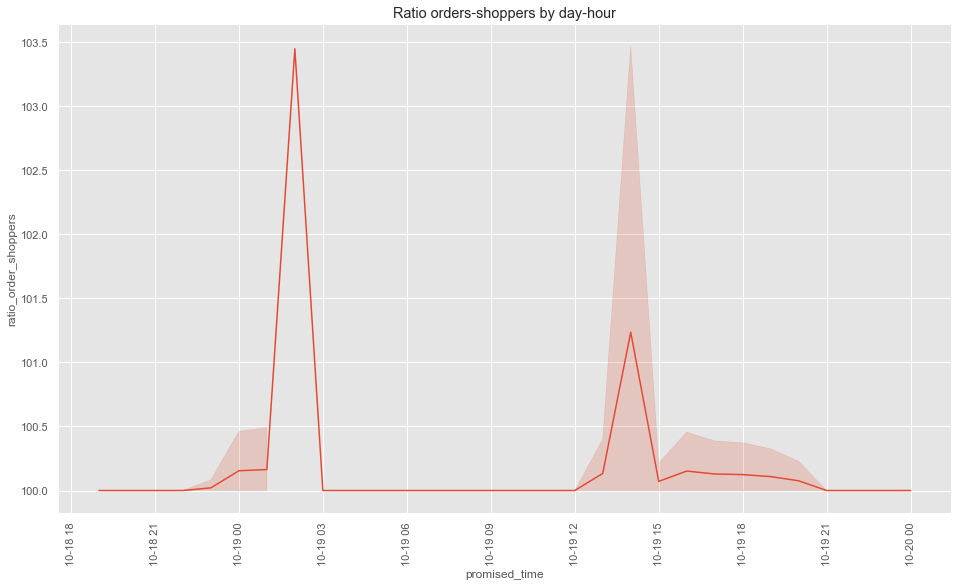

In [133]:
print(aux['store_district'].describe())
sns.lineplot(data=aux, x="promised_time", y="ratio_order_shoppers")
plt.xticks(rotation=90)
plt.title('Ratio orders-shoppers by day-hour')
plt.show()

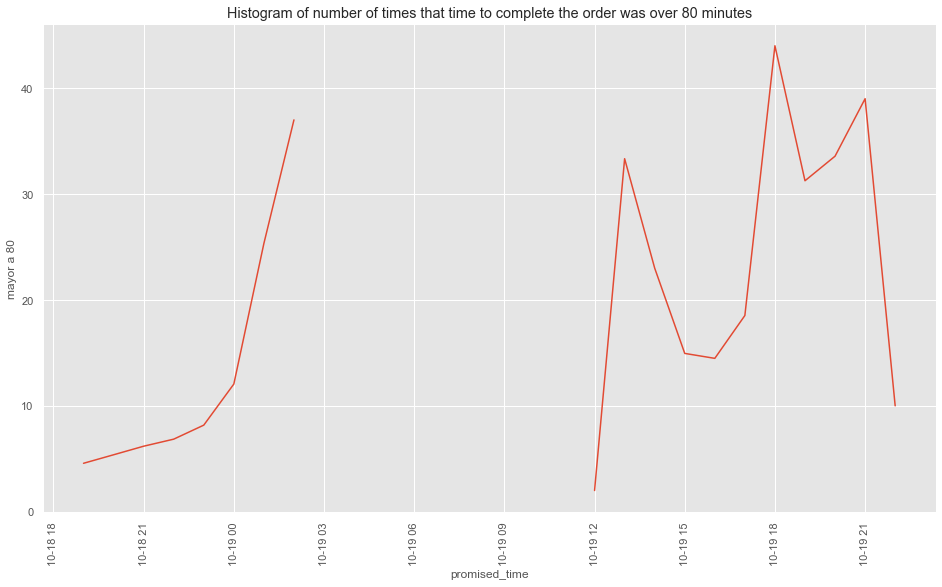

In [134]:
sns.lineplot(data=aux, x="promised_time", y="mayor a 80")
plt.xticks(rotation=90)
plt.title('Histogram of number of times that time to complete the order was over 80 minutes')
plt.show()

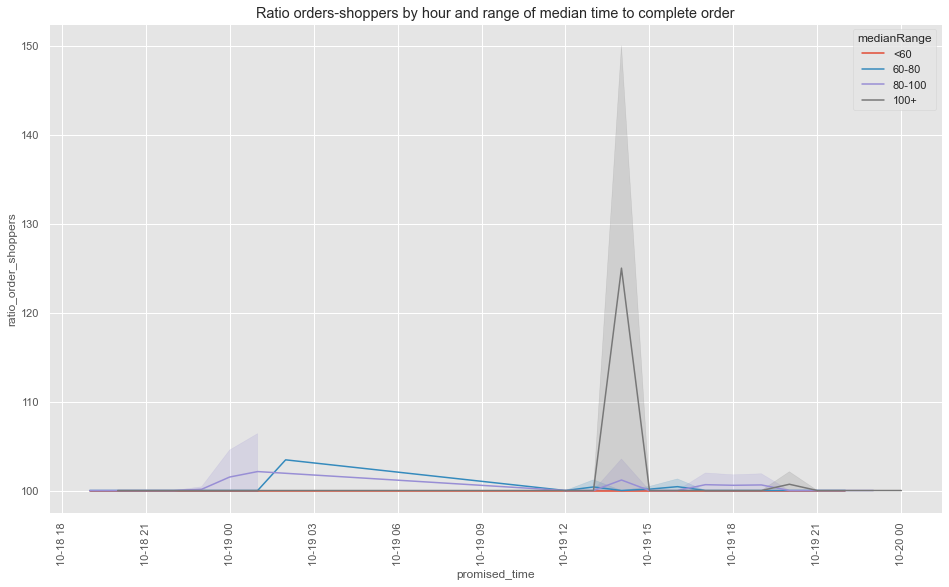

In [135]:
sns.lineplot(data=aux, x="promised_time", y="ratio_order_shoppers",hue = 'medianRange')
plt.xticks(rotation=90)
plt.title('Ratio orders-shoppers by hour and range of median time to complete order')
plt.show()

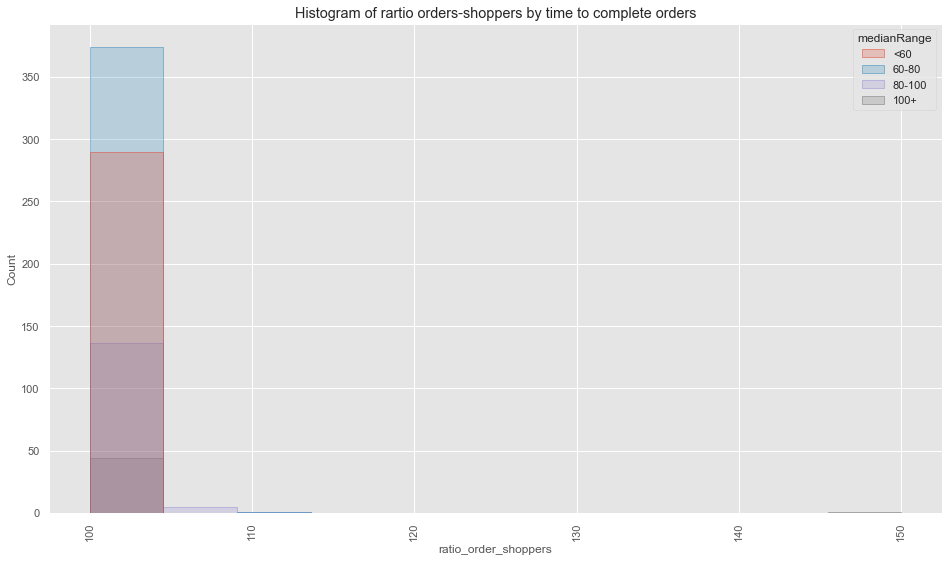

In [136]:
sns.histplot(data=aux, x="ratio_order_shoppers",hue = 'medianRange', element="step")
plt.xticks(rotation=90)
plt.title('Histogram of rartio orders-shoppers by time to complete orders')
plt.show()

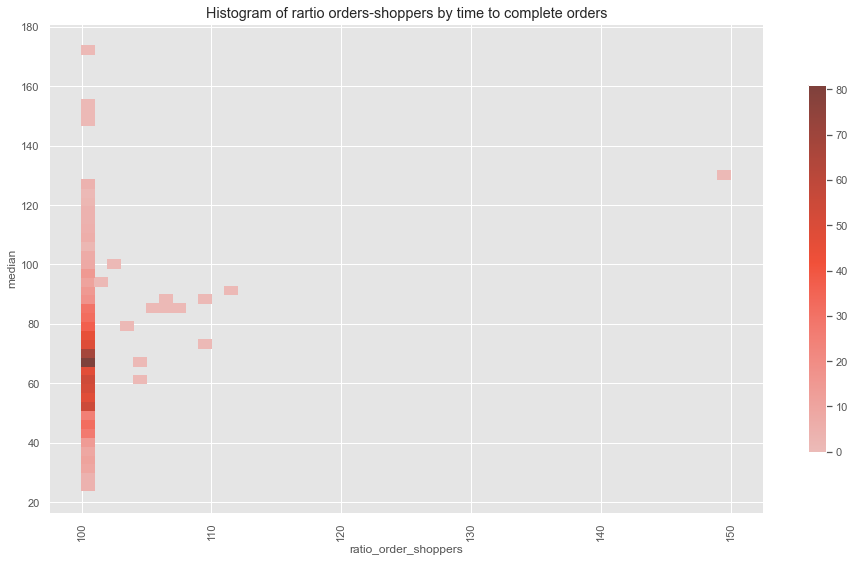

In [137]:
sns.histplot(
    aux, x="ratio_order_shoppers", y="median",
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.xticks(rotation=90)
plt.title('Histogram of rartio orders-shoppers by time to complete orders');

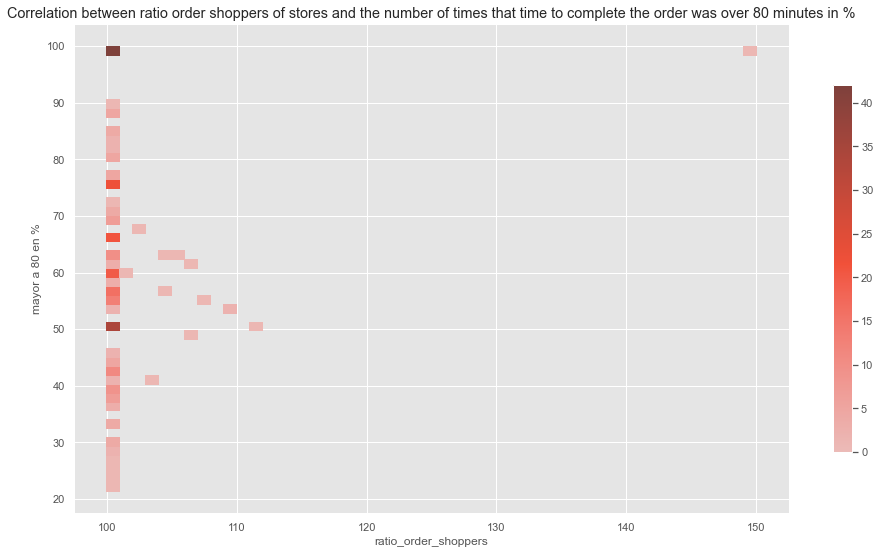

In [138]:
sns.histplot(
    aux, x="ratio_order_shoppers", y='mayor a 80 en %',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between ratio order shoppers of stores and the number of times that time to complete the order was over 80 minutes in %')
plt.show()

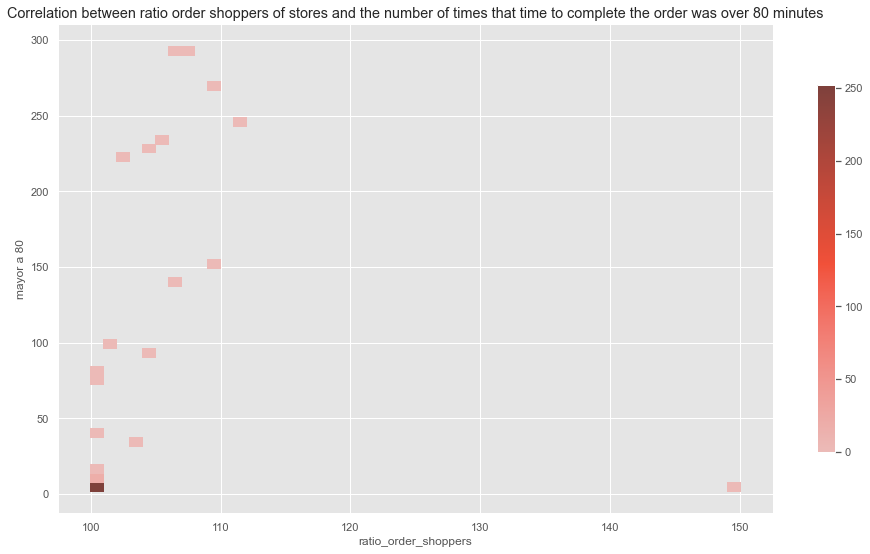

In [139]:
sns.histplot(
    aux, x="ratio_order_shoppers", y='mayor a 80',
    bins=50, discrete=(False, False), log_scale=(False,False),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.title('Correlation between ratio order shoppers of stores and the number of times that time to complete the order was over 80 minutes')
plt.show()

In [140]:
aux.corr().loc[['quantity', 'shopper_id', 'store_branch_id','product_id' ,'order_district','store_district','ratio_order_shoppers', 'median'],
               ['menor a 60', 'entre 60 y 80', 'entre 80 y 100','mayor a 100', 'mayor a 80','median']]

menor a 60  entre 60 y 80  entre 80 y 100  mayor a 100  \
quantity                0.983003       0.979444        0.967697     0.939038   
shopper_id              0.980193       0.976054        0.968988     0.940870   
store_branch_id         0.934224       0.905568        0.913533     0.937487   
product_id              0.885987       0.835827        0.860795     0.916986   
order_district          0.803047       0.827040        0.830429     0.751205   
store_district          0.788566       0.806295        0.810565     0.743760   
ratio_order_shoppers    0.948135       0.941873        0.354104     0.344313   
median                  0.179635       0.158587        0.095075     0.118404   

                      mayor a 80    median  
quantity                0.994695  0.106065  
shopper_id              0.996327  0.107218  
store_branch_id         0.965615  0.105833  
product_id              0.922520  0.068280  
order_district          0.863059  0.124534  
store_district          0.850529  0.123855  
ratio_order_shoppers    0.358764  0.137031  
median                  0.152735  1.000000

#### **Answering the questions**

* **Do these variables affect the time to complete the order? how?**

The behavior pattern shown by the times to complete the orders is repeated with respect to the number of orders, number of shoppers, number of stores and different communes in which it is distributed. Something that we should note is that when grouping by hour, the delays in completing the order are directly correlated to the increase in the number of orders, shoppers, stores and different communes where they must go to leave the order.

The rise in the ratio of orders per shopper in peak hours shows us that there is a significant saturation that occurs at the same time that the different stores where the shoppers must agree to look for the products increase. Just after these saturation periods, the number of completed orders begins to increase in more than 80 minutes.

* **Is there a correlation between these variables?**

The linear correlation between the variables number of orders, number of shoppers, number of stores and different communes in which an order is distributed per hour is high (greater than 0.8 in all cases)